In [ ]:
KR vs DH binary classifier
1.
2.
3.
4.
5.

In [28]:
### Import pdb files and labels -> prepare for graph creation ###
import os
import torch
import graphein
import pandas as pd
import re

## Import pdb files ##
route = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20231211_KS_dimers_aligned/"
# List of filenames in the pdb folder "route" #
filenames = os.listdir(route)

# Create a list of absolute file paths in route # 
absolute_file_paths = [os.path.join(route, filename) for filename in filenames]

## Import labels from file and create a dataframe matched to pdb files ##
label_sheet = pd.read_csv("/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20231108_KS_expandedset_reduction_state_labels_new_borders")   # expanded set adds 23 more clusters

# Extract gene names from file names
gene_names = [re.match(r'(.+)\.', os.path.splitext(os.path.basename(path))[0]).group(1) for path in absolute_file_paths]

# Filter labels for the matched gene names
matched_labels = label_sheet[label_sheet.iloc[:, 0].isin(gene_names)].set_index(label_sheet.columns[0])

# Create a list of gene names from the absolute file paths
file_path_gene_names = [re.match(r'(.+)\.', os.path.splitext(os.path.basename(path))[0]).group(1) for path in absolute_file_paths]

# Reorder matched_labels to match the order of absolute_file_paths
reordered_labels = matched_labels.loc[file_path_gene_names]



# Add paths # 
reordered_labels["paths"] = absolute_file_paths


         
NR_total = sum(reordered_labels['NR'])
print("No reduction:", NR_total) 
KR_total = sum(reordered_labels['KR'])
print("KR:", KR_total) 
DH_total = sum(reordered_labels['DH'])
print("DH:", DH_total) 
ER_total = sum(reordered_labels['ER'])
print("ER:", ER_total) 
total_states = NR_total + KR_total + DH_total + ER_total
num_genes = len(reordered_labels)
print("Total reduction states:", total_states)
print("Number of genes:", num_genes)




No reduction: 117
KR: 397
DH: 376
ER: 157
Total reduction states: 1047
Number of genes: 1138


In [29]:
# Divide labels
categories_list = [ 'KR','DH']
minimum_category = min( KR_total, DH_total)
sample_size = minimum_category

sample_size = 376 # You can set this to your desired sample size

padded_categories = []

for category in categories_list:
    category_rows = reordered_labels[reordered_labels[category] == 1]
    print(len(category_rows))
    num_samples = min(sample_size, len(category_rows))
    category_rows = category_rows.sample(n=num_samples)
    if num_samples < sample_size:
        additional_samples = category_rows.sample(n=sample_size - num_samples, replace=True)
        category_rows = pd.concat([category_rows, additional_samples])
    
    padded_categories.append(category_rows)

# Concatenate the original data with the padded categories
balanced_reordered_labels = pd.concat(padded_categories)

# Reset the index to ensure it's unique
balanced_reordered_labels.reset_index(drop=True, inplace=True)

# Print the counts for each category after balancing
for category in categories_list:
    category_count = len(balanced_reordered_labels[balanced_reordered_labels[category] == 1])
    print(f"Balanced {category}: {category_count}")

balanced_reordered_labels2 = balanced_reordered_labels.drop('paths', axis=1)
balanced_reordered_labels2 = balanced_reordered_labels2.drop('NR', axis=1)
balanced_reordered_labels2 = balanced_reordered_labels2.drop('ER', axis=1)

graph_label_map = balanced_reordered_labels2.to_dict(orient='index')


397
376
Balanced KR: 376
Balanced DH: 376


Output()

/home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py:160: FutureWarning:

The default value of regex will change from True to False in a future version.

/home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py:163: FutureWarning:

The default value of regex will change from True to False in a future version.

[05/20/24 16:33:10] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=995658;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=662101;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py#186\186]8;;\

                    DEBUG    Detected 826 total nodes                                                 ]8;id=927484;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=474264;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py#438\438]8;;\

                    INFO     Found: 3304 KNN edges                                                 ]8;id=342873;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=105709;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/edges/distance.py#1130\1130]8;;\

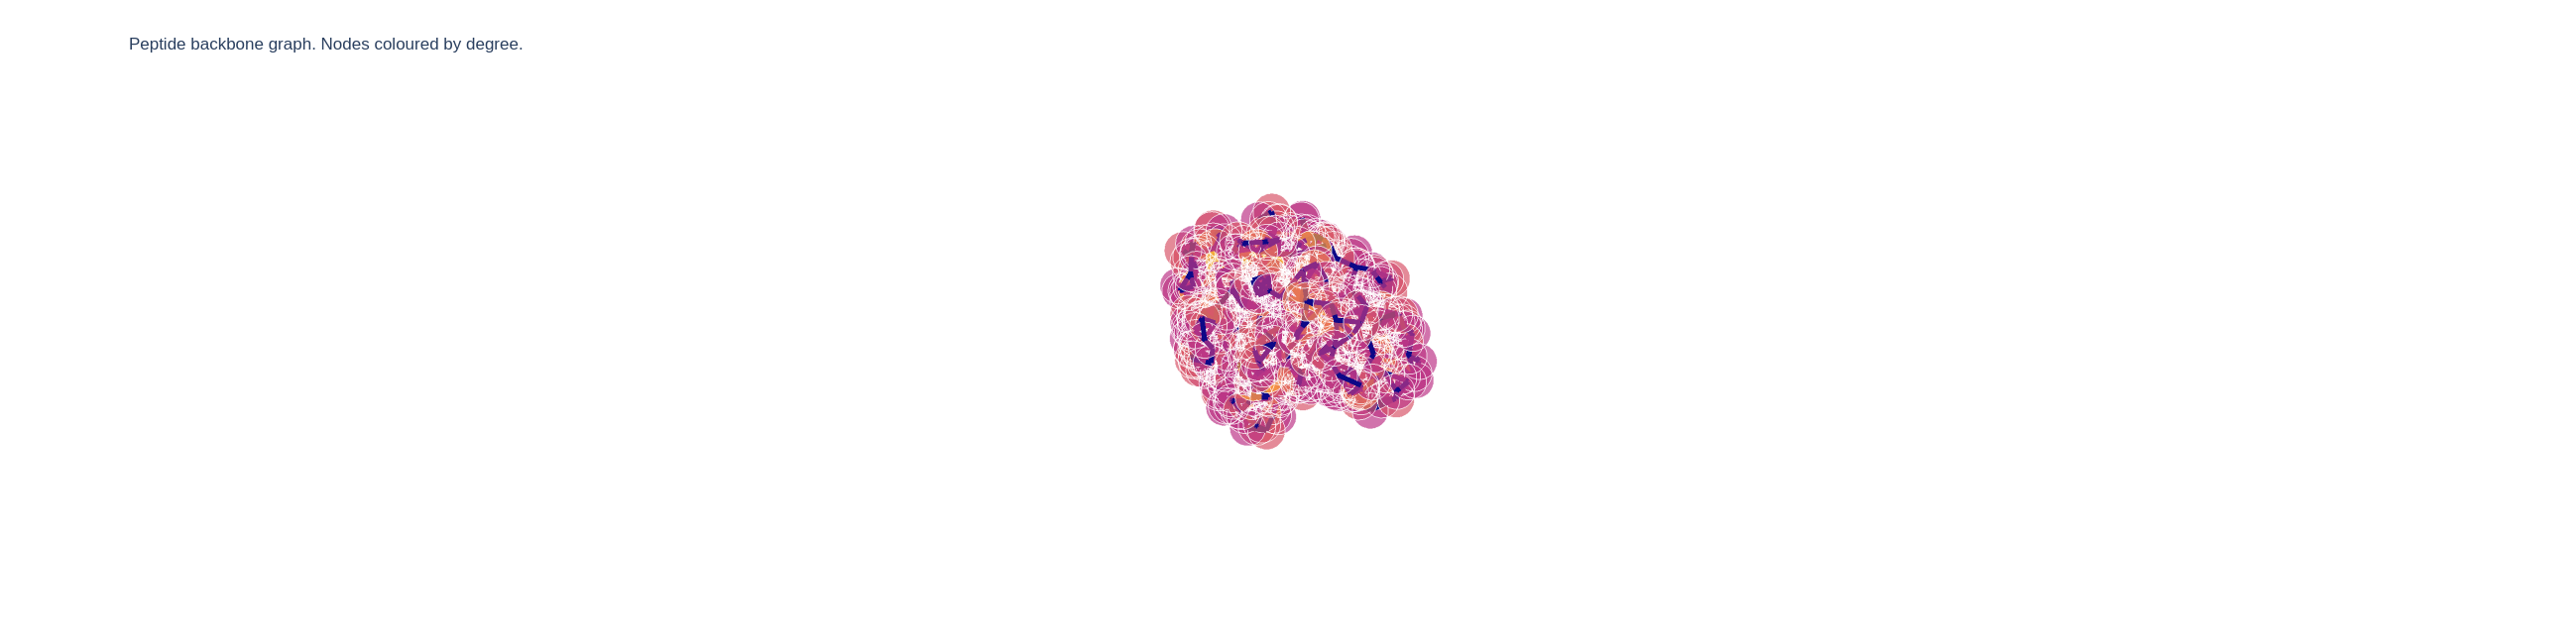

done
ProteinGraphDataset(752)
752


In [30]:
### Graph Creation methods: ###
## 4. K nearest neighbours ##
from functools import partial
from graphein.protein.edges.distance import add_k_nn_edges
from graphein.protein.features.nodes.amino_acid import amino_acid_one_hot
from graphein.protein.visualisation import plotly_protein_structure_graph
from graphein.protein.graphs import construct_graph

new_edge_funcs = {"edge_construction_functions": [partial(add_k_nn_edges, k=4, long_interaction_threshold=0)],
                  "node_metadata_functions": [amino_acid_one_hot]
                  }
config = graphein.protein.ProteinGraphConfig(**new_edge_funcs)

g = construct_graph(config=config, path=absolute_file_paths[0])

p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="degree",
    label_node_ids=False,
    plot_title="Peptide backbone graph. Nodes coloured by degree.",
    node_size_multiplier=1
    )
p.show()

### Create an in-file dataset for passing to pytorch geometric ###
## Note: this can take a while. If the dataset already exists it won't be regenerated ##
from graphein.ml import GraphFormatConvertor, ProteinGraphDataset

# list of columns included in nx ==> pyg conversion #
info_list = ["edge_index", 
             "amino_acid_one_hot",
             "node_id", 
             "chain_id", 
             "residue_name", 
             "residue_number", 
             "atom_type", 
             "element_symbol",
             "coords",
             "b_factor", 
             "kind", 
             "name",
             "chain_ids"]

# NetworkX to PyG conversion #
convertor= GraphFormatConvertor(src_format = "nx", 
                                dst_format = "pyg", 
                                verbose = "all_info", 
                                columns = info_list
                               )

# Convert the graph_label_map dictionary to a list of tensors # 
graph_labels_list = [torch.tensor(list(label.values())) for label in graph_label_map.values()]

# Convert paths to a list of paths
paths_list=balanced_reordered_labels['paths'].tolist()
# Create the dataset with graph_labels as a list of tensors #
dataset = ProteinGraphDataset(
    root='/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20240308_KS_dimers_Reduction_State_K4_KR_DH', 
    paths=paths_list,
    graphein_config=config, 
    graph_labels=graph_labels_list,
    graph_format_convertor=convertor,
    num_cores=7
)

print("done")

print(dataset)
print(len(graph_labels_list))

In [31]:
from sklearn.model_selection import train_test_split
### Data loaders ### 
from torch_geometric.data import Data, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the dataset into training, validation, and test sets #
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 64

# Define your custom Data class with __cat_dim__ method
class MyData(Data):
    def __cat_dim__(self, key, value, *args, **kwargs):
        if key == 'graph_y':
            return None  # Indicates that 'graph_y' should be batched along a new dimension
        return super().__cat_dim__(key, value, *args, **kwargs)

# Create a list of Data objects, ensuring 'graph_y' is a 2D tensor [num_examples, num_labels]
# Initialize an empty list to store the modified Data objects
data_list = []

# Iterate through your existing ProteinGraphDataset
for graph in dataset:
    # Create a new Data object
    data = Data(
        edge_index = graph.edge_index, 
        node_id = graph.node_id,
        coords = graph.coords, 
        name = graph.name,
        num_nodes = graph.num_nodes,
        graph_y = graph.graph_y.view(1, 2), 
        x=graph.amino_acid_one_hot.view(len(graph.node_id), 20),
    )
    # Append the modified Data object to the list
    data_list.append(data)




# Extract labels from your data_list
labels = [data.graph_y.tolist()[0] for data in data_list]

# Split the data into training, validation, and test sets with stratified sampling
train_data, test_data, train_labels, test_labels = train_test_split(data_list, labels, test_size=test_ratio, random_state=42, stratify=labels)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=val_ratio/(1-test_ratio), random_state=42, stratify=train_labels)

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

print("Train_set:", len(train_loader.dataset))
print("Val_set:", len(val_loader.dataset))
print("Test_set:", len(test_loader.dataset))

def count_labels(loader):
    KR_count = 0
    DH_count = 0
    total_count = 0
    
    for batch in loader:
        # Extract labels from the batch
        labels = batch.graph_y.squeeze().tolist()
        
        # Count mal and mmal labels in the batch
        KR_count += labels.count([1, 0])
        DH_count += labels.count([0, 1])
        total_count += len(labels)
    
    return KR_count, DH_count, total_count

# Calculate label composition for each loader
train_KR, train_DH, train_total = count_labels(train_loader)
val_KR, val_DH,  val_total = count_labels(val_loader)
test_KR, test_DH, test_total = count_labels(test_loader)

# Print the results
print("Training Set Composition:")
print(f"KR: {train_KR} samples, DH: {train_DH} samples, Total: {train_total} samples")


print("\nValidation Set Composition:")
print(f"KR: {val_KR} samples, DH: {val_DH}, Total: {val_total} samples")


print("\nTest Set Composition:")
print(f"KR: {test_KR} samples, DH: {test_DH}, Total: {test_total} samples")


Train_set: 600
Val_set: 76
Test_set: 76
Training Set Composition:
KR: 300 samples, DH: 300 samples, Total: 600 samples

Validation Set Composition:
KR: 38 samples, DH: 38, Total: 76 samples

Test Set Composition:
KR: 38 samples, DH: 38, Total: 76 samples


DataBatch(x=[54308, 20], edge_index=[2, 124750], node_id=[64], coords=[54308, 3], name=[64], num_nodes=54308, graph_y=[64, 2], batch=[54308], ptr=[65])
Epoch [1/80] - Train Loss: 0.6931 - Train Accuracy: 0.4967 - Train AUC: 0.5344 - Validation Loss: 0.6931 - Validation Accuracy: 0.5000 - Validation AUC: 0.5436
Epoch [2/80] - Train Loss: 0.6919 - Train Accuracy: 0.5100 - Train AUC: 0.6674 - Validation Loss: 0.6919 - Validation Accuracy: 0.5000 - Validation AUC: 0.7008
Epoch [3/80] - Train Loss: 0.6915 - Train Accuracy: 0.5083 - Train AUC: 0.6428 - Validation Loss: 0.6910 - Validation Accuracy: 0.5132 - Validation AUC: 0.7431
Epoch [4/80] - Train Loss: 0.6900 - Train Accuracy: 0.6300 - Train AUC: 0.7125 - Validation Loss: 0.6900 - Validation Accuracy: 0.5000 - Validation AUC: 0.7632
Epoch [5/80] - Train Loss: 0.6889 - Train Accuracy: 0.6883 - Train AUC: 0.7622 - Validation Loss: 0.6888 - Validation Accuracy: 0.7500 - Validation AUC: 0.7936
Epoch [6/80] - Train Loss: 0.6872 - Train Accura

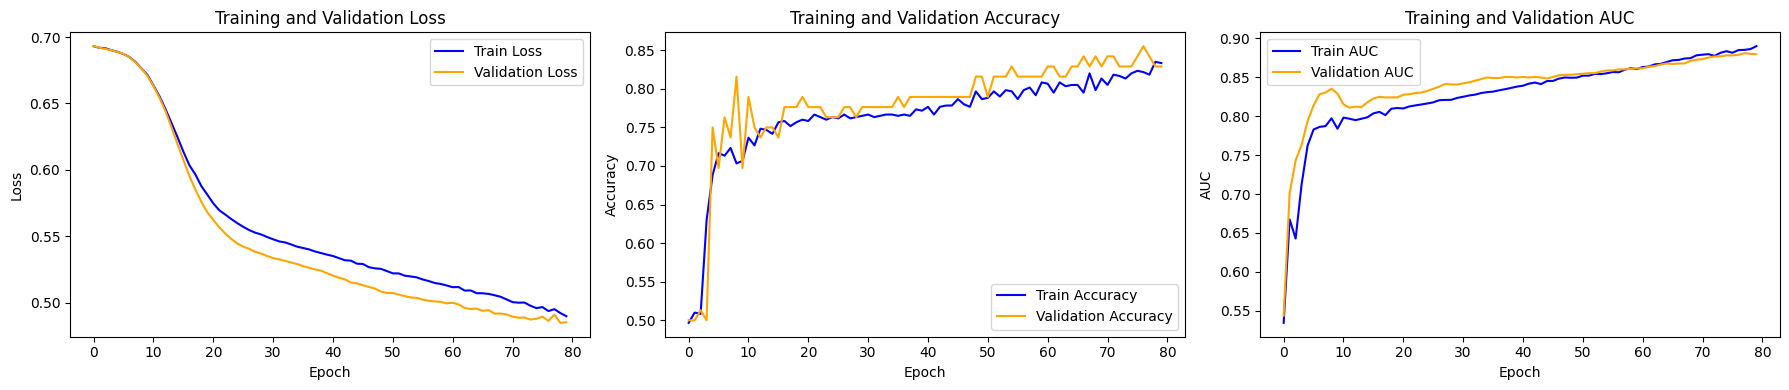

Training finished!
Test Accuracy: 0.8553
Test AUC: 0.9245


In [33]:
### Training and validation ###
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Set seed
torch.manual_seed(15706112877486103401)

# Network parameters
input_dim = 20  # Corresponds to amino acid OHE
hidden_dim = 64 # Neural network density
output_dim = 2  # Set model to binary classification

# Hyperparameters
num_epochs = 80
learning_rate = 0.001

# Define a GNN model
class MyGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        # Convert input tensor 'x' to Float data type
        x = x.float()
        
        # Apply the first graph convolution layer
        x = self.conv1(x, edge_index)
        x = x.relu()
    
        # Apply the second graph convolution layer
        x = self.conv2(x, edge_index)
        x = x.relu()
    
        # Perform graph-level pooling (e.g., global max pooling)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        x = F.softmax(x, dim=1) 
    
        return x

# Initialize your GNN model
model = MyGNN(input_dim, hidden_dim, output_dim)

# Define batching
batch = next(iter(train_loader))
print(batch)

# Forward pass through the model
out = model(batch.x, batch.edge_index, batch.batch)

# Define optimization method
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Empty containers for loss and accuracy metrics
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

train_aucs = []  # New list to store training AUC values
val_aucs = []  # New list to store validation AUC values

## Training and validation loops ##
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0
    train_predictions = []  # New list to store training predictions
    train_labels_all = []  # New list to store true training labels
    
    # Training loop
    model.train()
    train_correct_count = 0  # Total number of correct predictions for the epoch
    train_total_count = 0  # Total number of samples for the epoch

    # Validation loop
    model.eval()
    val_loss = 0.0
    total_correct_val = 0
    total_samples_val = 0
    val_predictions = []  # New list to store predictions
    val_labels_all = []  # New list to store true labels
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
    
            labels = (batch.graph_y[:, 0] == 1).long()
    
            loss = F.cross_entropy(out, labels, reduction='sum')
            val_loss += loss.item()
    
            predicted_labels = out.argmax(dim=1)
            total_correct_val += (predicted_labels == labels).sum().item()
            total_samples_val += labels.size(0)
    
            # Store predictions and true labels for each batch
            val_predictions.extend(out[:, 1].cpu().numpy())  # Detach not needed for no_grad context
            val_labels_all.extend(labels.cpu().numpy())


    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Compute loss
        loss = F.cross_entropy(out, labels, reduction='sum')
        epoch_train_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        predicted_labels = out.argmax(dim=1)
        train_correct_count += (predicted_labels == labels).sum().item()
        train_total_count += labels.size(0)
        
        # Store predictions and true labels for each batch
        train_predictions.extend(out[:, 1].detach().cpu().numpy())  # Detach the tensor before converting to numpy
        train_labels_all.extend(labels.detach().cpu().numpy())
    
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # Calculate training accuracy
    train_accuracy = train_correct_count / train_total_count
    train_accuracies.append(train_accuracy)
    
    # Calculate AUC-ROC for training data
    train_auc = roc_auc_score(train_labels_all, train_predictions)
    train_aucs.append(train_auc)
    
    
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    
    # Calculate overall validation accuracy using all true labels
    val_accuracy = total_correct_val / total_samples_val
    val_accuracies.append(val_accuracy)
    
    # Calculate AUC-ROC for validation data
    val_auc = roc_auc_score(val_labels_all, val_predictions)
    val_aucs.append(val_auc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Train AUC: {train_auc:.4f} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation AUC: {val_auc:.4f}")

# Plotting the training progress
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_aucs, label='Train AUC', color='blue')
plt.plot(val_aucs, label='Validation AUC', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished!")

### Test data ###
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score

# Assuming you have your test data in a DataLoader called test_loader
# If you don't have one, create it similarly to how you created train_loader and val_loader.

# Set the model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
total_correct_test = 0
total_samples_test = 0

# Lists to store predictions and true labels for potential further analysis
test_predictions = []
test_labels = []
test_probabilities = []  # New list to store probabilities for AUC

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)  # Send data to GPU if available
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Calculate predictions
        predicted_labels = out.argmax(dim=1)
        
        # Accumulate the number of correct predictions and total samples
        total_correct_test += (predicted_labels == labels).sum().item()
        total_samples_test += labels.size(0)

        # Store predictions and true labels
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probabilities.extend(out[:, 1].cpu().numpy())  # Store the probabilities for the positive class

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)

# Calculate test AUC
test_auc = roc_auc_score(test_labels, test_probabilities)

# Report the test accuracy and AUC
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Processing batch with 64 graphs
Explanation for graph leoB_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


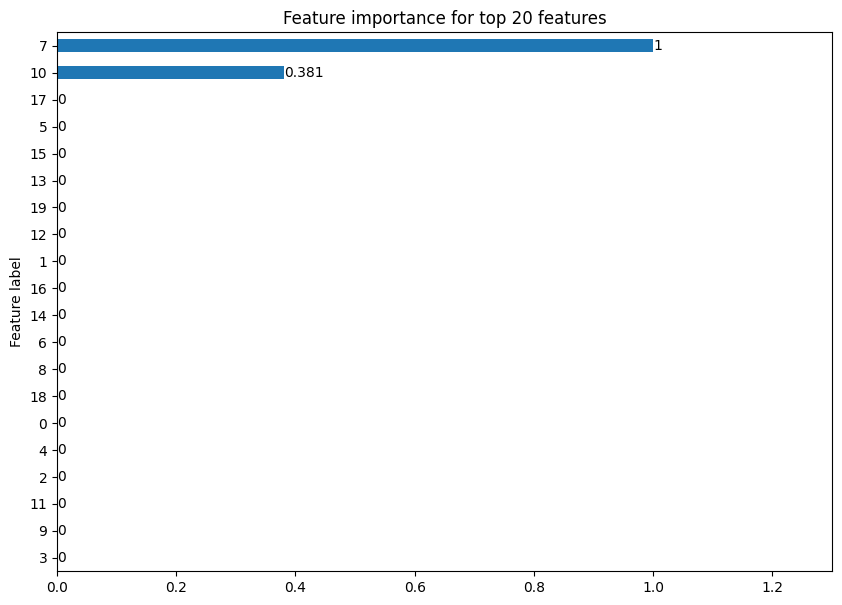

Explanation for graph ttmH_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


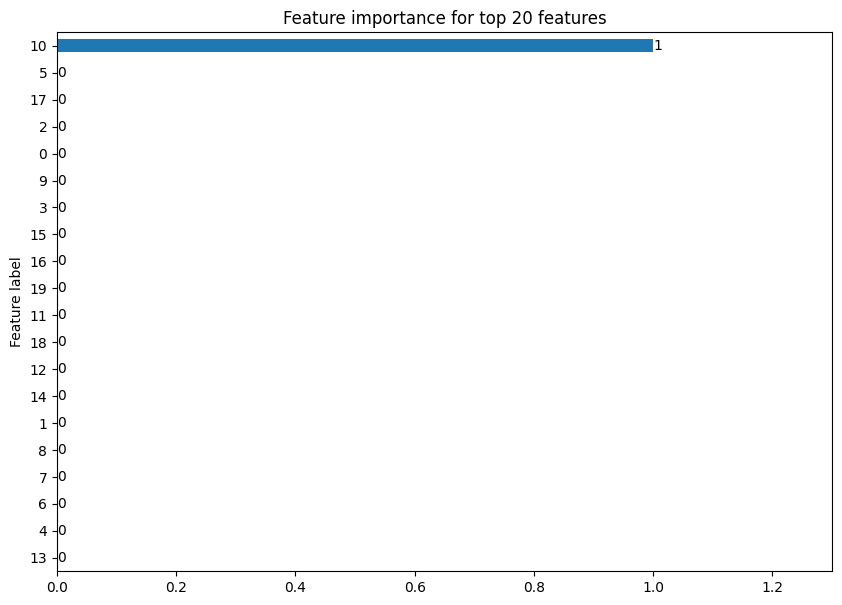

Explanation for graph asmA_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.4324e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


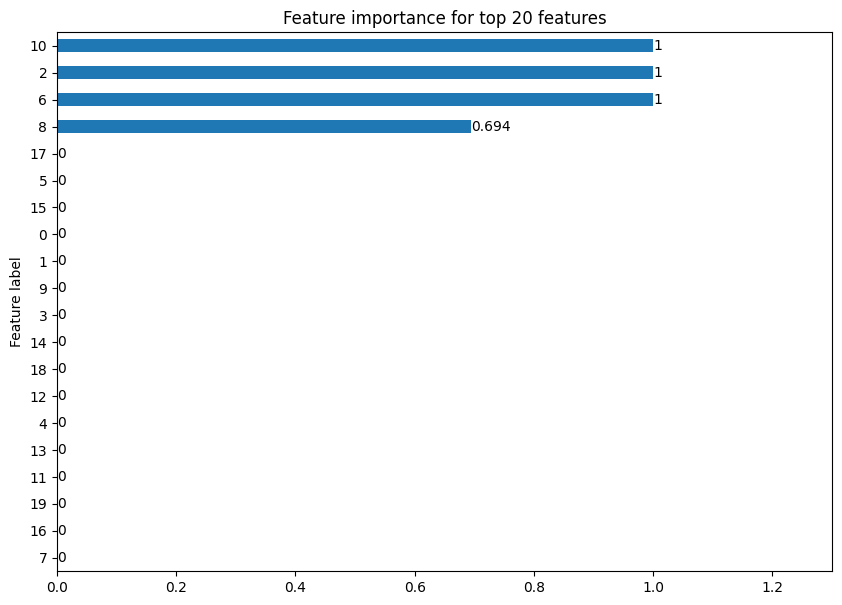

Explanation for graph tmnVI_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0829e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


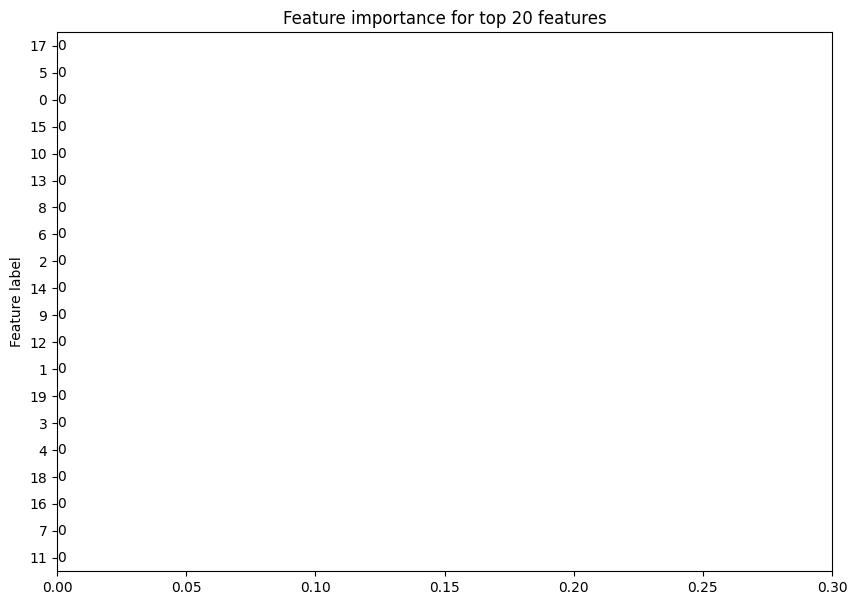

Explanation for graph nbrI_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


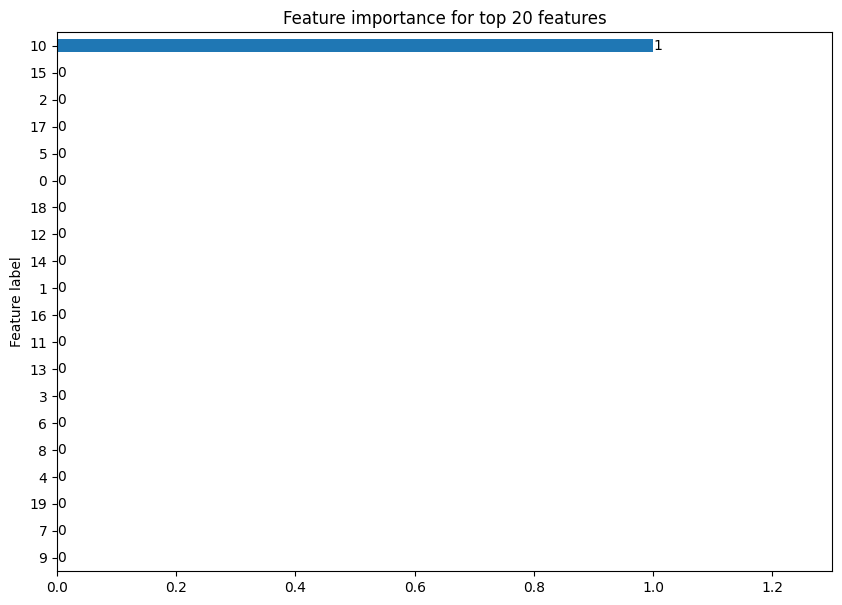

Explanation for graph mlaF_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


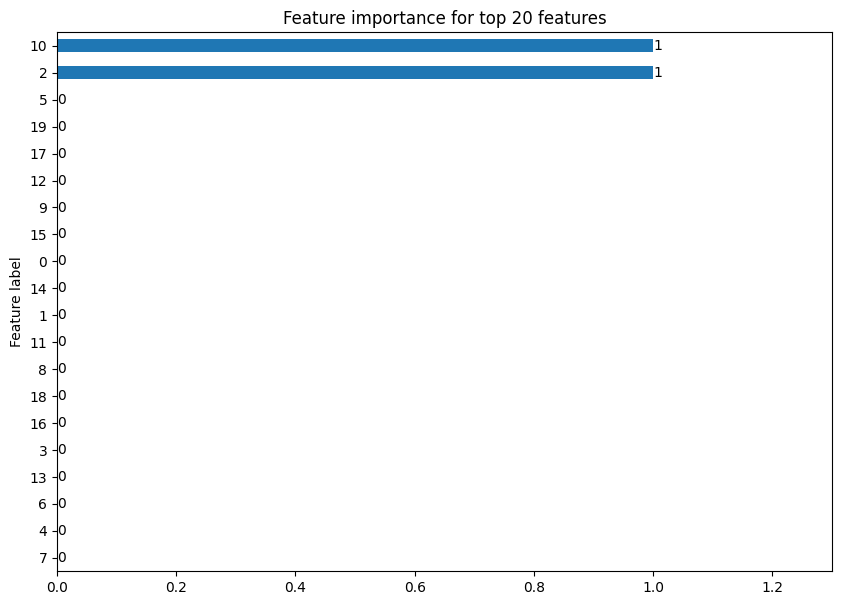

Explanation for graph slnA2_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


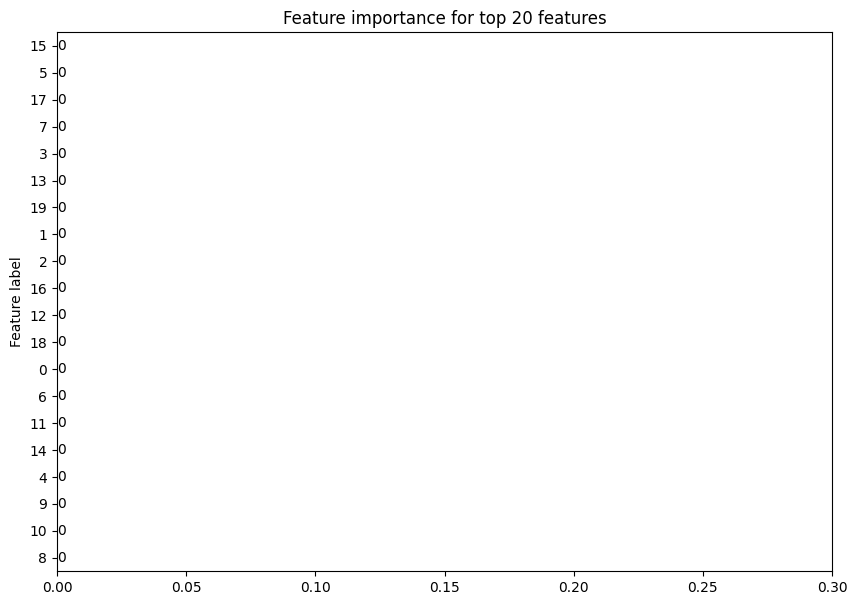

Explanation for graph megAII_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


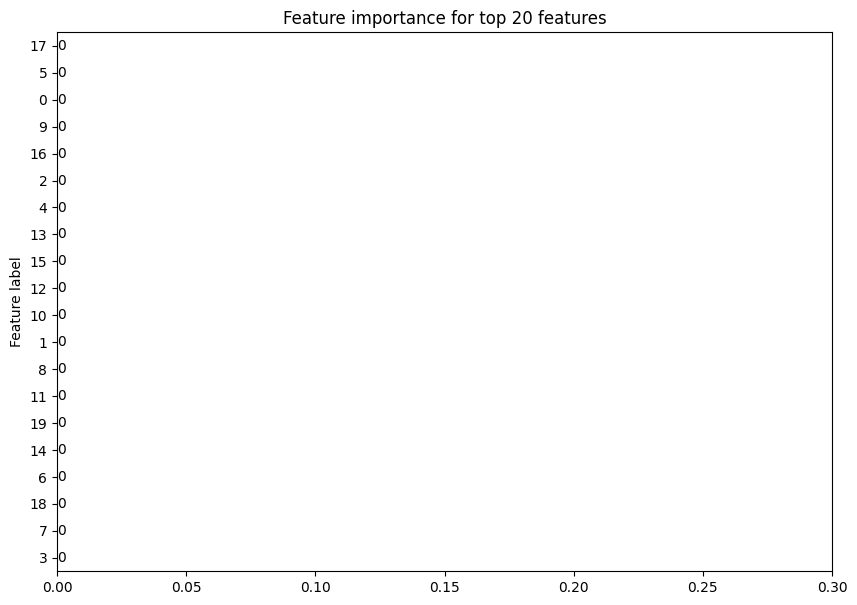

Explanation for graph fosD_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


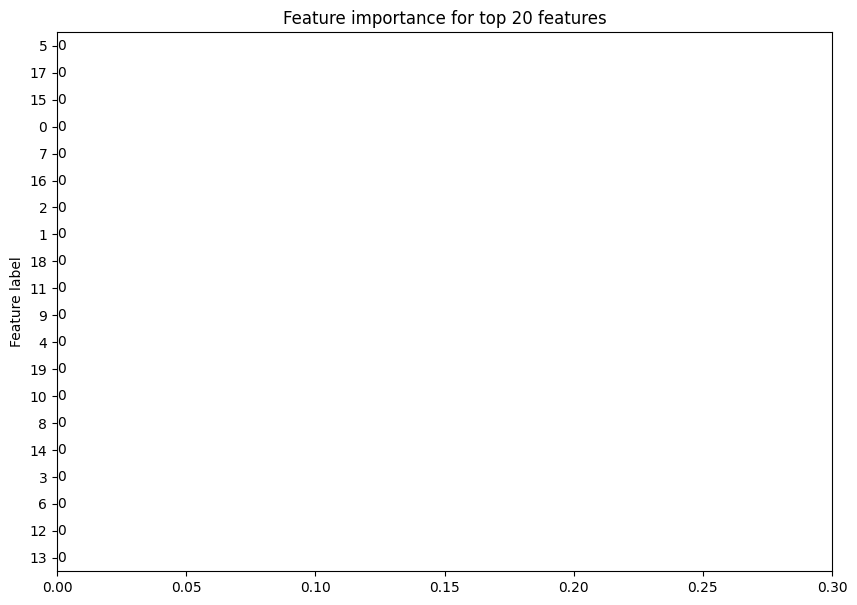

Explanation for graph cle6_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.1644e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


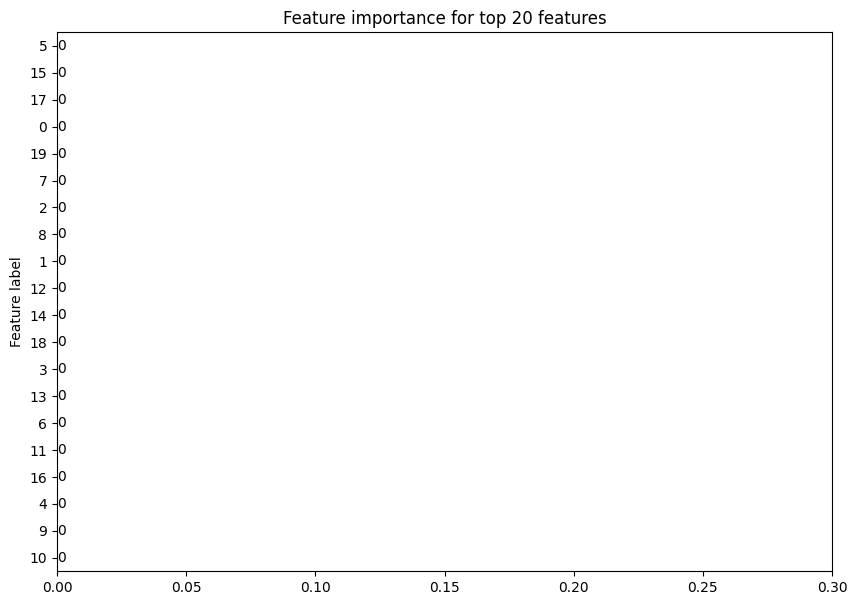

Explanation for graph BafAII_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


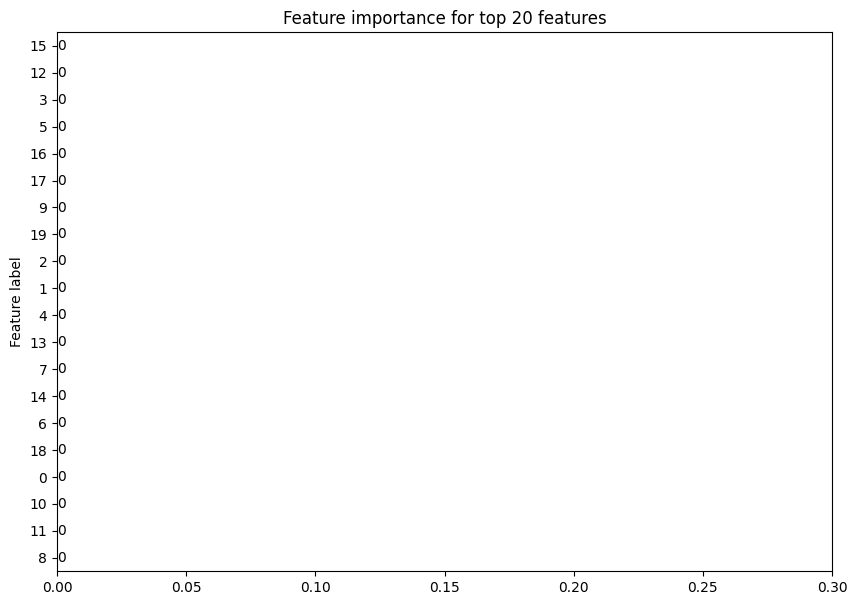

Explanation for graph pldAII_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.9810e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


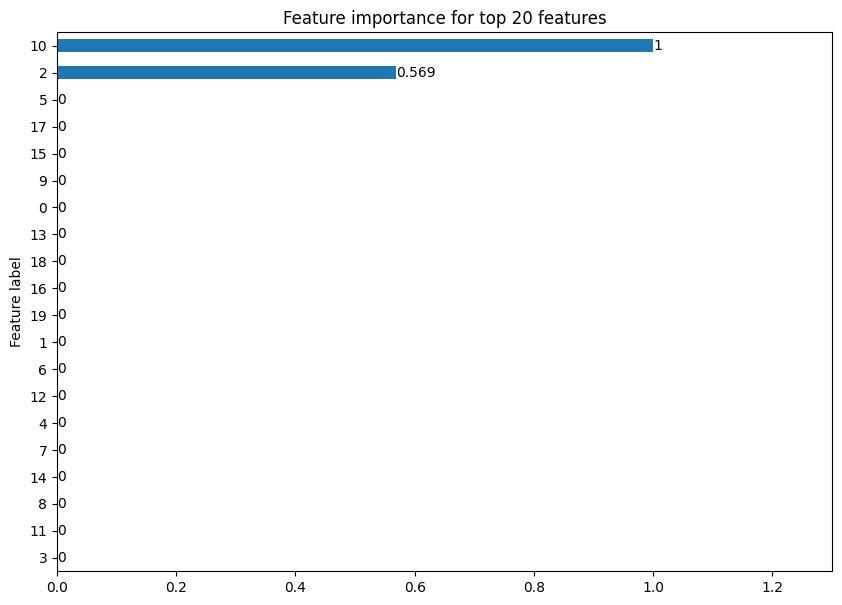

Explanation for graph aalA2_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


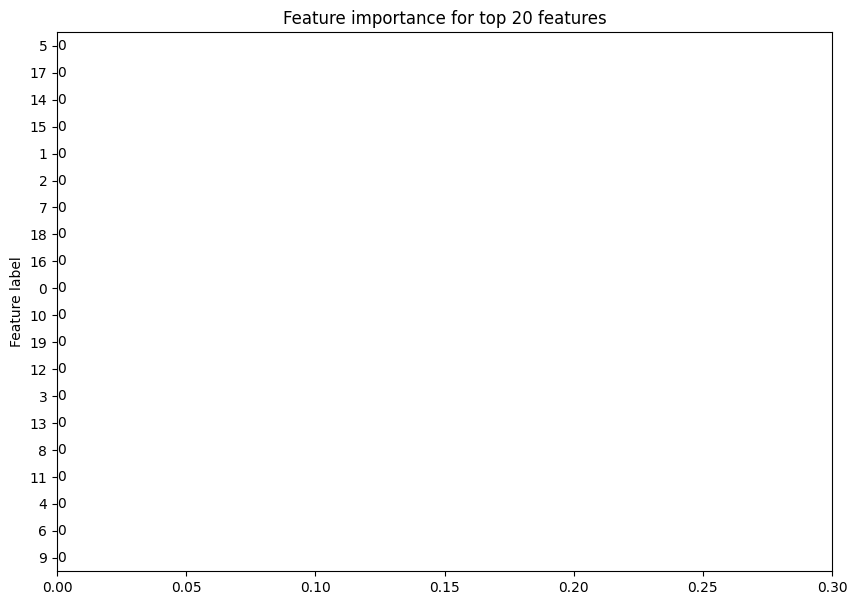

Explanation for graph ttnA_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.8981e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


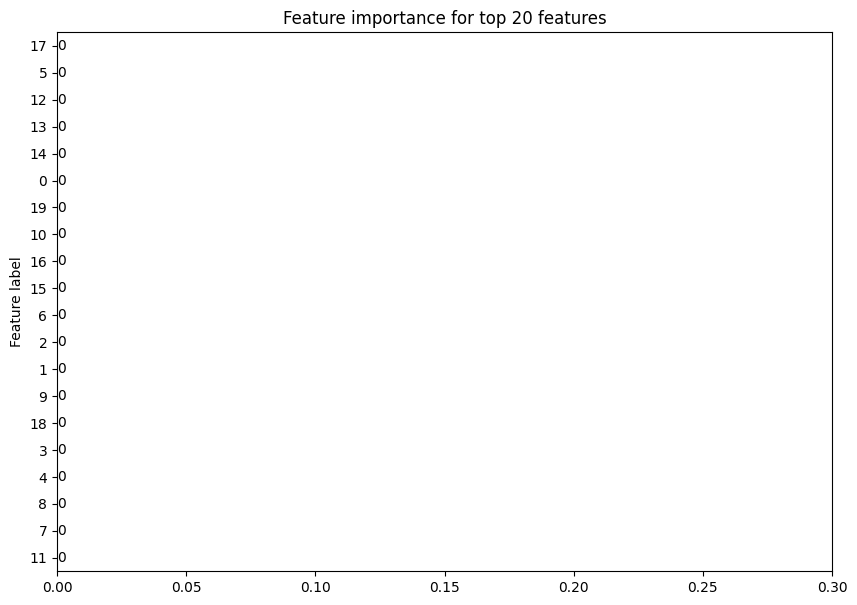

Explanation for graph almHV_Mod.8.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


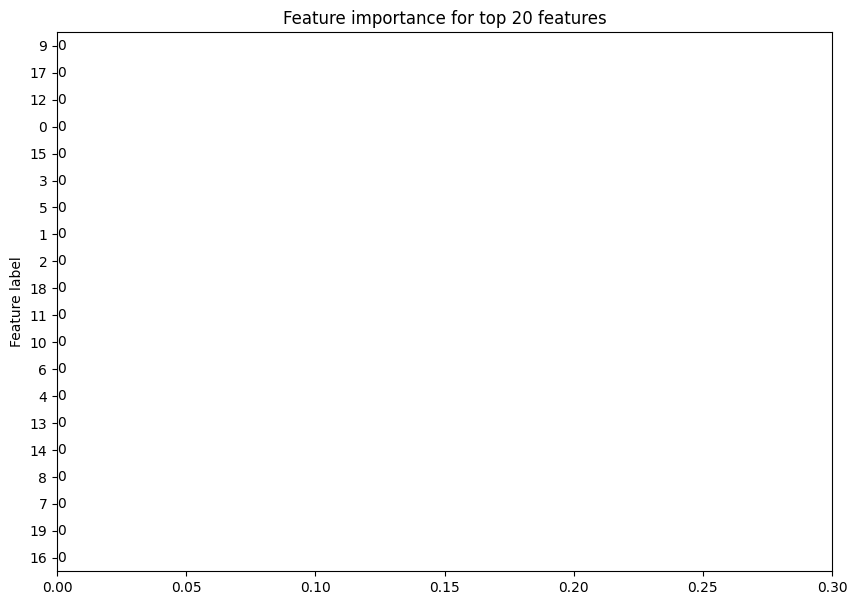

Explanation for graph kijA_Mod.11.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0768e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


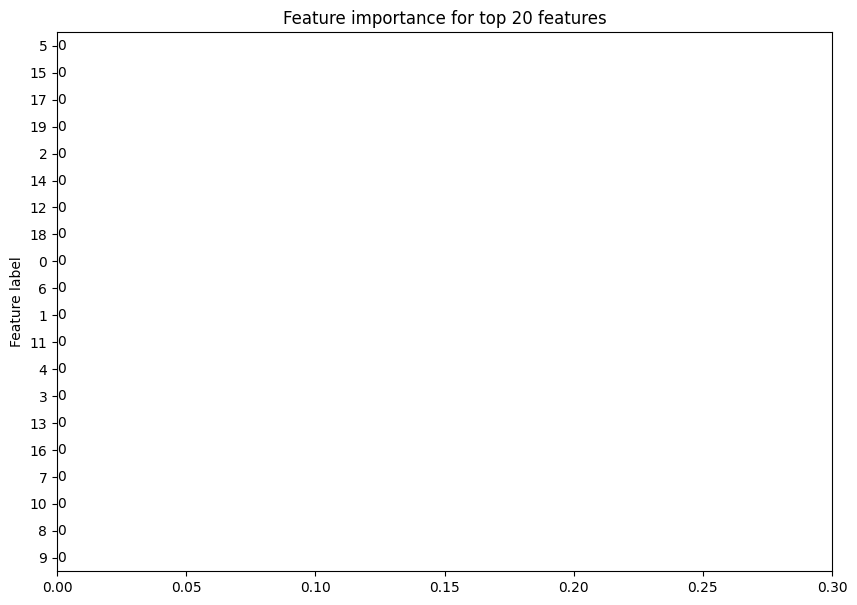

Explanation for graph tmnAV_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


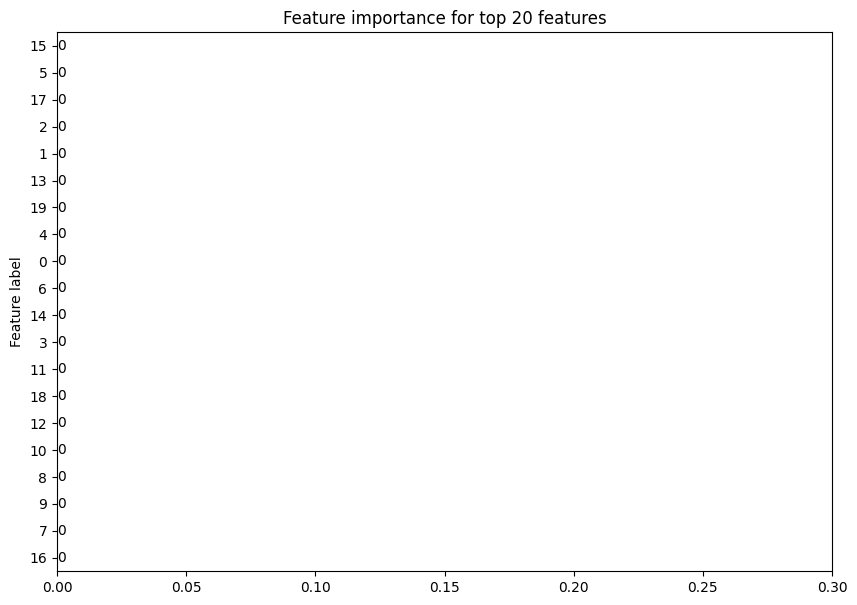

Explanation for graph selI_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


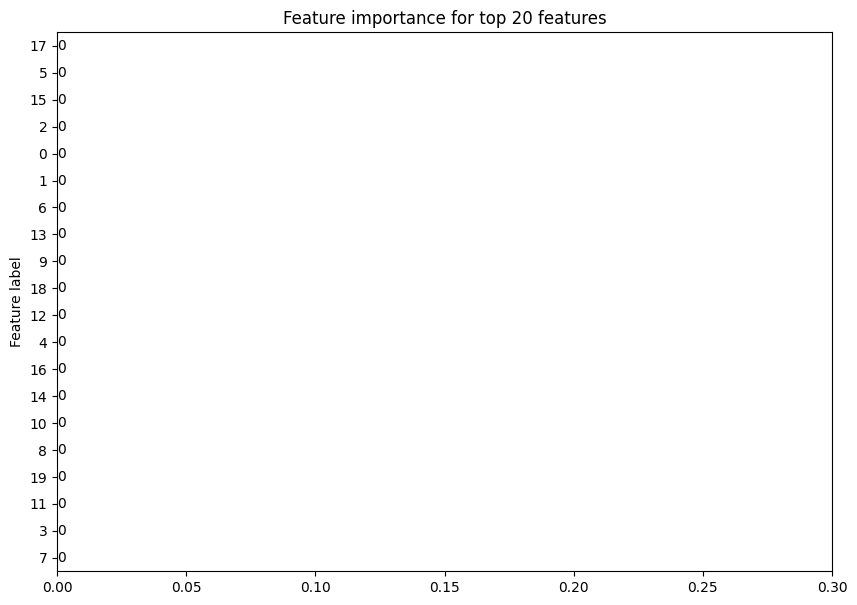

Explanation for graph nidA3_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


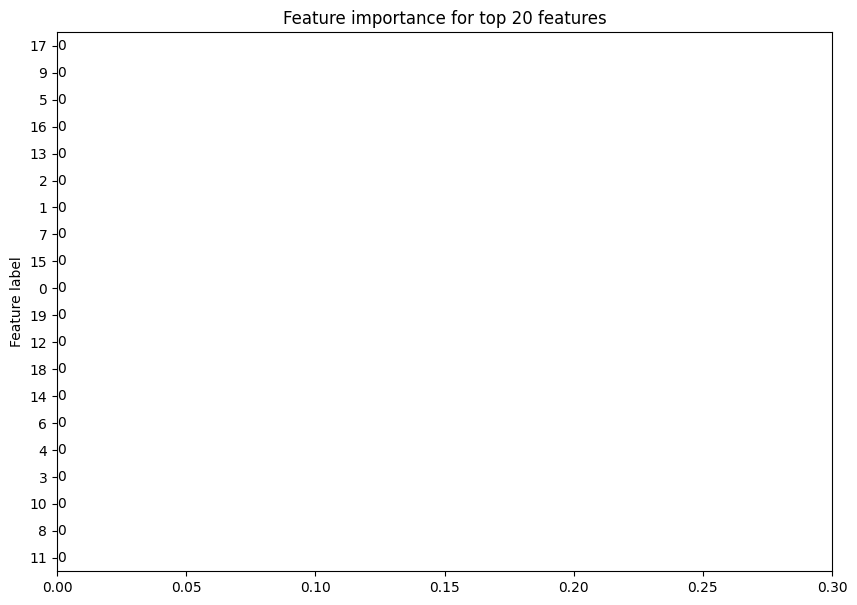

Explanation for graph lobA5_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


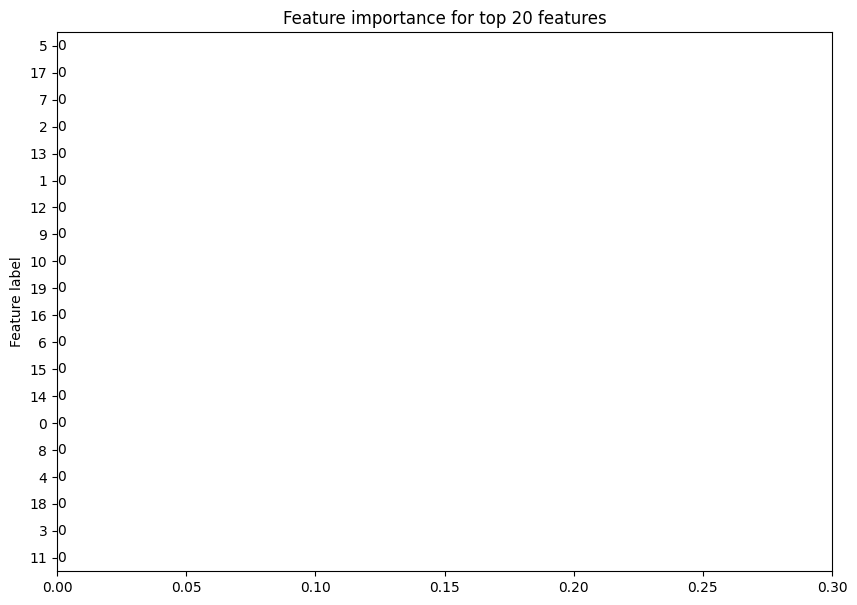

Explanation for graph merC_Mod.6.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


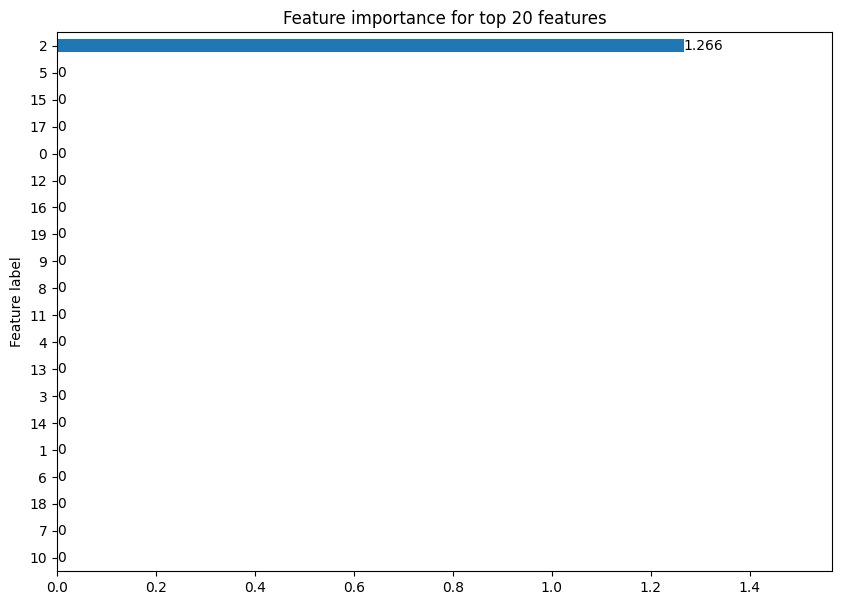

Explanation for graph cle3_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.6091e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


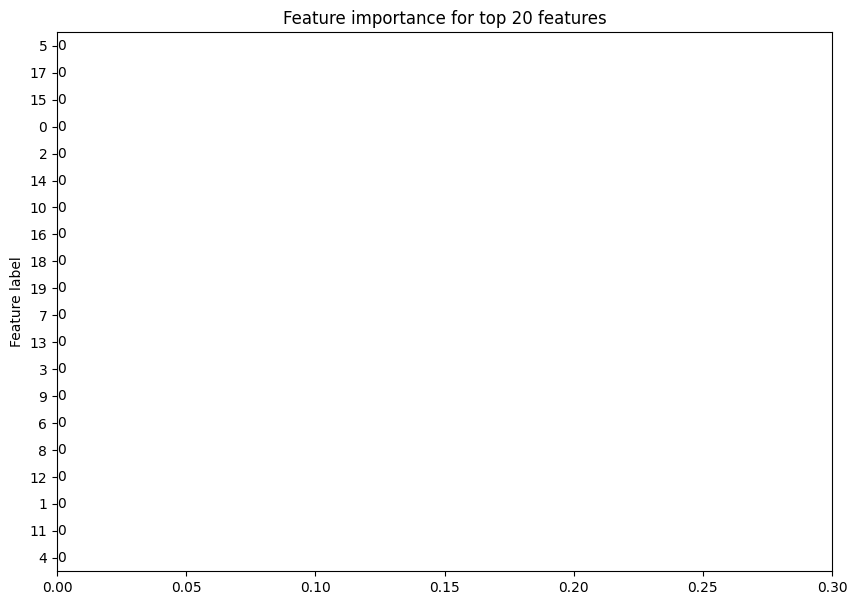

Explanation for graph fscC_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


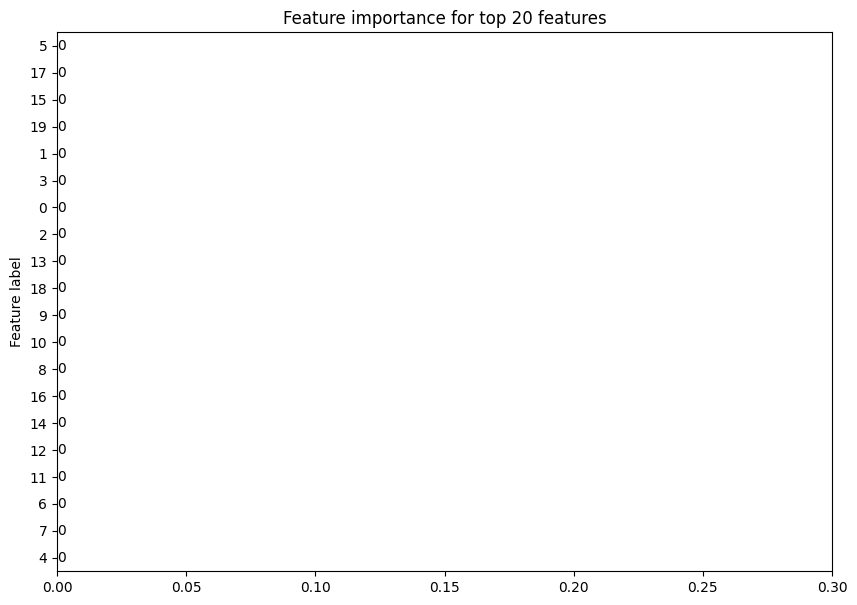

Explanation for graph plm6_Mod.1.pdb_aligned: tensor([1., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.0600e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


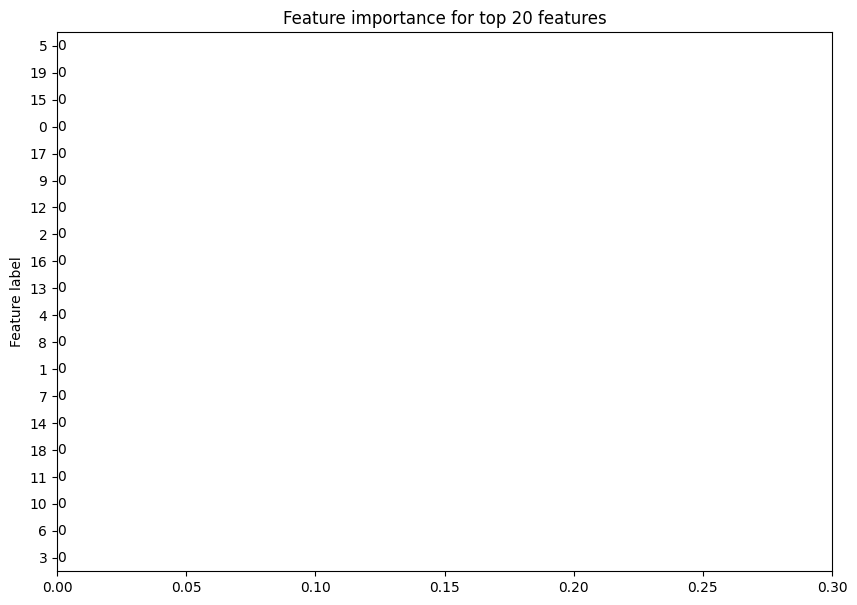

Explanation for graph aizE_mod.17.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


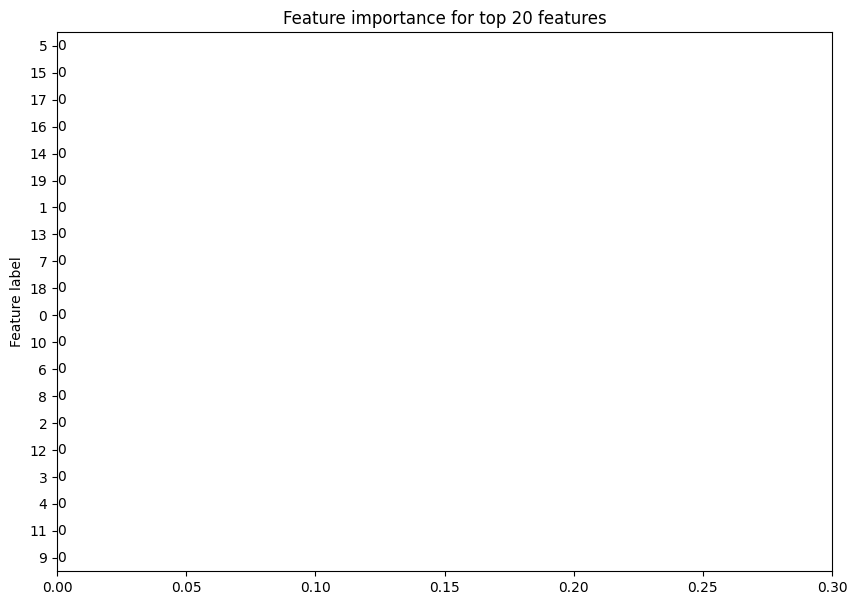

Explanation for graph leoB_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


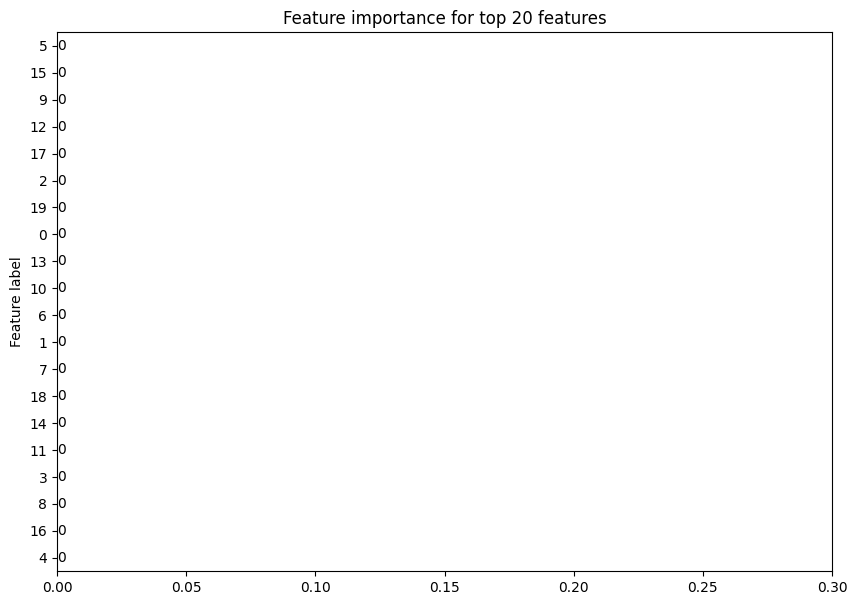

Explanation for graph phn2_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


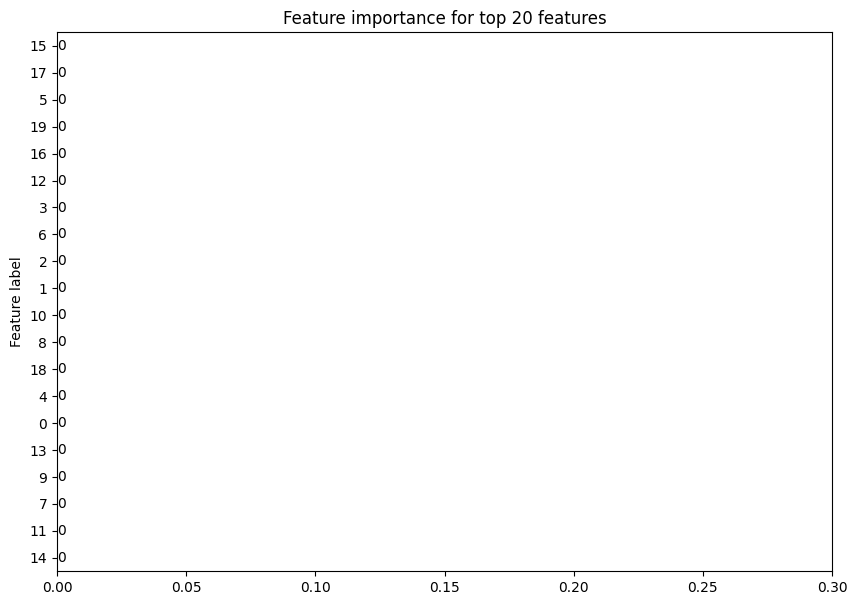

Explanation for graph chmGII_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


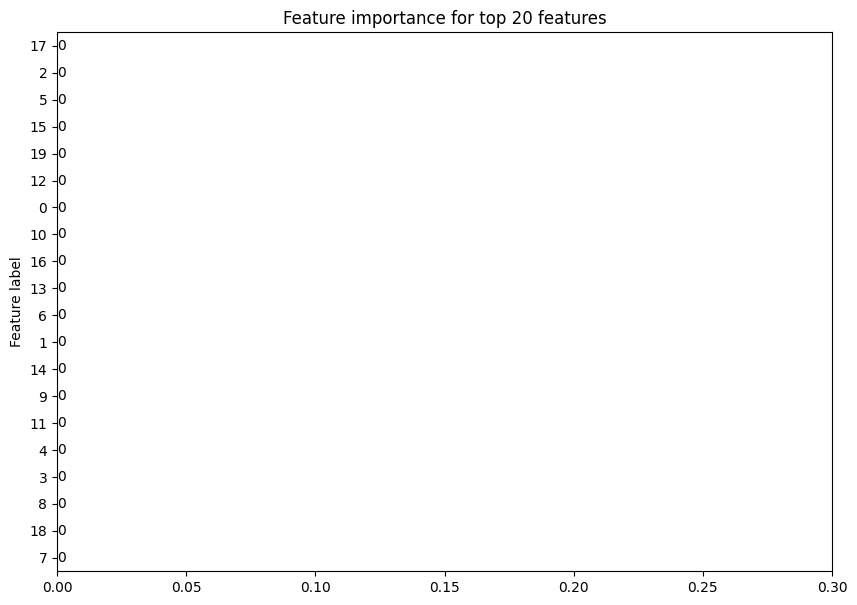

Explanation for graph BafAIV_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


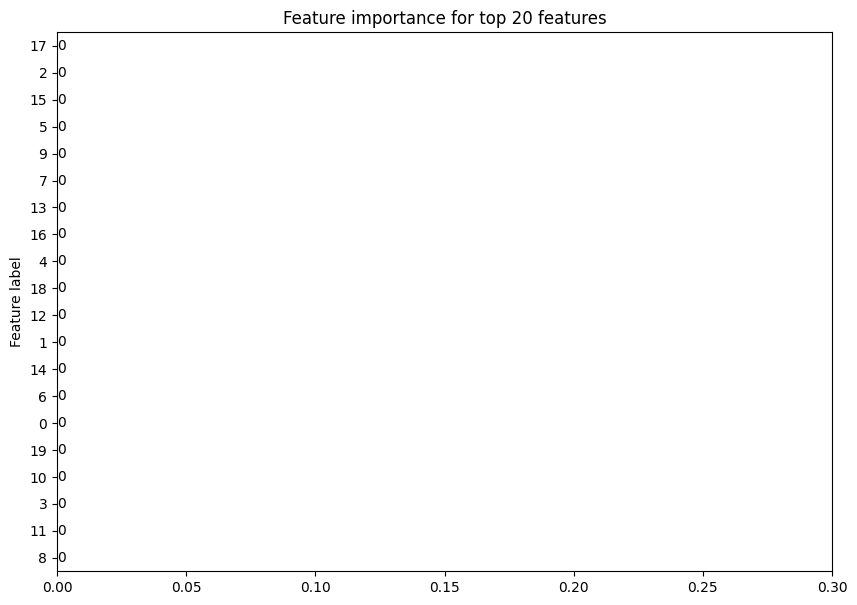

Explanation for graph AceP5_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


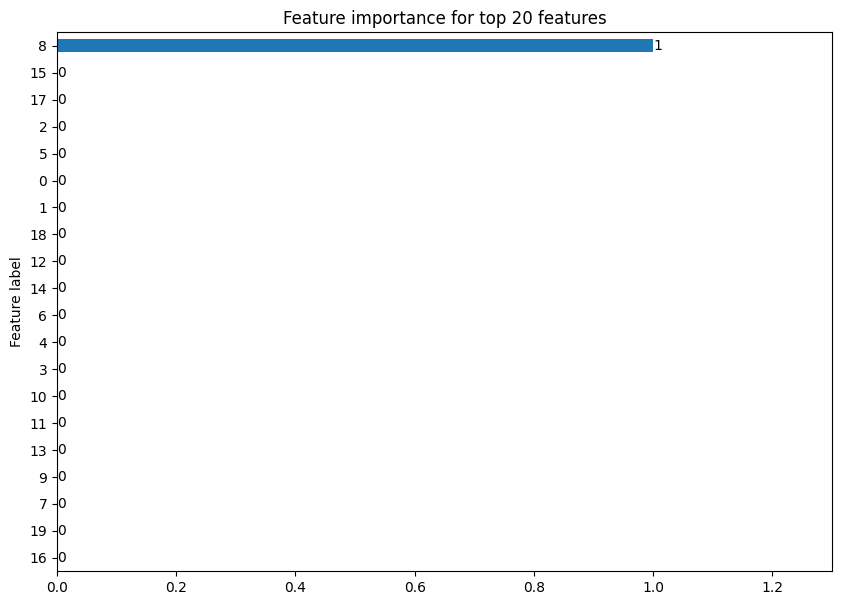

Explanation for graph becF_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


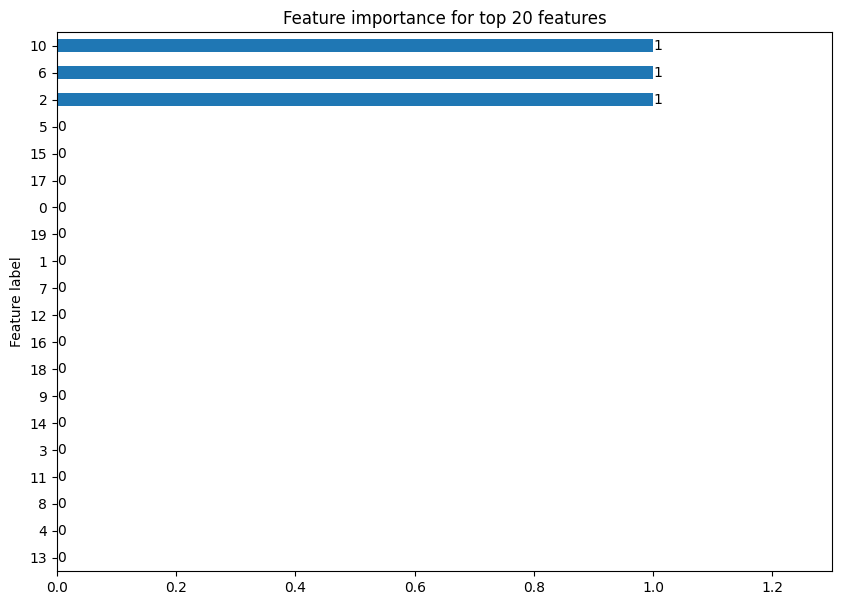

Explanation for graph cle6_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


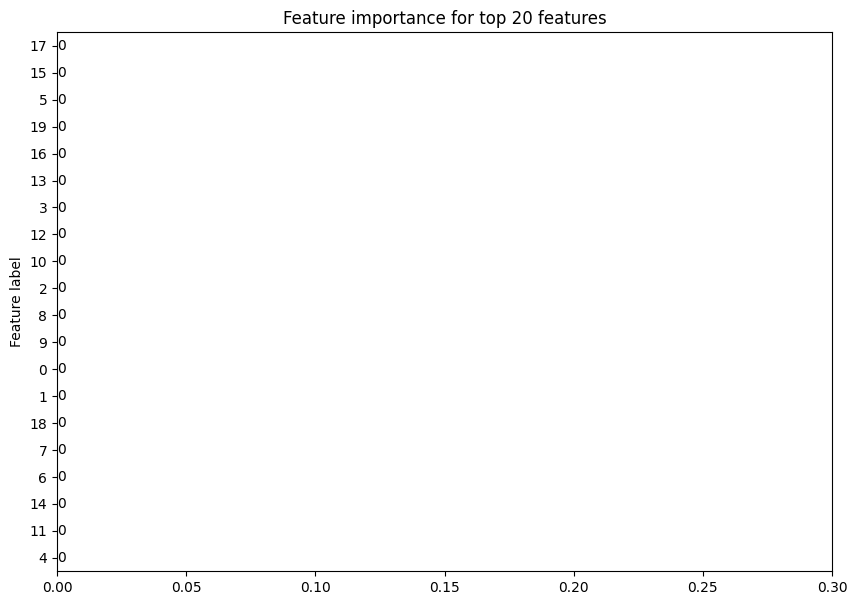

Explanation for graph idmL_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.0851e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


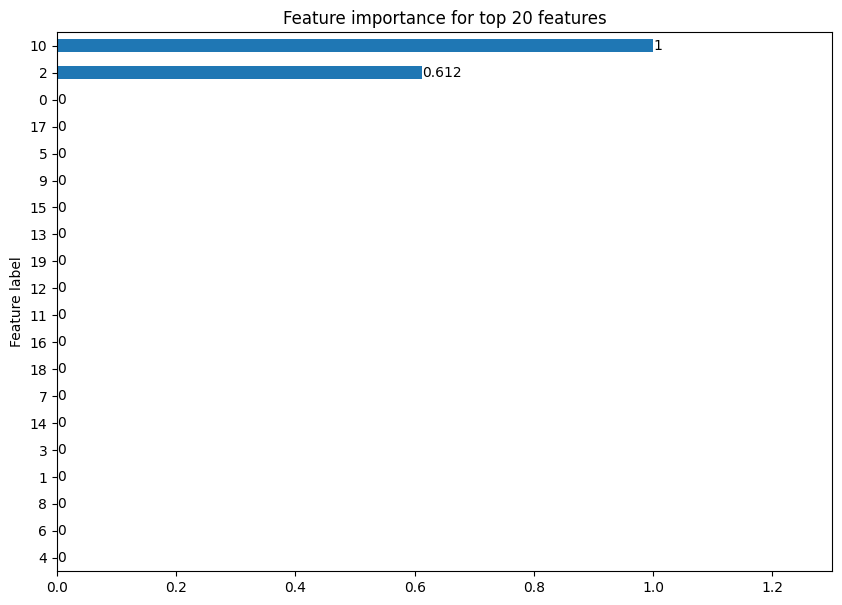

Explanation for graph sllA_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


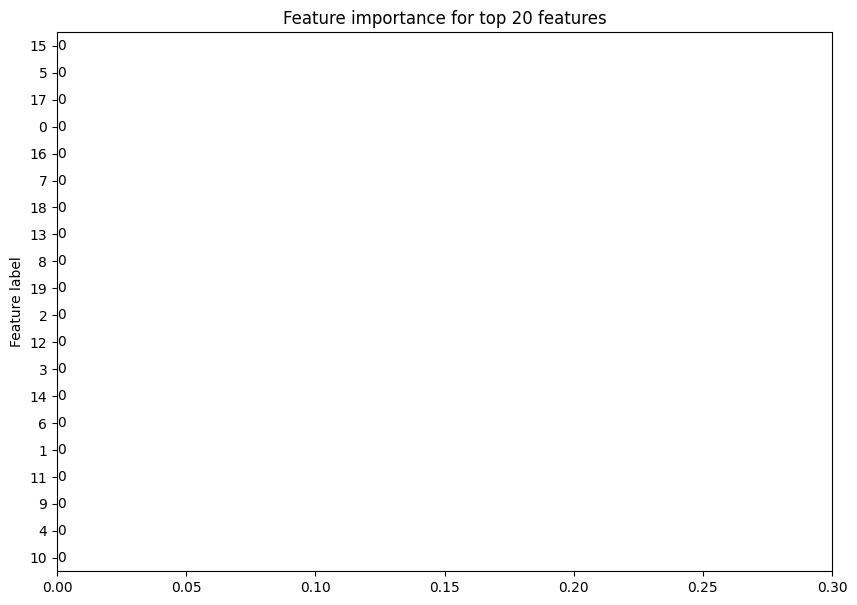

Explanation for graph borA4_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


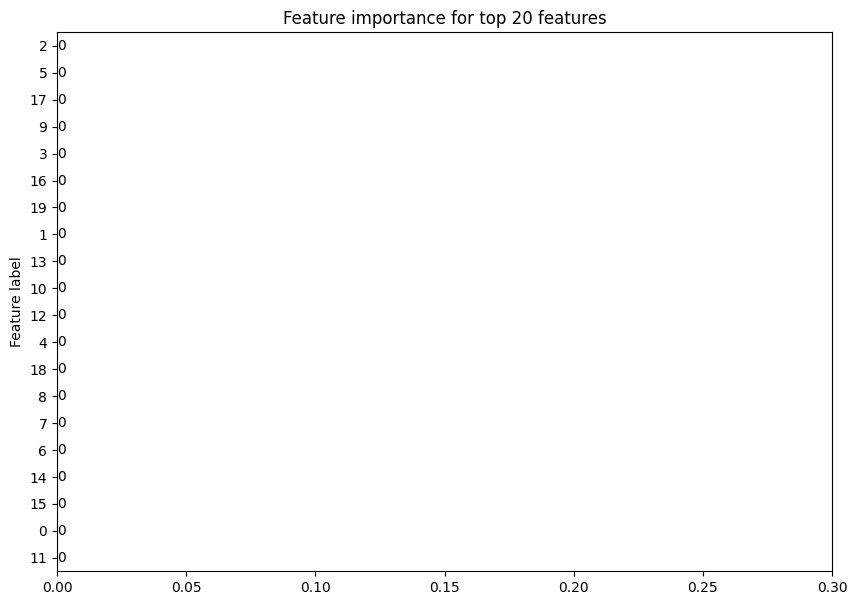

Explanation for graph TamAI_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.7375e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


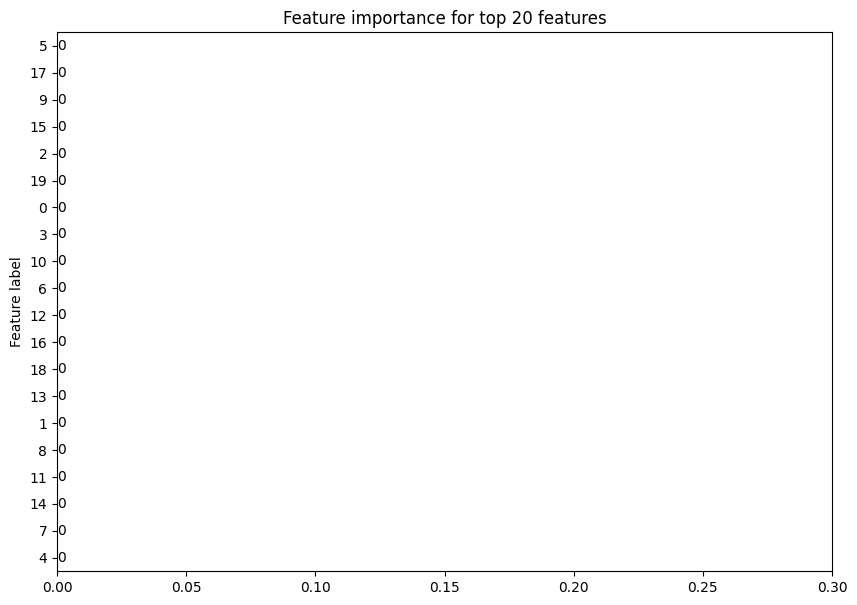

Explanation for graph fosB_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


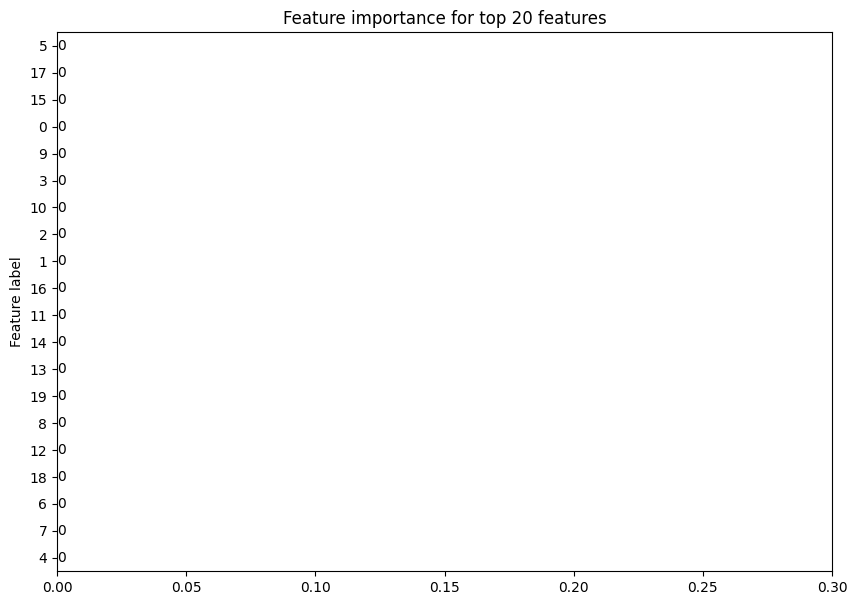

Explanation for graph cle3_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.3855e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


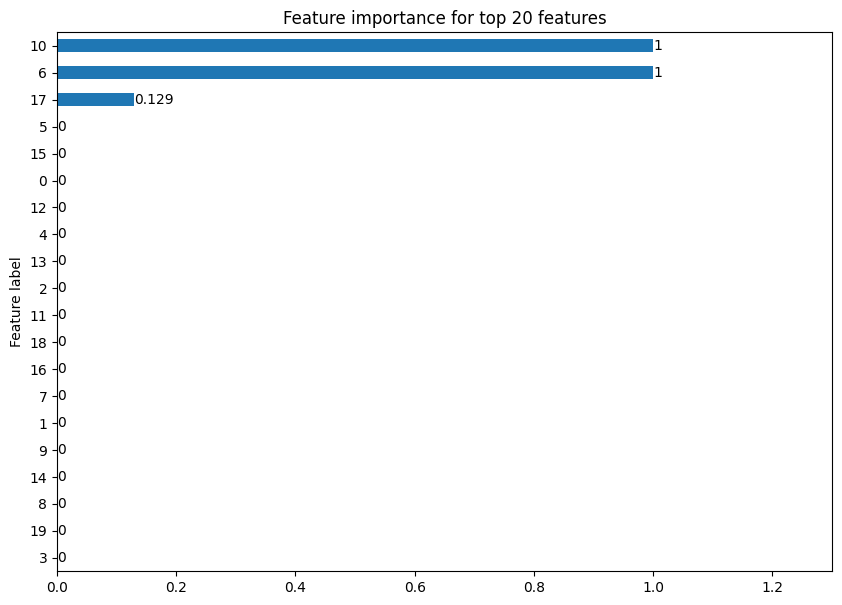

Explanation for graph sfaF_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.2598e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


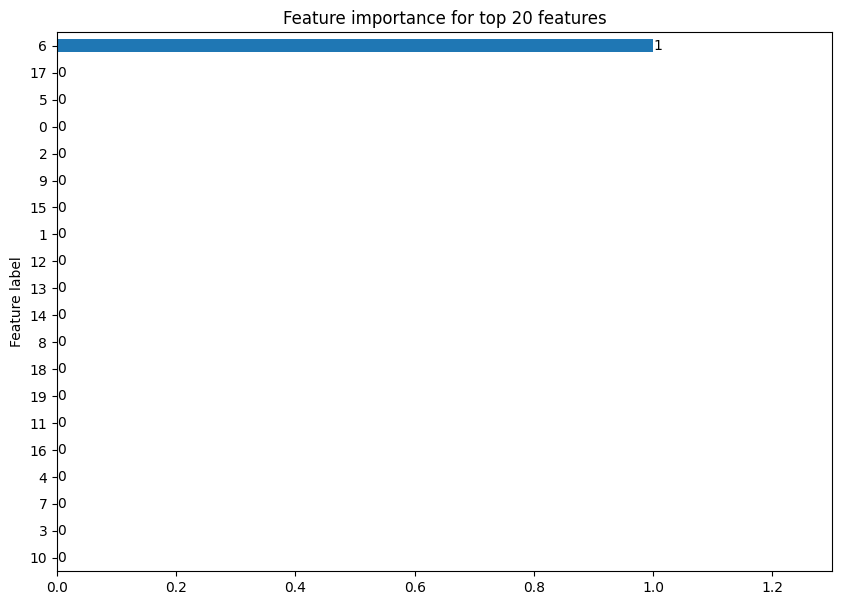

Explanation for graph aizH_mod.25.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


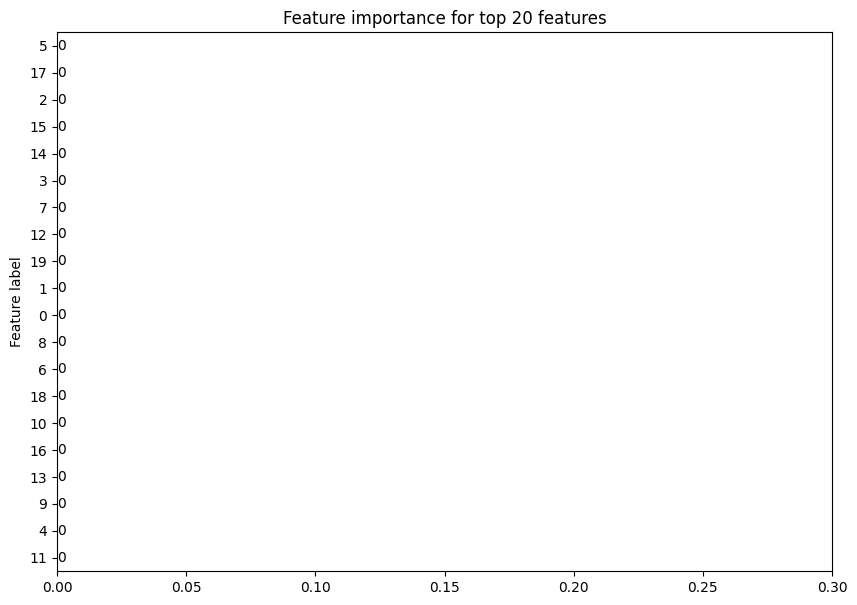

Explanation for graph ttmJ_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


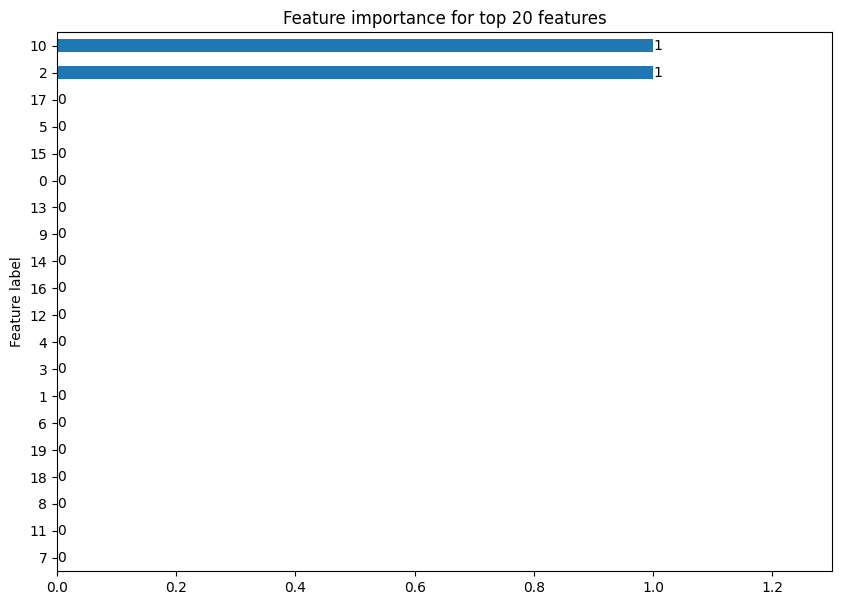

Explanation for graph epoF_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


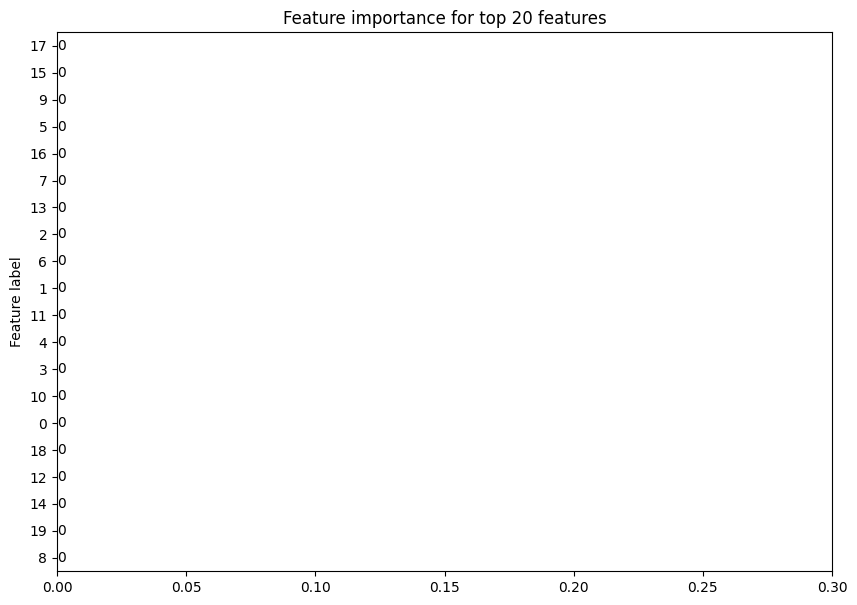

Explanation for graph aizA_mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


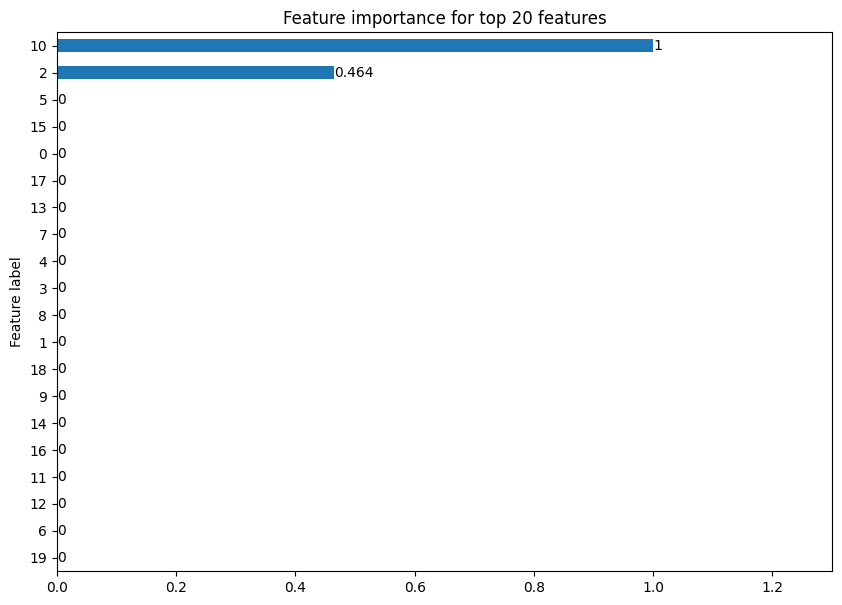

Explanation for graph selI_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


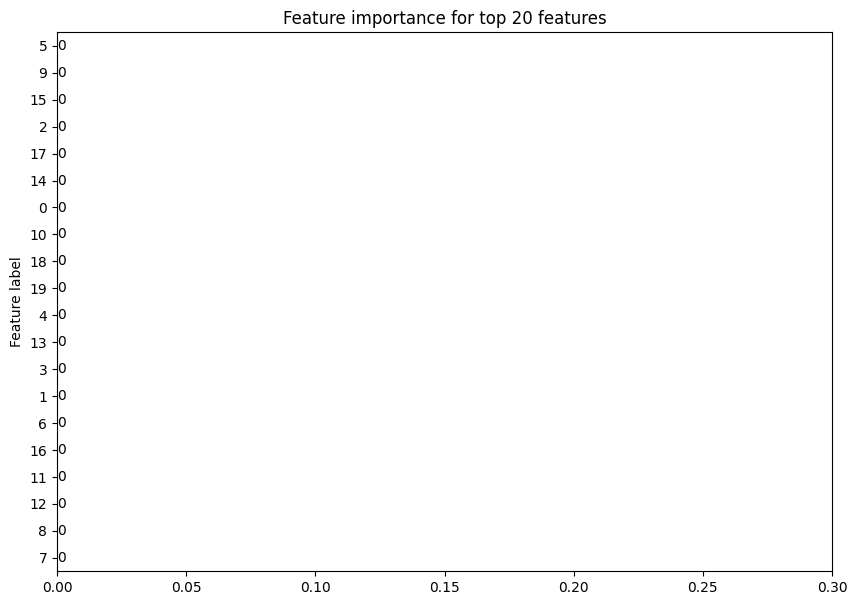

Explanation for graph sfaH_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


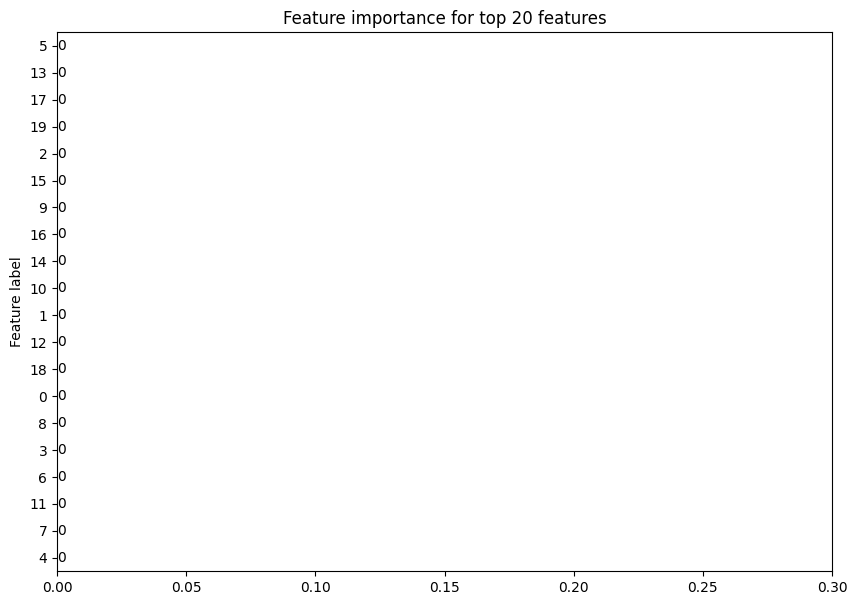

Explanation for graph meiA4_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


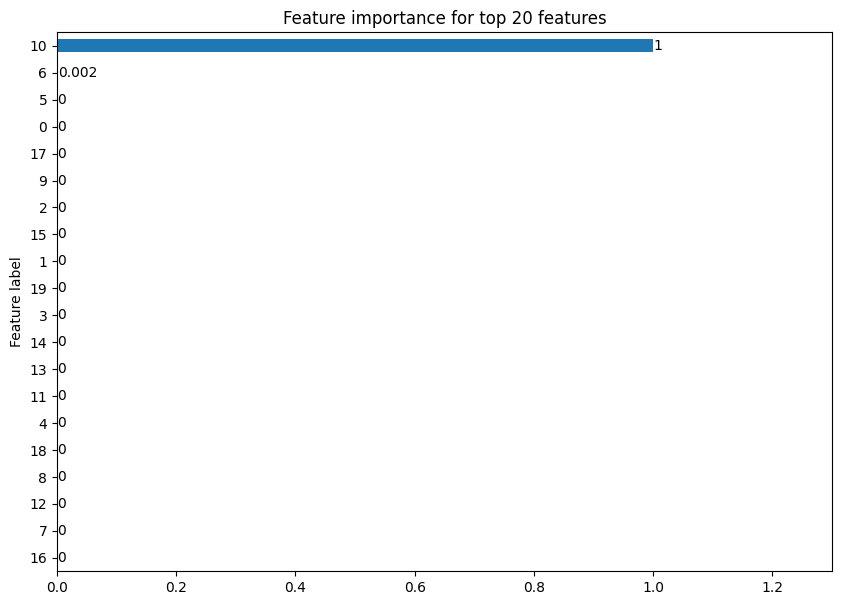

Explanation for graph chmGI_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


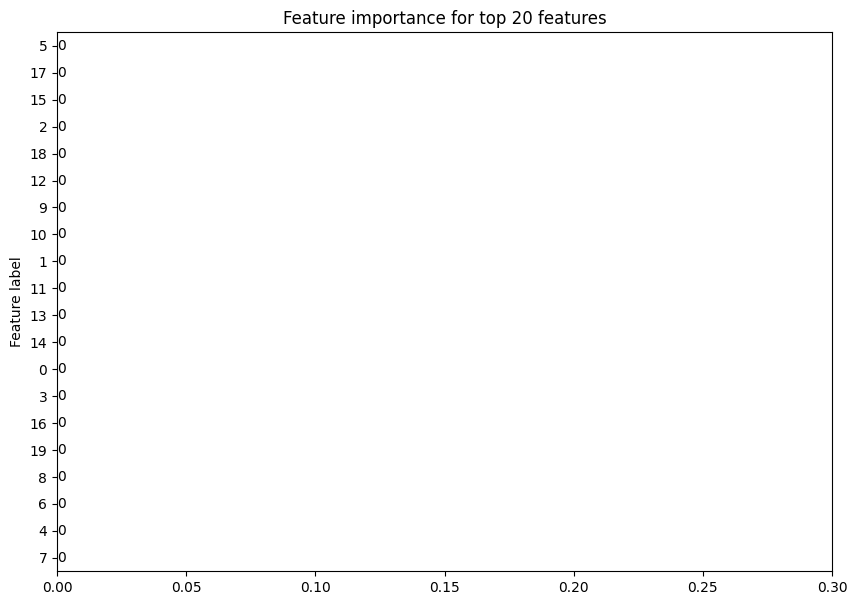

Explanation for graph palE_Mod.6.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


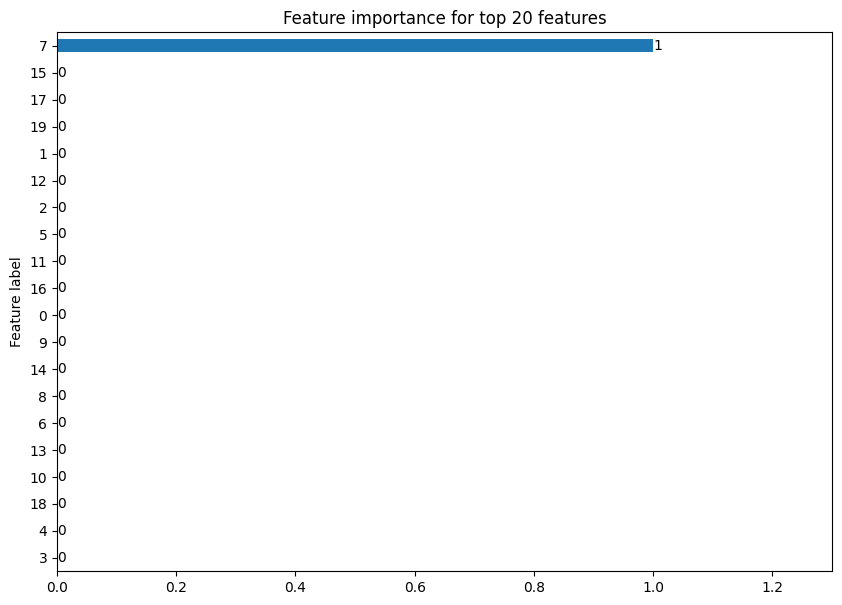

Explanation for graph cxmB_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


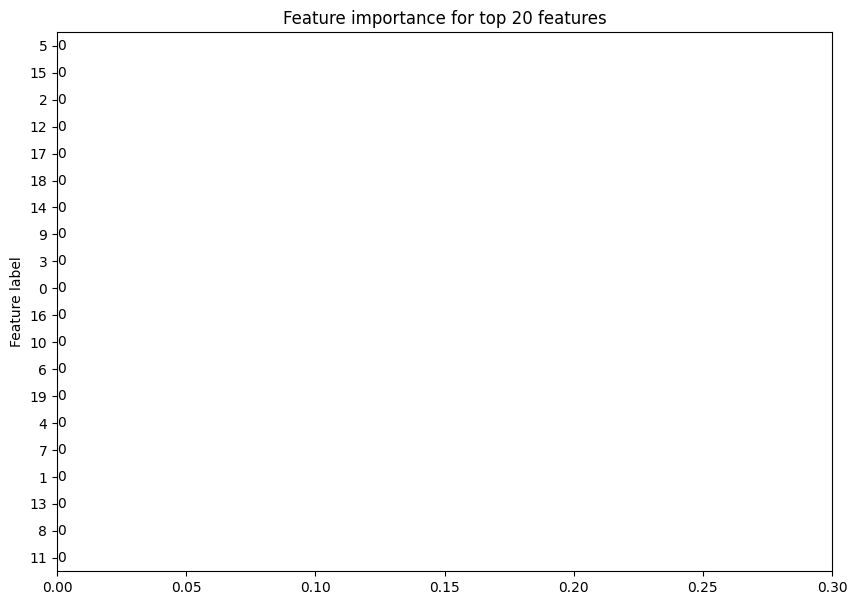

Explanation for graph azlE_Mod.8.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.5081e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


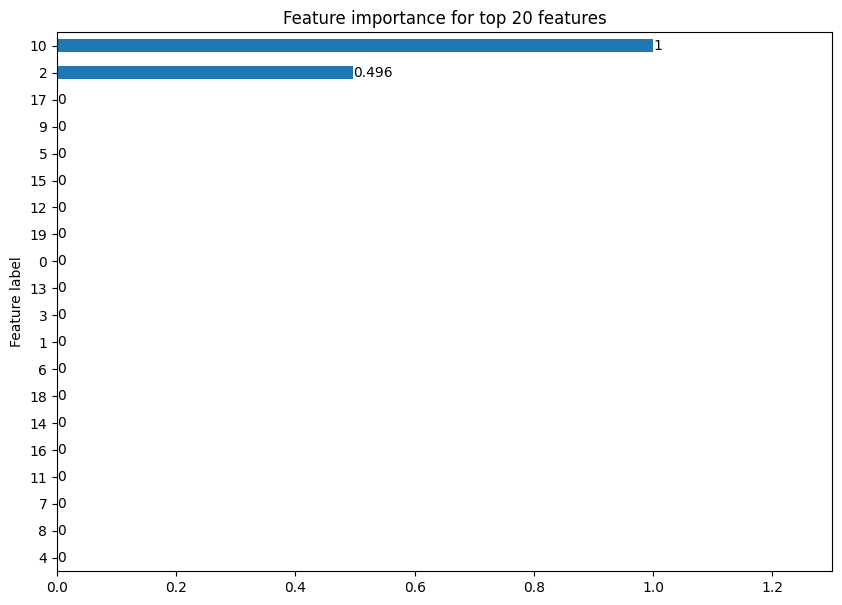

Explanation for graph borA3_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[3.6118e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


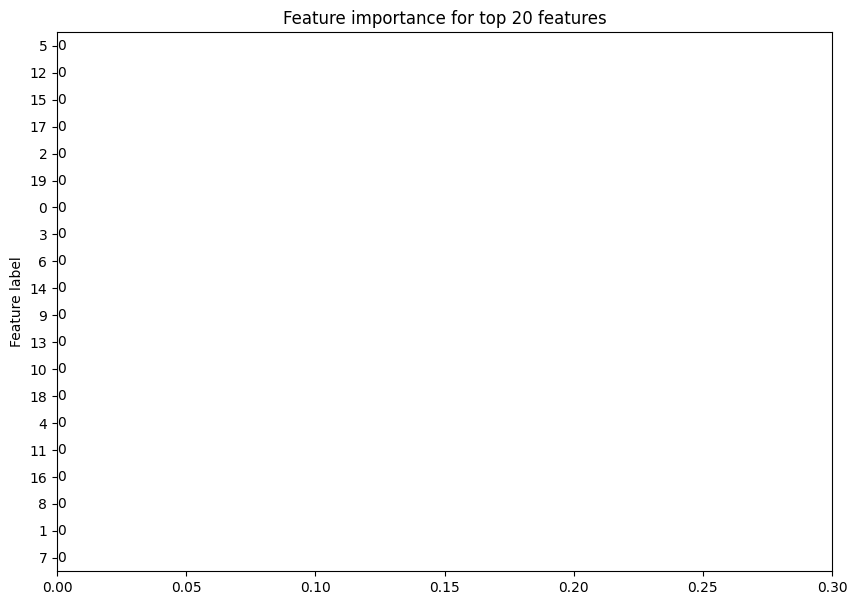

Explanation for graph mlsA1_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000, 0.0000, 0.0000,  ..., 0.7333, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


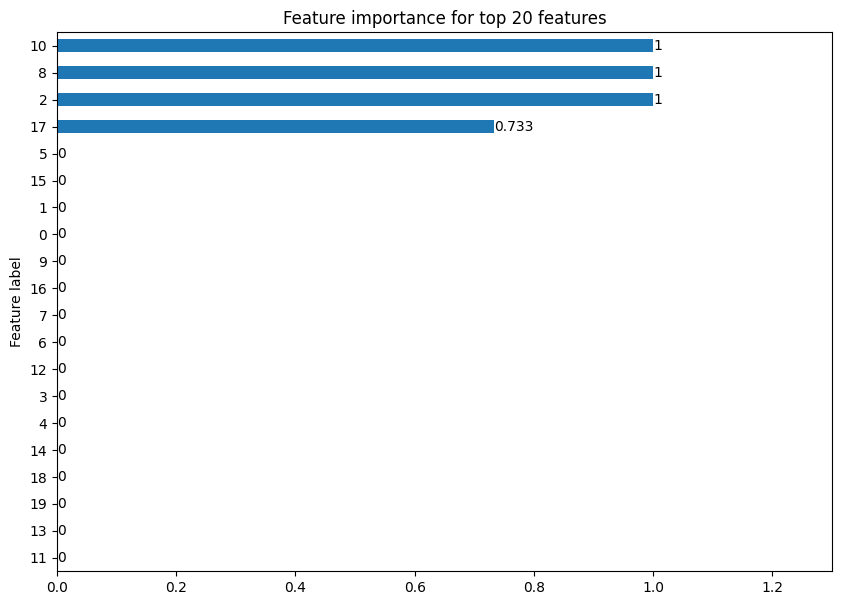

Explanation for graph scnS3_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


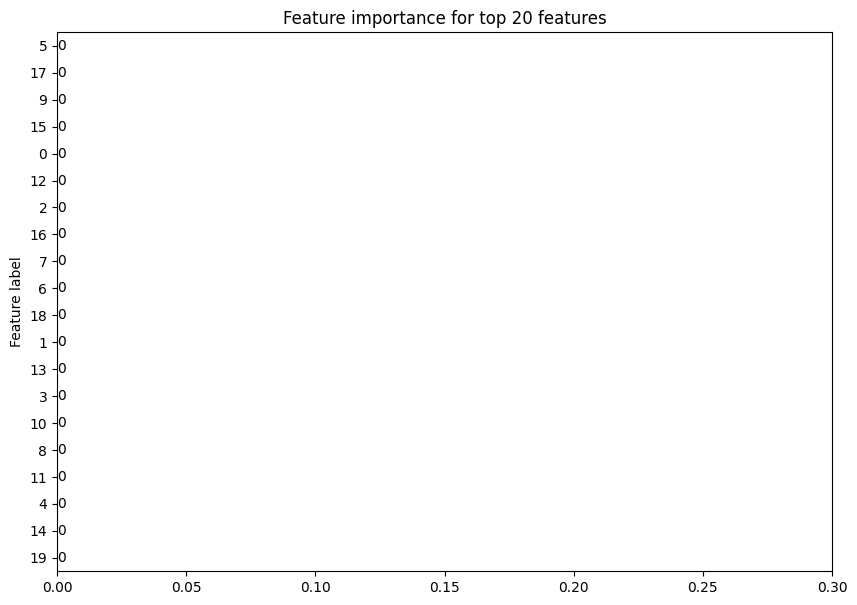

Explanation for graph palD_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


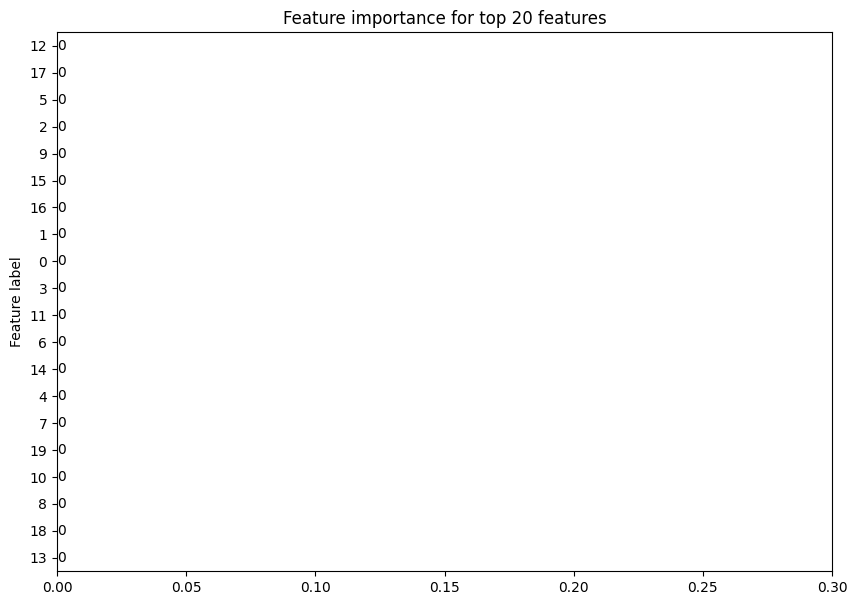

Explanation for graph selC_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


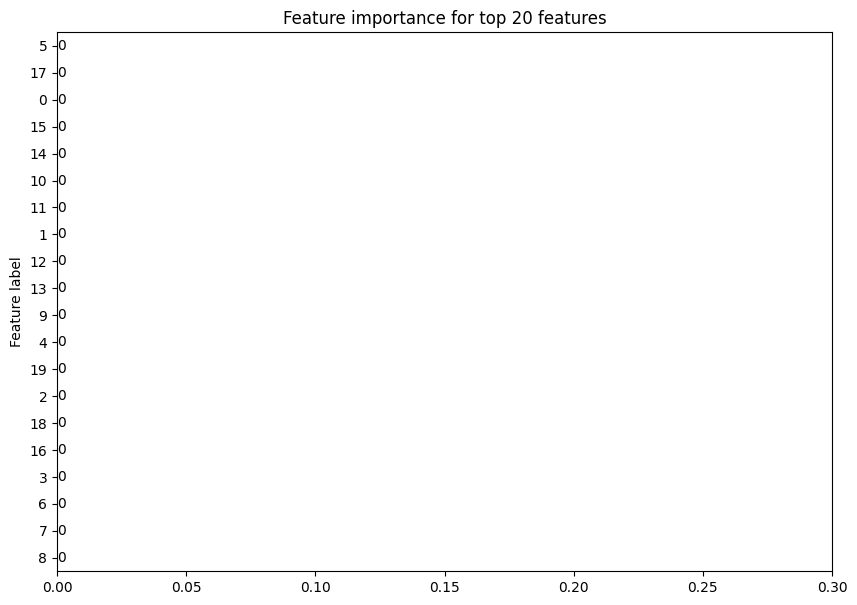

Explanation for graph natE_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.9094e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


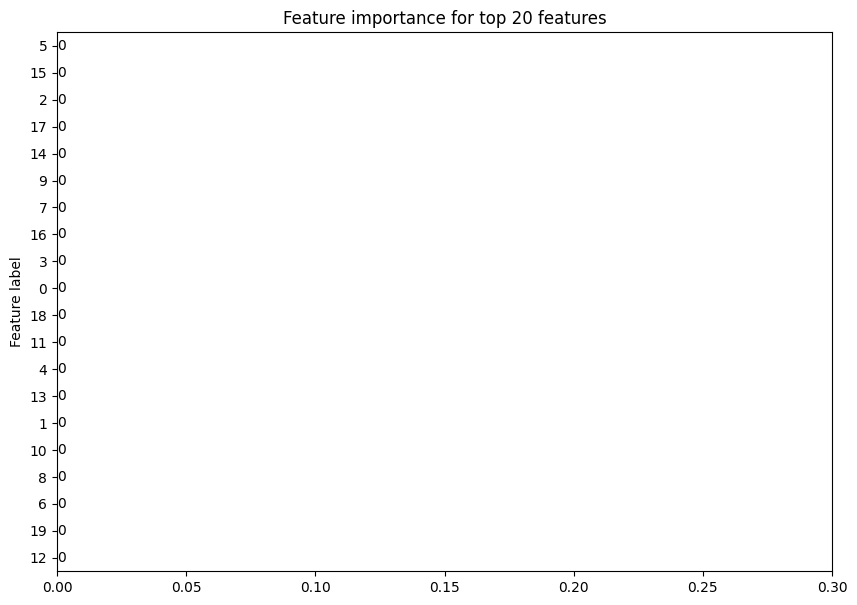

Explanation for graph fscB_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


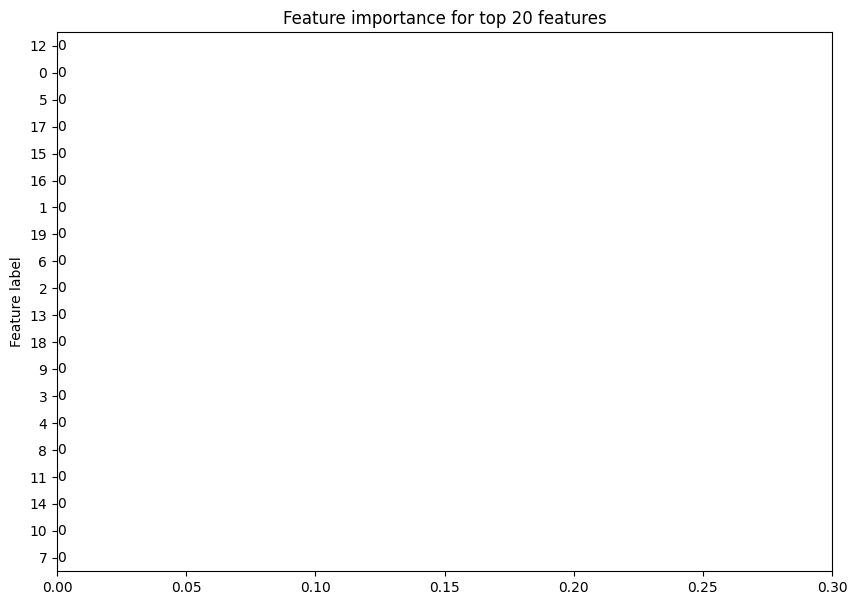

Explanation for graph StamG_Mod.18.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[3.5388e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


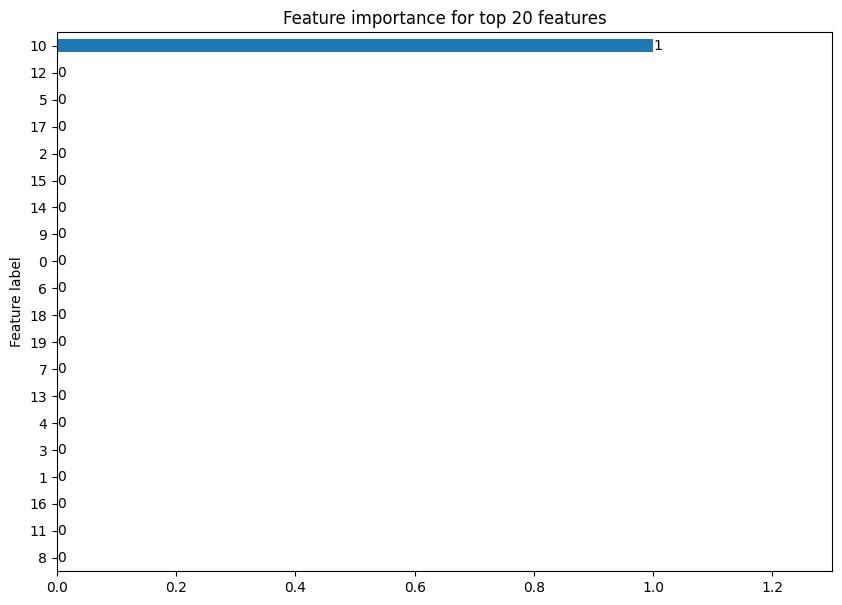

Explanation for graph gfsB_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


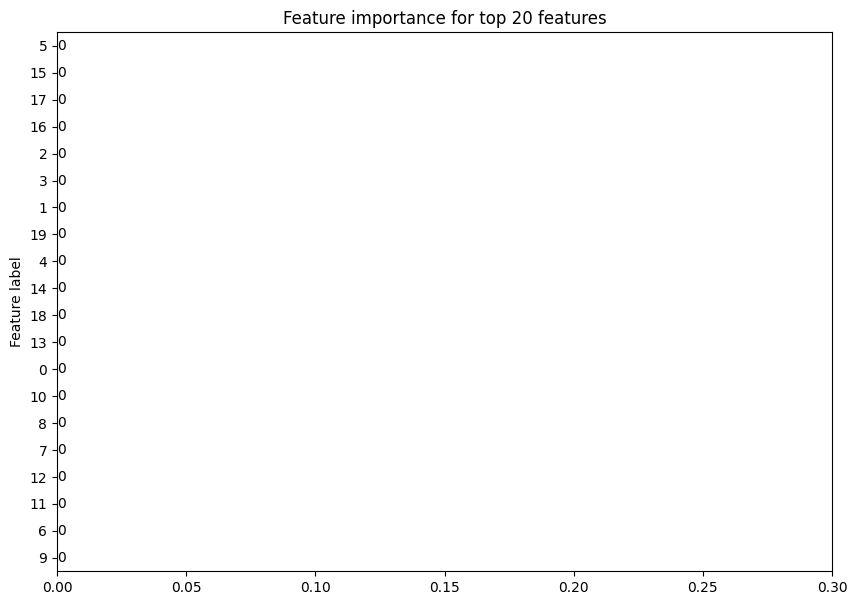

Explanation for graph cxmC_Mod.8.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


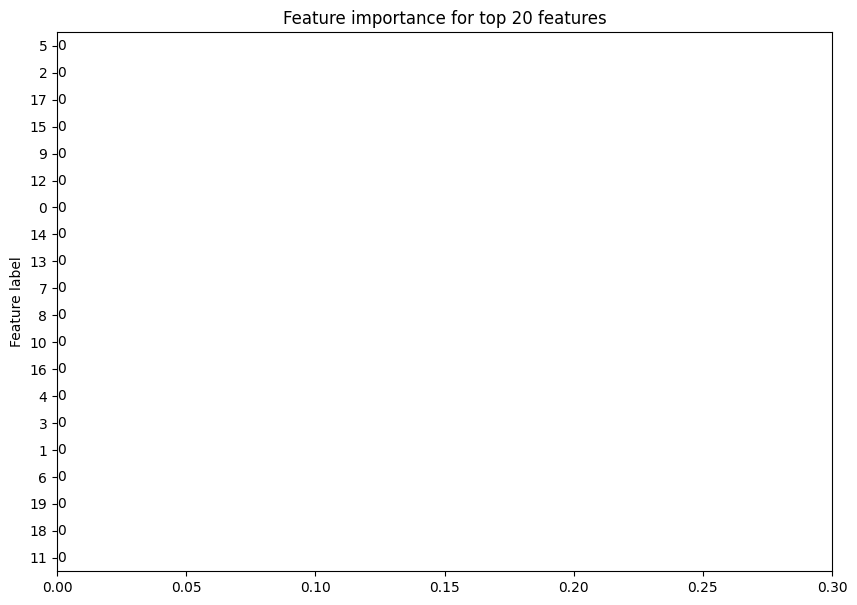

Explanation for graph kijA_Mod.8.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.4340e-10, 0.0000e+00,
         0.0000e+00],
        [3.4336e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


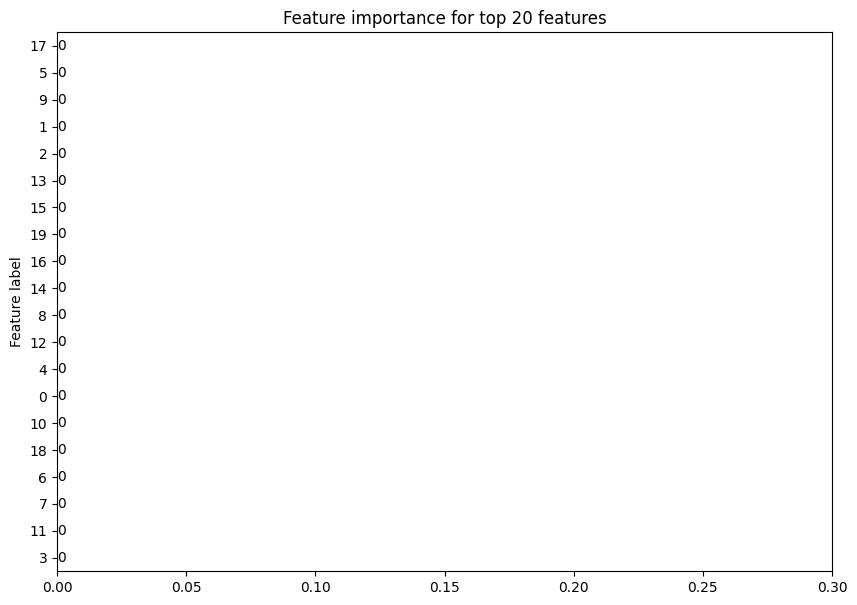

Explanation for graph aizD_mod.14.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.7352e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


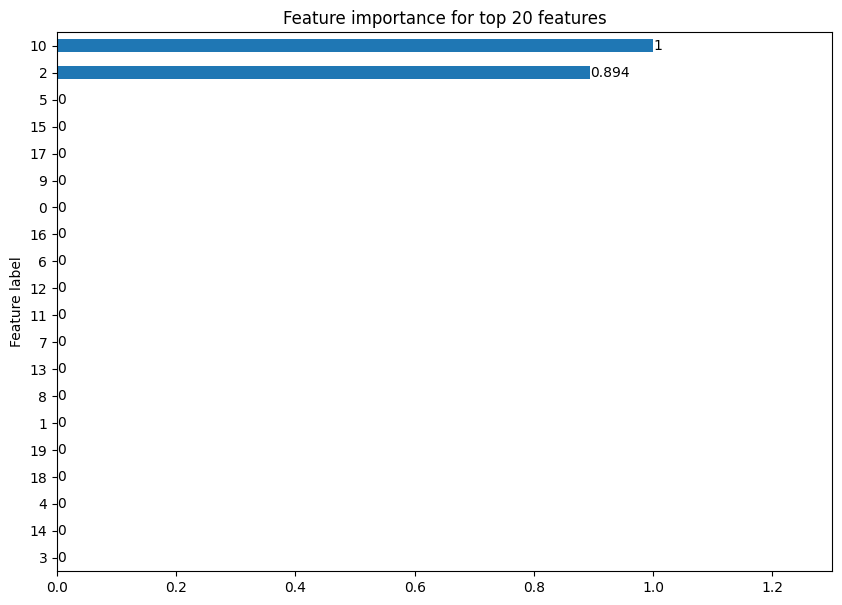

Explanation for graph merC_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.6062e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


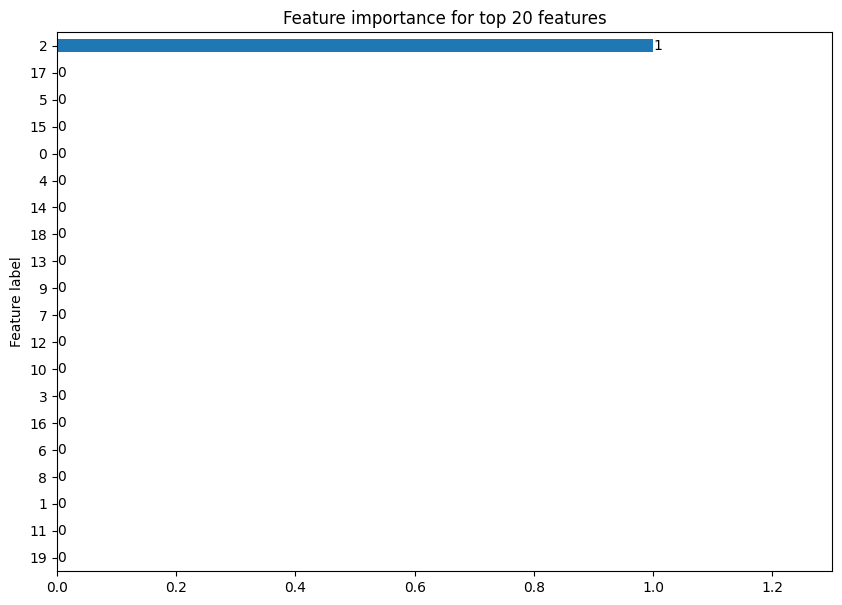

Explanation for graph almHII_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


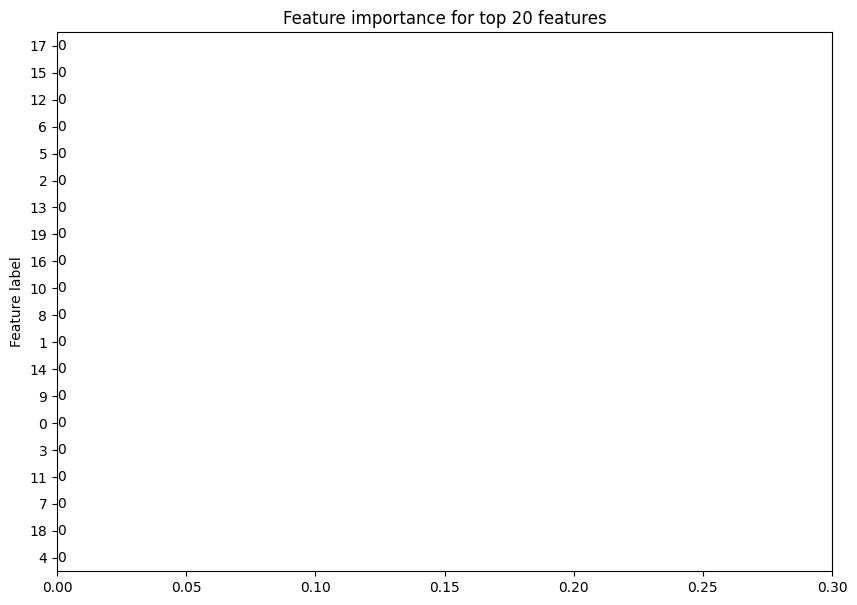

Processing batch with 12 graphs
Explanation for graph asmB_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.2159e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


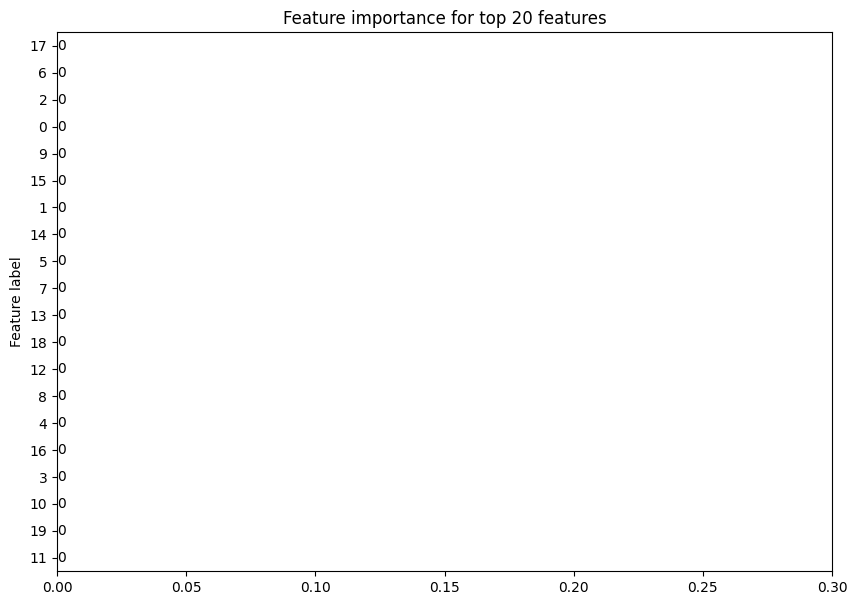

Explanation for graph gfsD_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


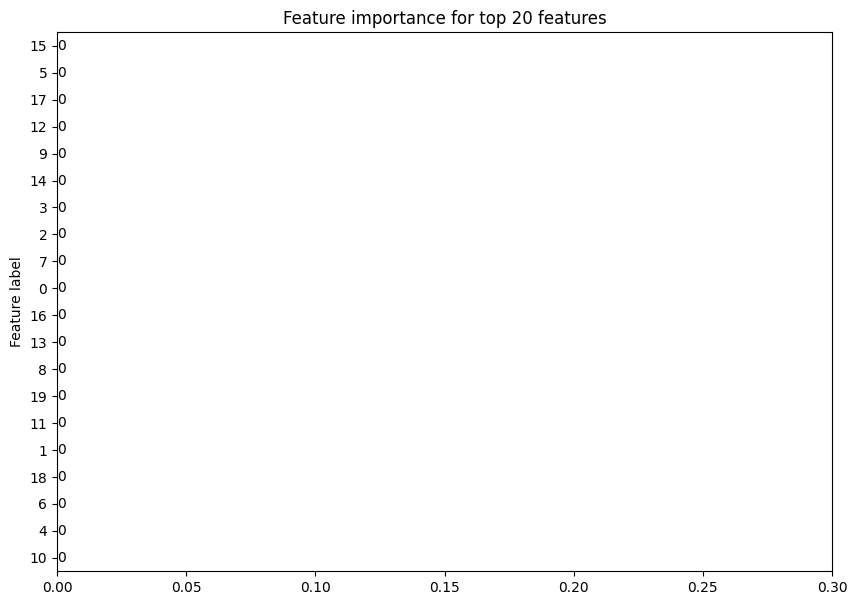

Explanation for graph selJ_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.4354e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


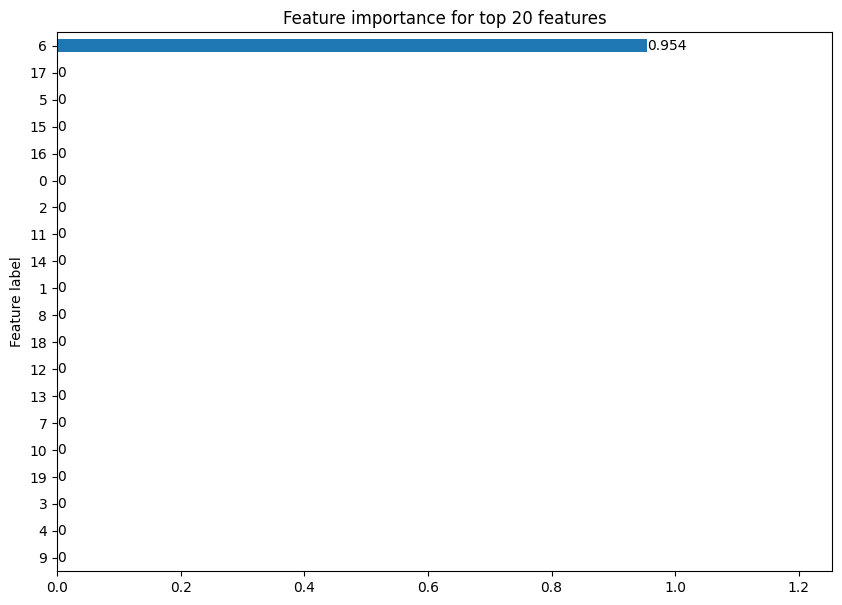

Explanation for graph pteA2_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.2559e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


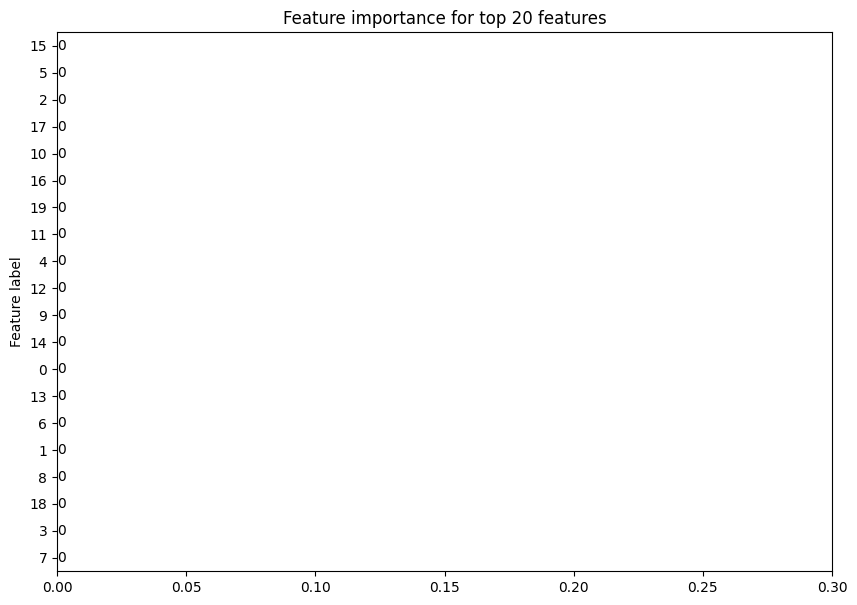

Explanation for graph gerSI_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


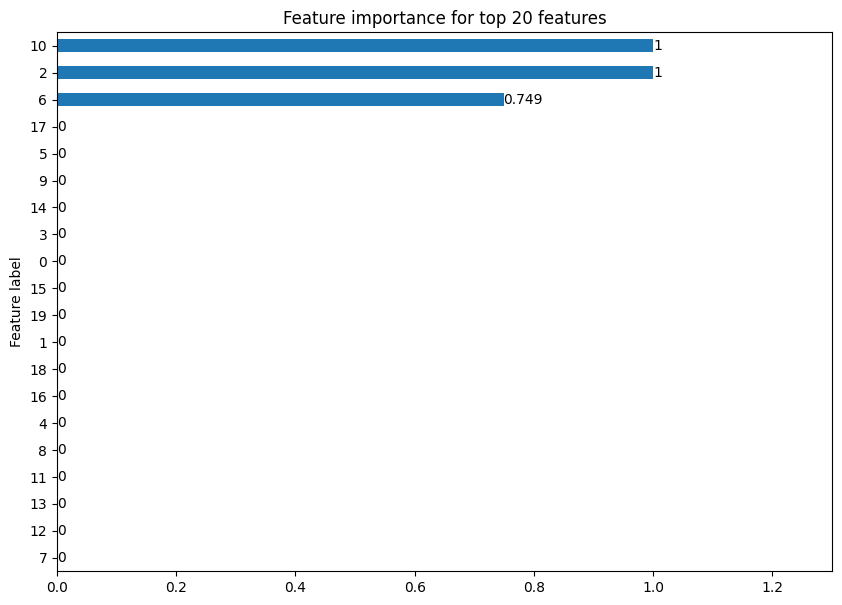

Explanation for graph pikAII_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0015e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


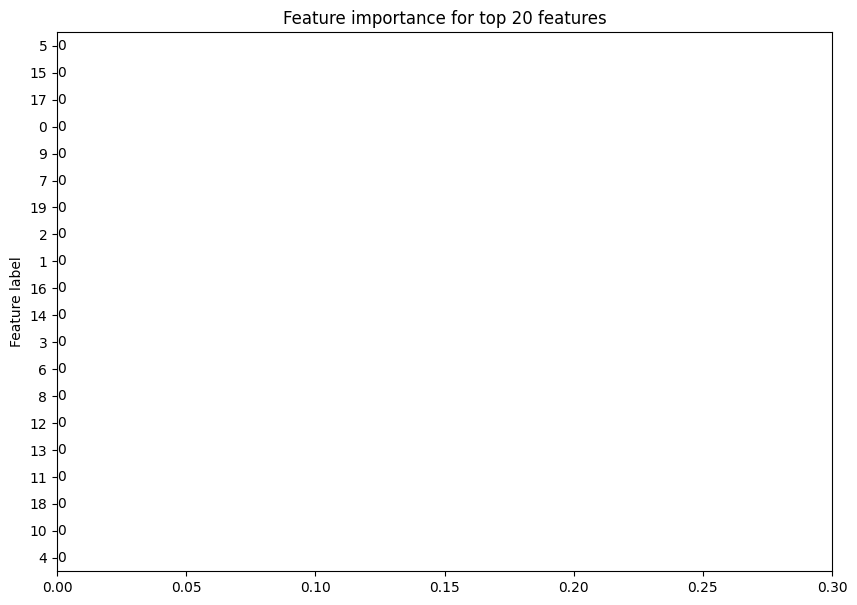

Explanation for graph gfsA_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.3927e-10, 0.0000e+00,
         0.0000e+00],
        [3.3915e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


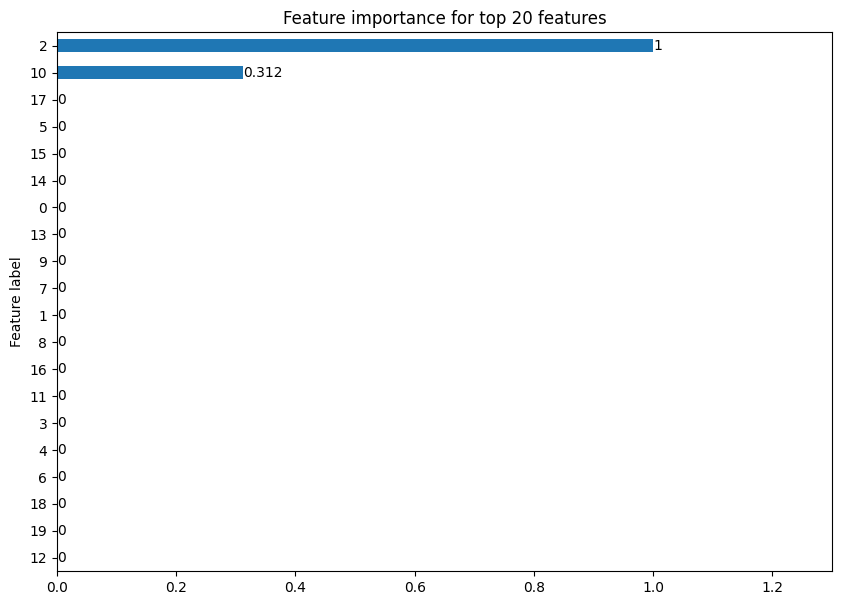

Explanation for graph monAIII_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.2157e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


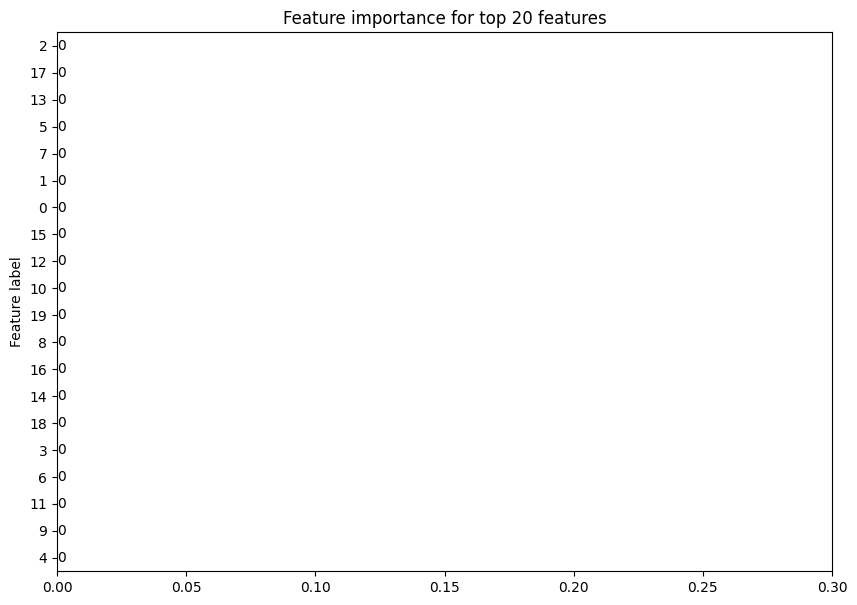

Explanation for graph fscE_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.6511e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


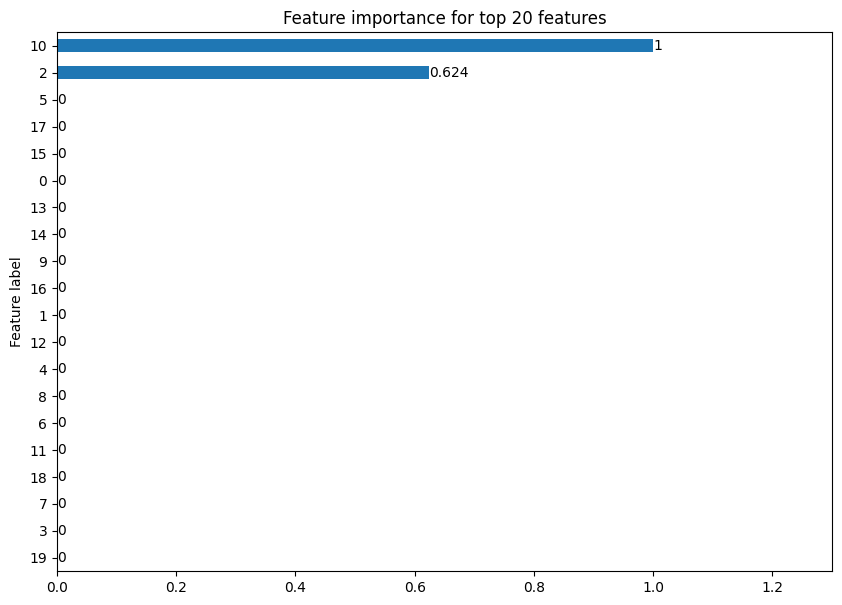

Explanation for graph hgcB_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


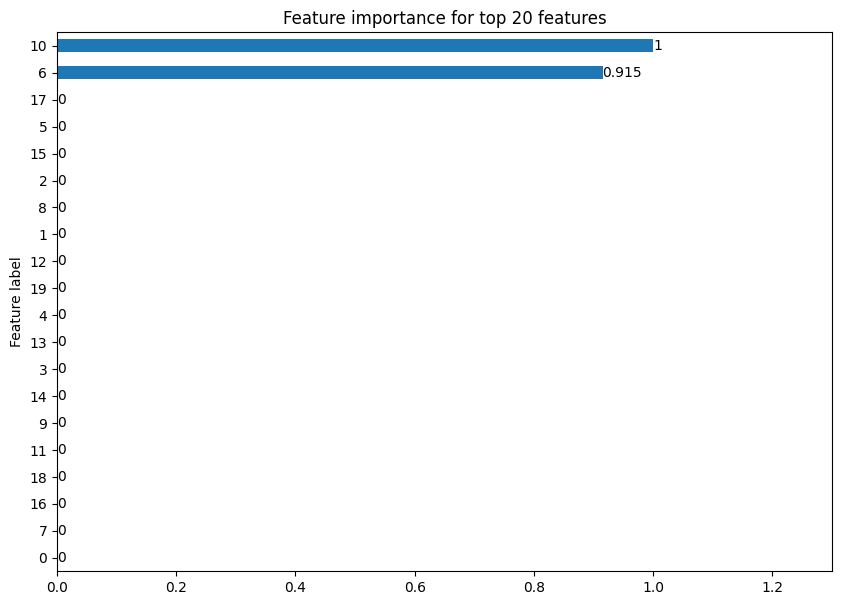

Explanation for graph lobA3_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0429e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


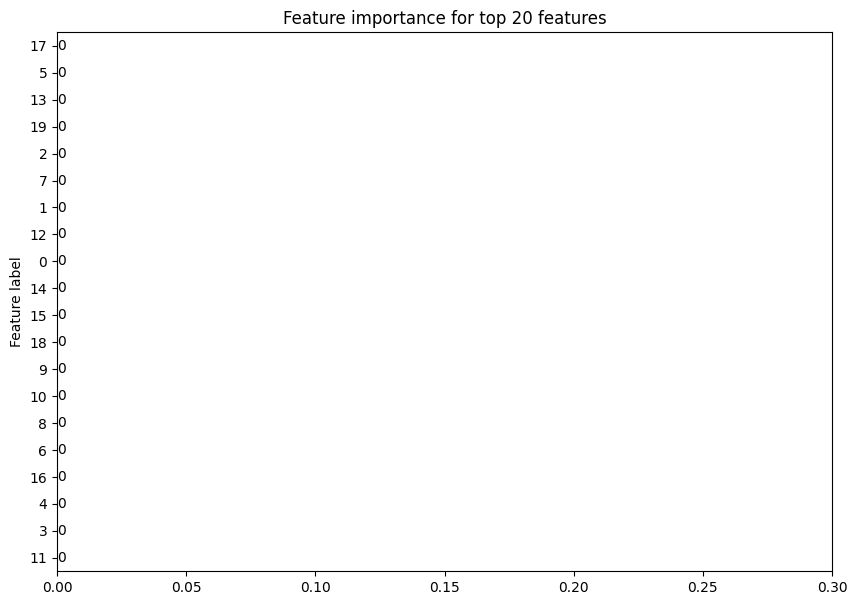

Explanation for graph rifA_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


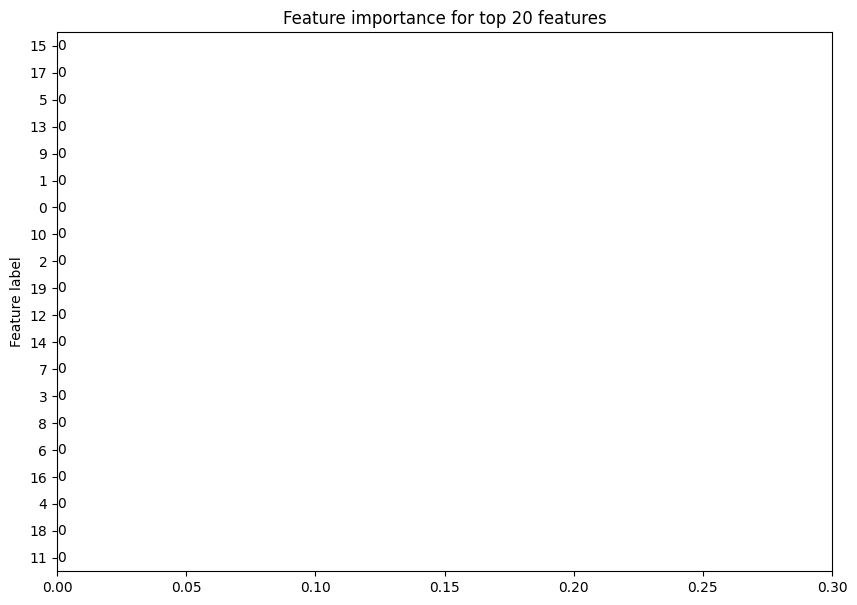

In [9]:
### Explainer loop ### 
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
import torch

import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
import pandas as pd
# Specify the folder where you want to save the output files
output_folder = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20240325_binaryclass_KS_dimers_KRandDHonly_graphViz2_val_singlenuerallayer/"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through your loader
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100000),
    explanation_type='phenomenon', # options are model (describes the model) or phenomenon (describes why descision was made for input and input label)
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw', 
    ),
)
# Iterate through your loader
loader = test_loader
for batch in loader:
    # Print some information about the current batch
    print(f"Processing batch with {batch.num_graphs} graphs")

    # Generate explanation for each graph in the batch
    for i in range(batch.num_graphs):
        # Extract data for the i-th graph in the batch
        graph_data = batch[i]

        # Create a new Data object
        data = Data(
            edge_index=graph_data.edge_index,
            node_id=graph_data.node_id,
            coords=graph_data.coords,
            name=graph_data.name,
            num_nodes=graph_data.num_nodes,
            x=graph_data.x.view(len(graph_data.node_id), 20),
        )

        # Extract the graph-level label for the current graph
        target_values = graph_data.graph_y.tolist()
        target = torch.tensor(target_values).float()

        # Generate explanation for the node at index `10`:
        explanation = explainer(x=data.x, edge_index=data.edge_index, batch=data.batch, target=target)

        # Print or do something with the explanation for the current graph
        print(f"Explanation for graph {graph_data.name}:", explanation.edge_mask, explanation.node_mask)

        # Optionally, you can visualize the feature importance for each graph
        explanation.visualize_feature_importance(top_k=20)

        # Save the output of visualize_graph to a file in the specified folder
        graphviz_output = explanation.visualize_graph(path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"), backend="graphviz")
        
# Iterate through your loader
#loader = val_loader
#for batch in loader:
    # Print some information about the current batch
#    print(f"Processing batch with {batch.num_graphs} graphs")

    # Generate explanation for each graph in the batch
 #   for i in range(batch.num_graphs):
  #      # Extract data for the i-th graph in the batch
   #     graph_data = batch[i]
#
 #       # Create a new Data object
  #      data = Data(
   #         edge_index=graph_data.edge_index,
    #        node_id=graph_data.node_id,
     #       coords=graph_data.coords,
      #      name=graph_data.name,
#            num_nodes=graph_data.num_nodes,
 #           x=graph_data.x.view(len(graph_data.node_id), 20),
  #      )
#
 #       # Extract the graph-level label for the current graph
  #      target_values = graph_data.graph_y.tolist()
   #     target = torch.tensor(target_values).float()
#
 ##       # Generate explanation for the node at index `10`:
   #     explanation = explainer(x=data.x, edge_index=data.edge_index, batch=data.batch, target=target)
#
 #       # Print or do something with the explanation for the current graph
  #      print(f"Explanation for graph {graph_data.name}:", explanation.edge_mask, explanation.node_mask)
#
 #       # Optionally, you can visualize the feature importance for each graph
 #       explanation.visualize_feature_importance(top_k=20)
#
 #       # Save the output of visualize_graph to a file in the specified folder
  #      graphviz_output = explanation.visualize_graph(path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"), backend="graphviz")
#

In [ ]:
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_max_pool
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set seed
torch.manual_seed(15706112877486103401)

# Network parameters
input_dim = 20  # Corresponds to amino acid OHE
hidden_dim = 64  # Neural network density
hidden_dim2 = 8  # Neural network density
output_dim = 2   # Set model to binary classification

# Hyperparameters
num_epochs = 100
learning_rate = 0.001

# Define a GNN model with GraphSAGEConv layers
class MyGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim2, output_dim):
        super(MyGNN, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim2)
        self.lin = Linear(hidden_dim2, output_dim)

    def forward(self, x, edge_index, batch):
        # Convert input tensor 'x' to Float data type
        x = x.float()
        
        # Apply the first GraphSAGEConv layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
    
        # Apply the second GraphSAGEConv layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
    
        # Perform graph-level pooling (e.g., global max pooling)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        x = F.softmax(x, dim=1) 
    
        return x

# Initialize your GNN model
model = MyGNN(input_dim, hidden_dim, hidden_dim2, output_dim)

# Define batching
batch = next(iter(train_loader))
print(batch)

# Forward pass through the model
out = model(batch.x, batch.edge_index, batch.batch)

# Define optimization method
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Empty containers for loss and accuracy metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

## Training and validation loops ##
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0
    
    # Training loop
    model.train()
    train_correct_count = 0  # Total number of correct predictions for the epoch
    train_total_count = 0    # Total number of samples for the epoch
    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Compute loss
        loss = F.cross_entropy(out, labels, reduction='sum')
        epoch_train_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        predicted_labels = out.argmax(dim=1)
        train_correct_count += (predicted_labels == labels).sum().item()
        train_total_count += labels.size(0)
    
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # Calculate training accuracy
    train_accuracy = train_correct_count / train_total_count
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    total_correct_val = 0
    total_samples_val = 0
    val_predictions = []  # New list to store predictions
    val_labels_all = []    # New list to store true labels
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
    
            labels = (batch.graph_y[:, 0] == 1).long()
    
            loss = F.cross_entropy(out, labels, reduction='sum')
            val_loss += loss.item()
    
            predicted_labels = out.argmax(dim=1)
            total_correct_val += (predicted_labels == labels).sum().item()
            total_samples_val += labels.size(0)
    
            # Store predictions and true labels for each batch
            val_predictions.extend(predicted_labels.cpu().numpy())
            val_labels_all.extend(labels.cpu().numpy())
    
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    
    # Calculate overall validation accuracy using all true labels
    val_accuracy = total_correct_val / total_samples_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")

# Plotting the training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train accuracy', color='blue')
plt.plot(val_accuracies, label='Validation accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished!")

### Test data ###
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score

# Assuming you have your test data in a DataLoader called test_loader
# If you don't have one, create it similarly to how you created train_loader and val_loader.

# Set the model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
total_correct_test = 0
total_samples_test = 0

# Lists to store predictions and true labels for potential further analysis
test_predictions = []
test_labels = []

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)  # Send data to GPU if available
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()  # Corrected line
        
        # Calculate predictions
        predicted_labels = out.argmax(dim=1)
        
        # Accumulate the number of correct predictions and total samples
        total_correct_test += (predicted_labels == labels).sum().item()
        total_samples_test += labels.size(0)

        # Store predictions and true labels
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)

# Report the test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")


DataBatch(x=[54244, 20], edge_index=[2, 124701], node_id=[64], coords=[54244, 3], name=[64], num_nodes=54244, graph_y=[64, 2], batch=[54244], ptr=[65])
Epoch [1/100] - Train Loss: 0.6922 - Train Accuracy: 0.5367 - Validation Loss: 0.6927 - Validation Accuracy: 0.5263
Epoch [2/100] - Train Loss: 0.6910 - Train Accuracy: 0.5517 - Validation Loss: 0.6923 - Validation Accuracy: 0.5263
Epoch [3/100] - Train Loss: 0.6894 - Train Accuracy: 0.6000 - Validation Loss: 0.6917 - Validation Accuracy: 0.5395
Epoch [4/100] - Train Loss: 0.6881 - Train Accuracy: 0.6100 - Validation Loss: 0.6912 - Validation Accuracy: 0.5395
Epoch [5/100] - Train Loss: 0.6869 - Train Accuracy: 0.6350 - Validation Loss: 0.6906 - Validation Accuracy: 0.5789
Epoch [6/100] - Train Loss: 0.6857 - Train Accuracy: 0.6433 - Validation Loss: 0.6901 - Validation Accuracy: 0.5658
Epoch [7/100] - Train Loss: 0.6839 - Train Accuracy: 0.6517 - Validation Loss: 0.6892 - Validation Accuracy: 0.5921
Epoch [8/100] - Train Loss: 0.6821 -

Processing batch with 64 graphs
Explanation for graph ncdB_Mod.6.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


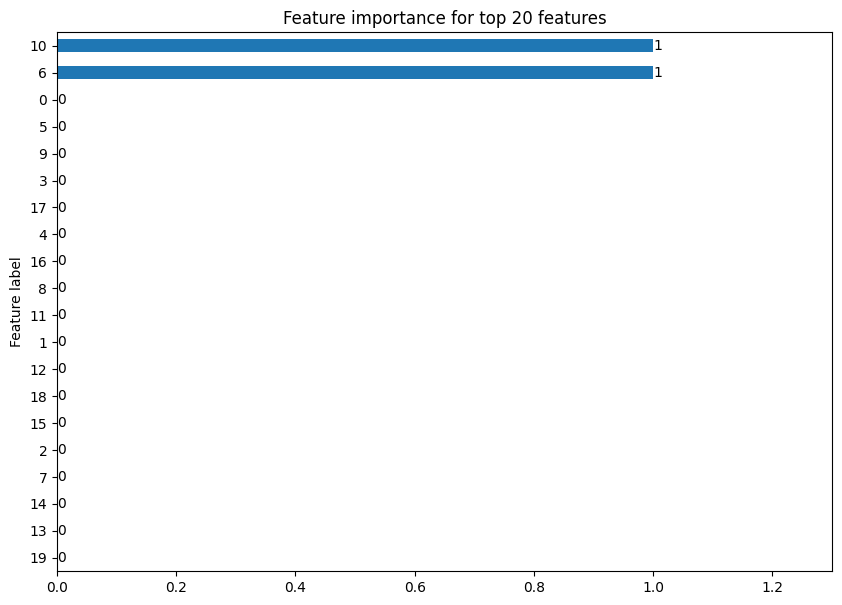

Explanation for graph fscC_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


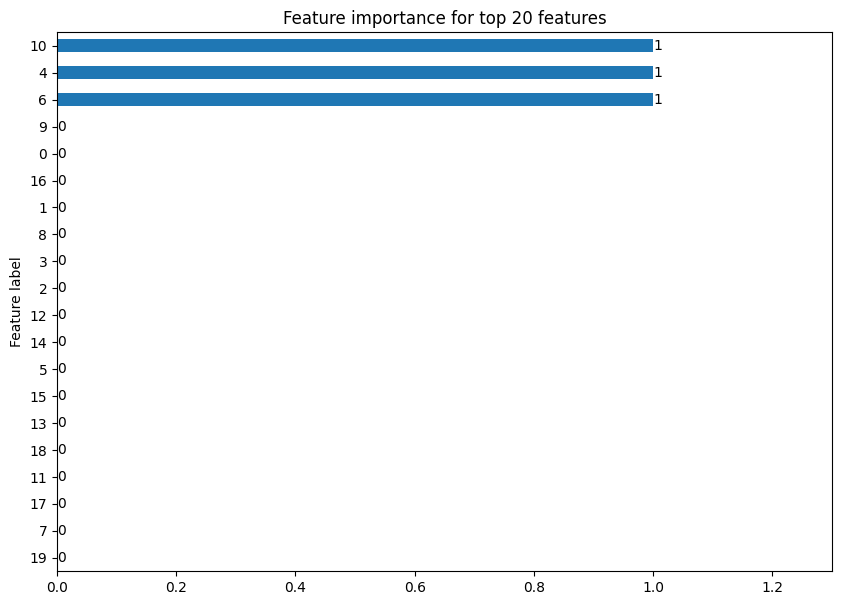

Explanation for graph leoD_Mod.7.pdb_aligned: tensor([0., 0., 1.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.5333e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


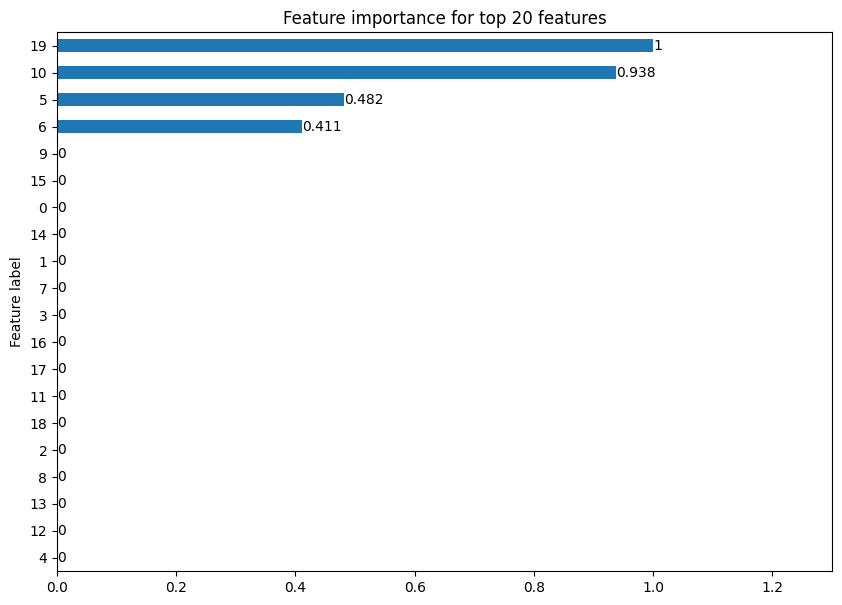

Explanation for graph fscD_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


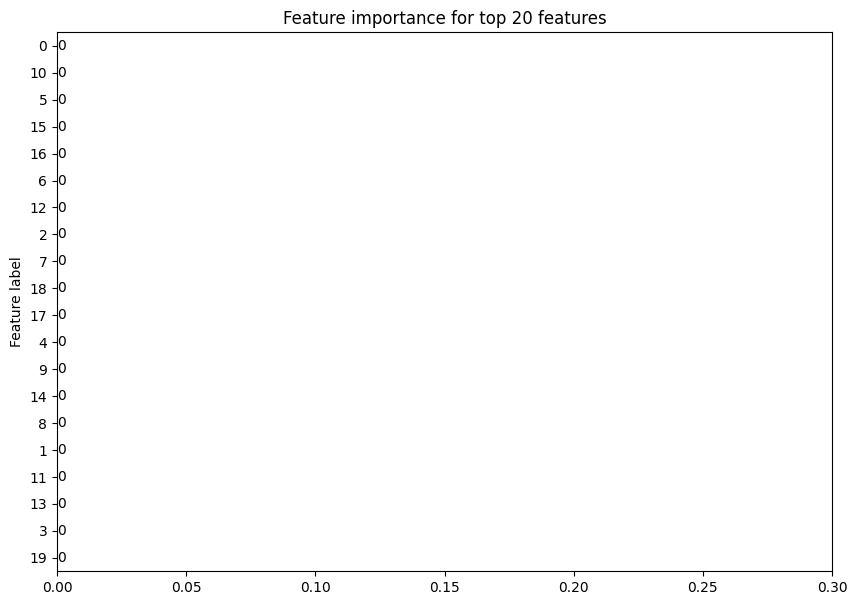

Explanation for graph nidA1_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


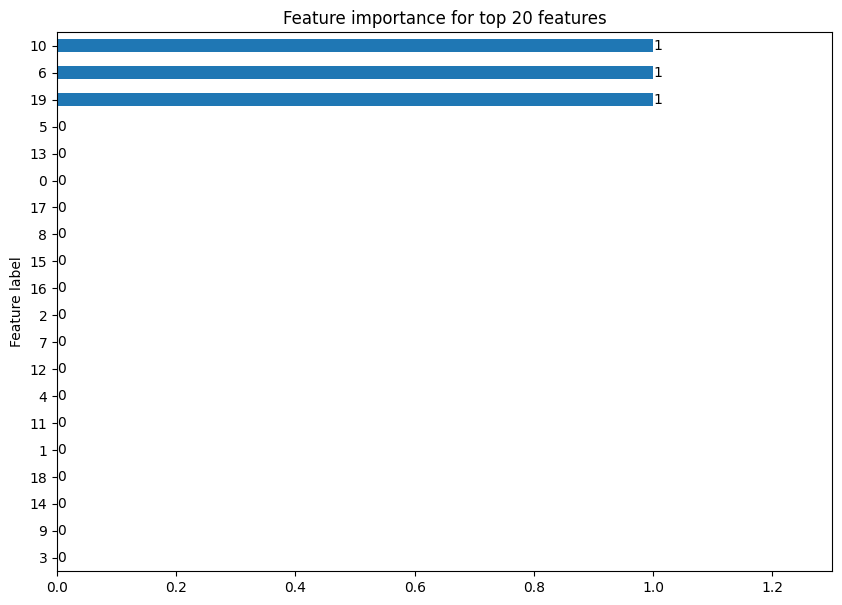

Explanation for graph SgnS2_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


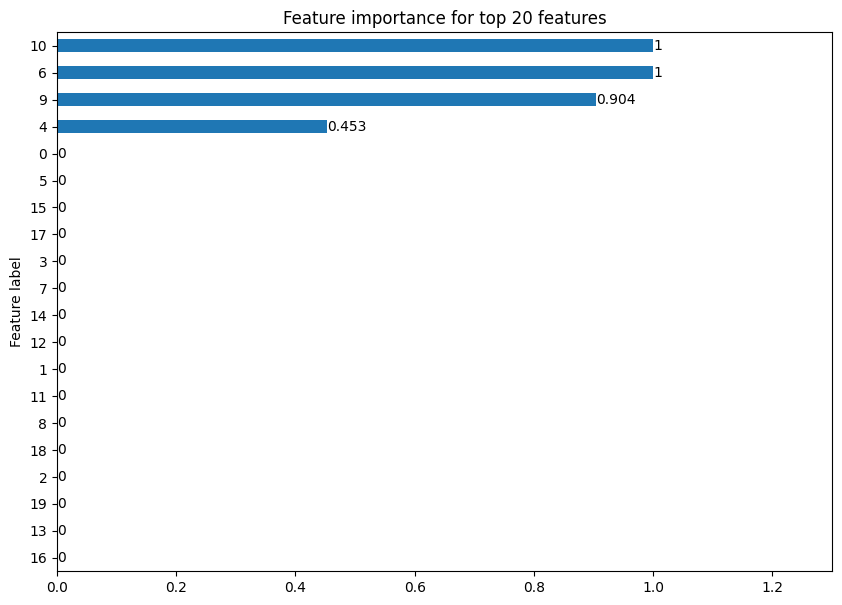

Explanation for graph ttnA_Mod.5.pdb_aligned: tensor([2.5619e-11, 0.0000e+00, 2.5591e-11,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.7881e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.7913e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


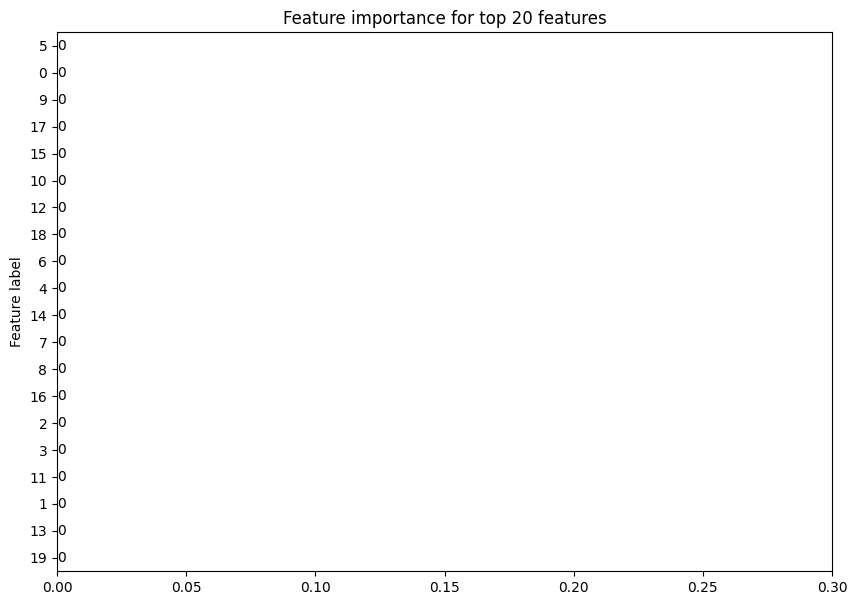

Explanation for graph nidA5_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


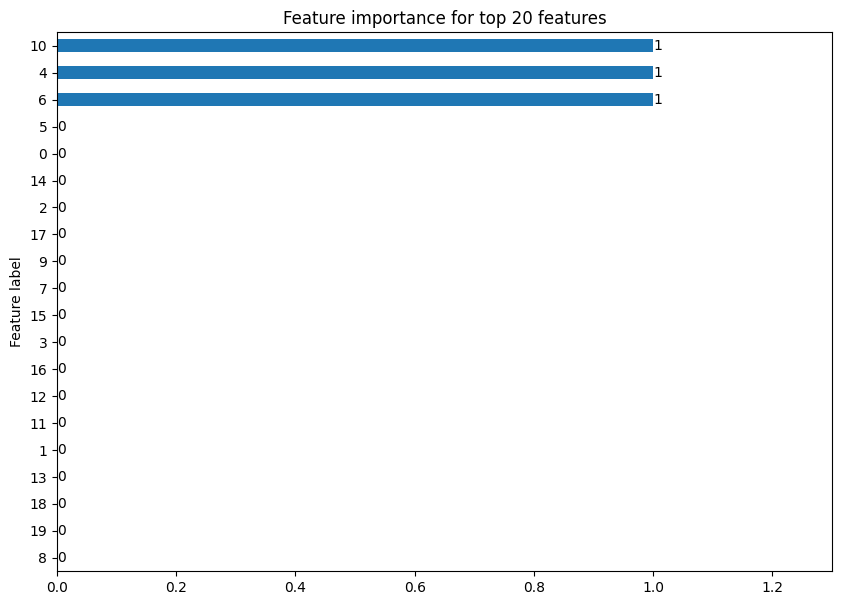

Explanation for graph fosD_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


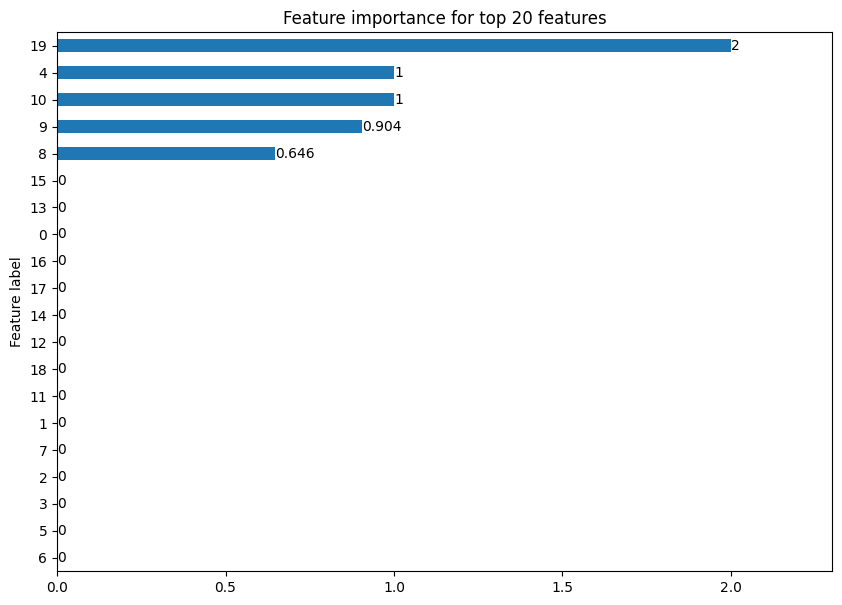

Explanation for graph rapB_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


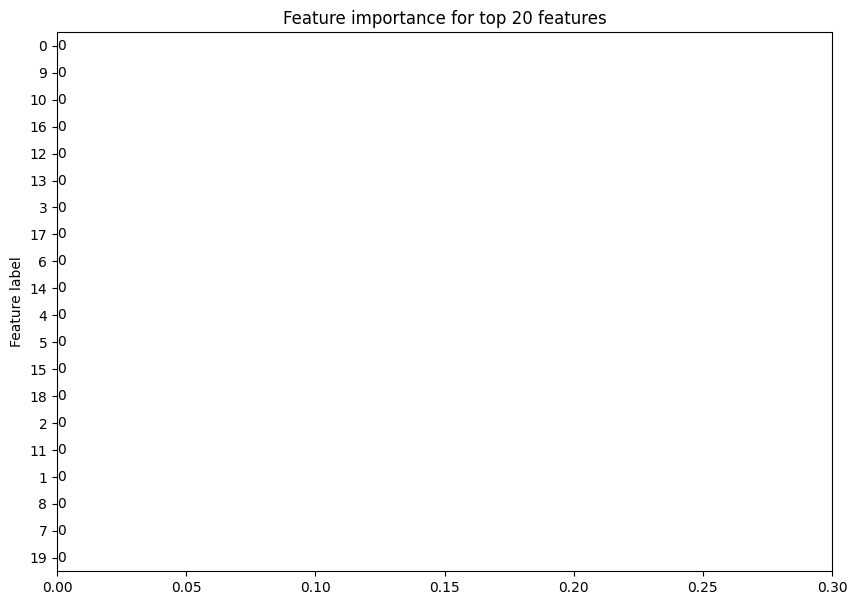

Explanation for graph kijA_Mod.9.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


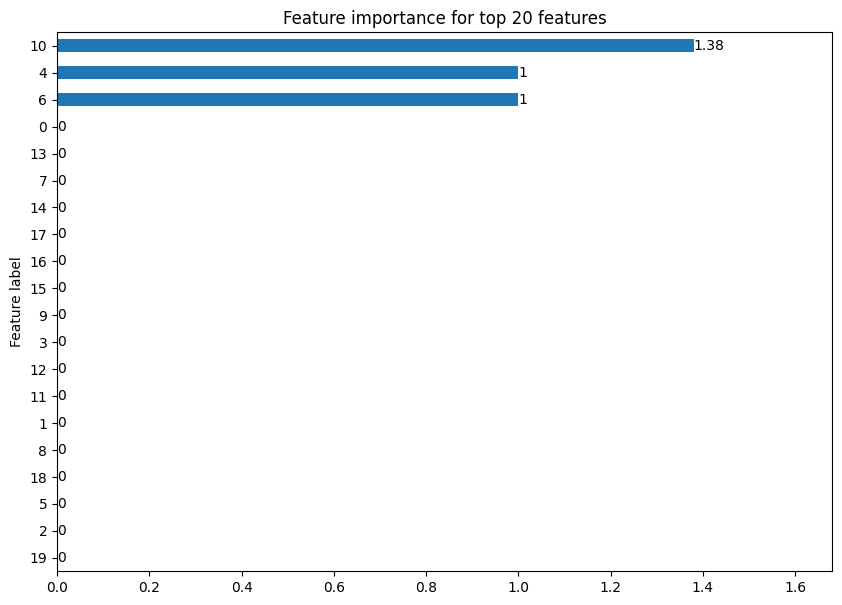

Explanation for graph btlA_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


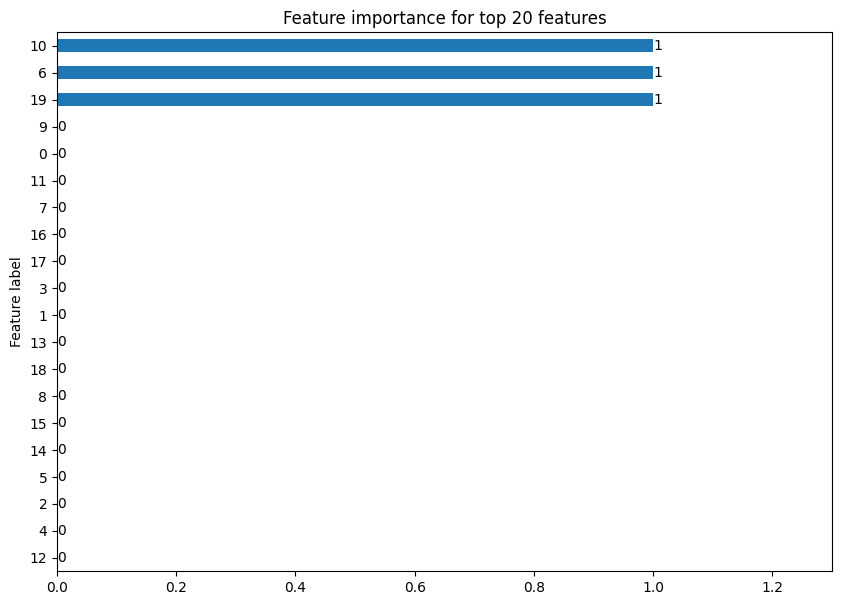

Explanation for graph cyrF_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


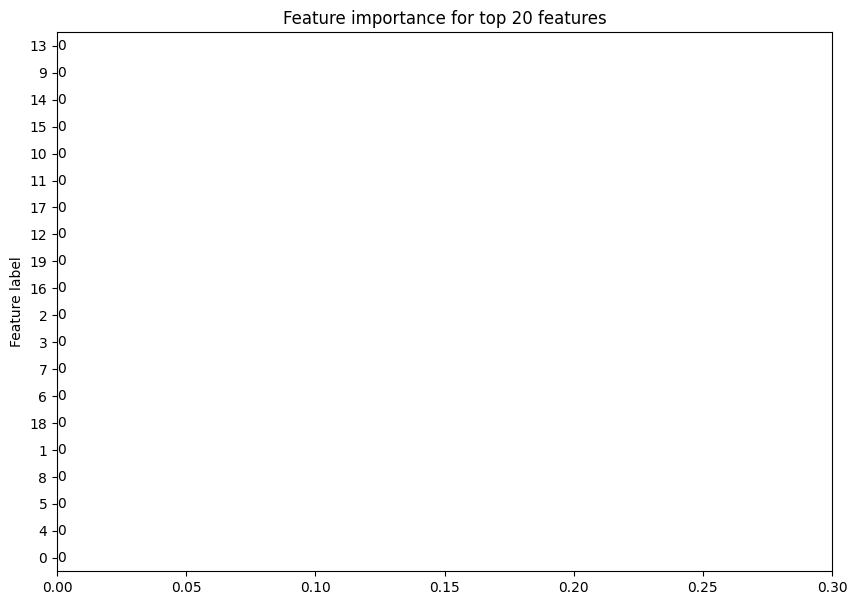

Explanation for graph meiA3_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


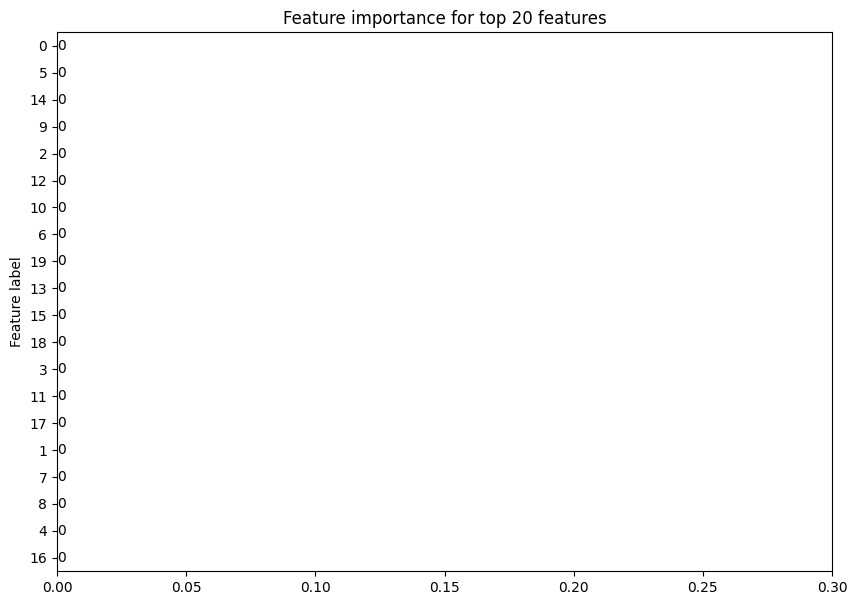

Explanation for graph StamC_Mod.7.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


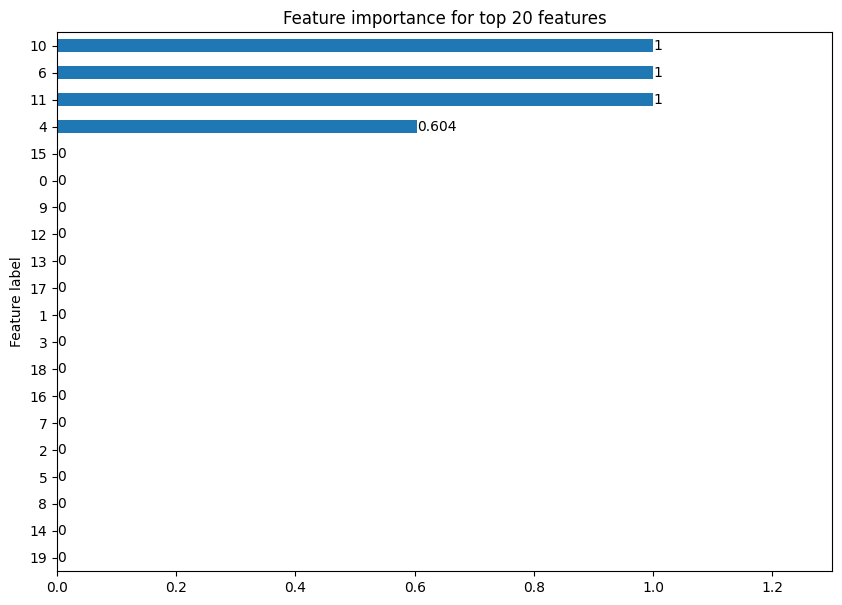

Explanation for graph lydF_Mod.12.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


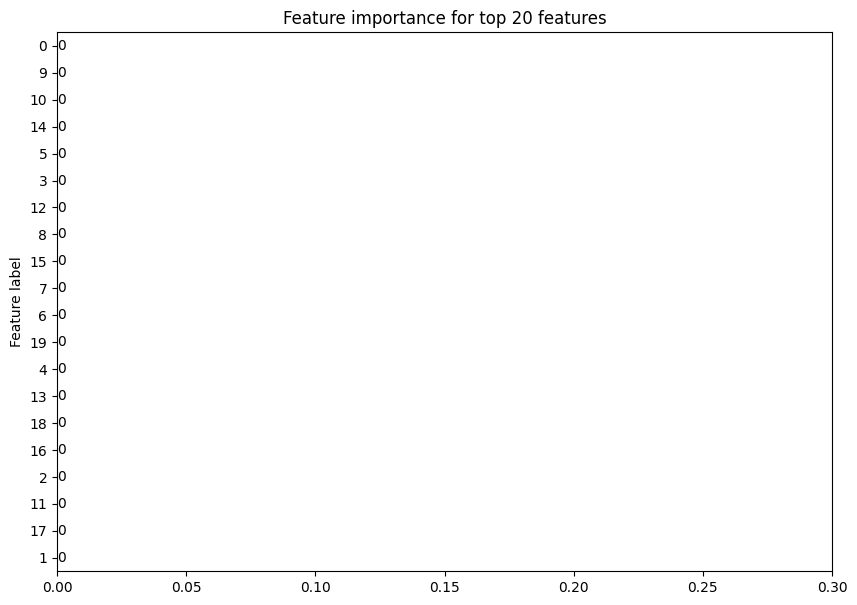

Explanation for graph conB_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


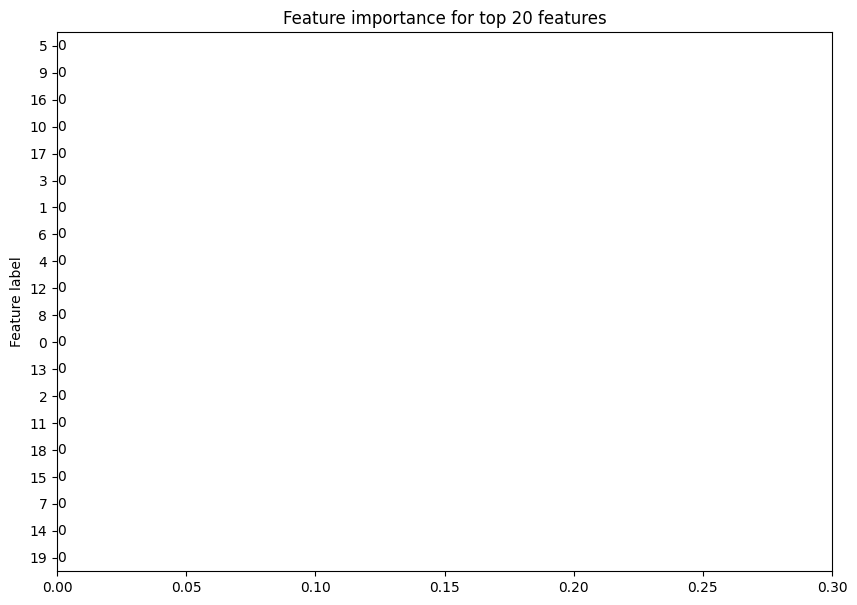

Explanation for graph tiaA1_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


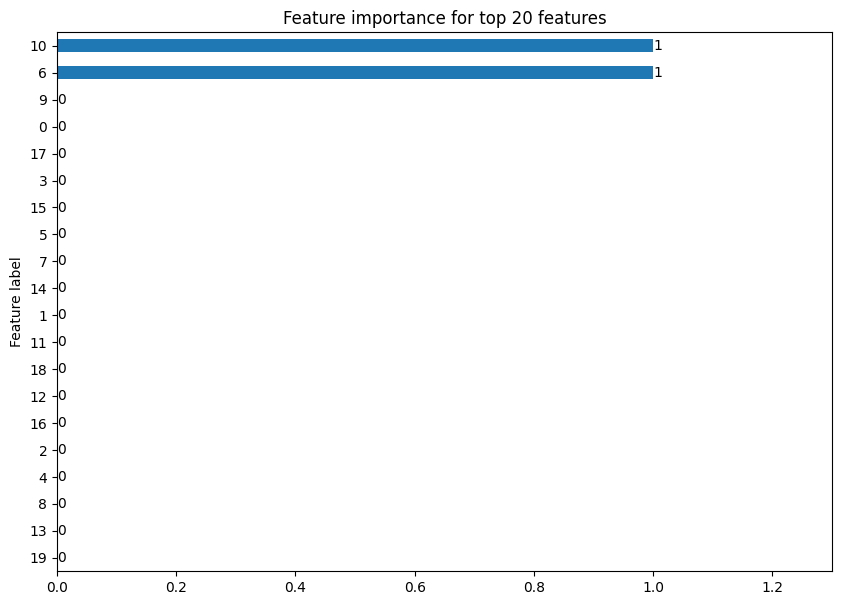

Explanation for graph cppC_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


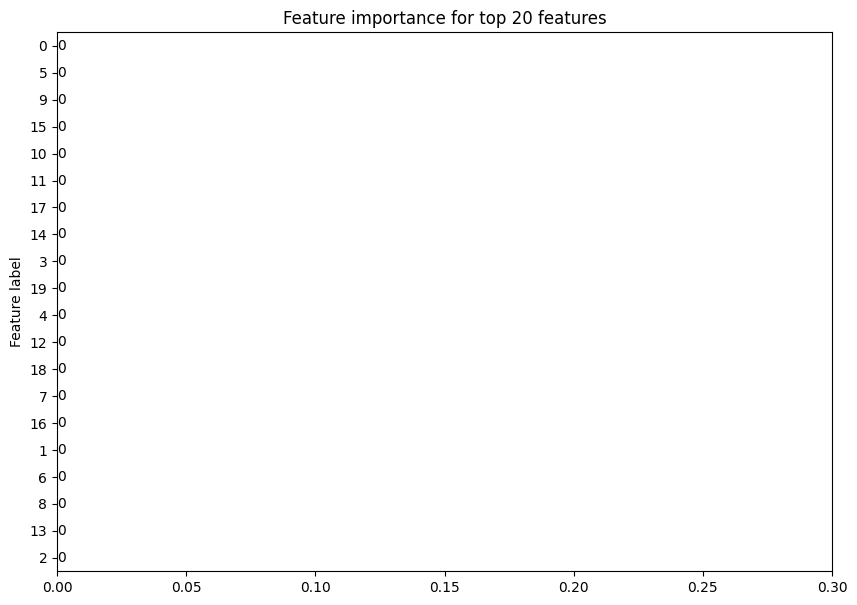

Explanation for graph cyrE_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


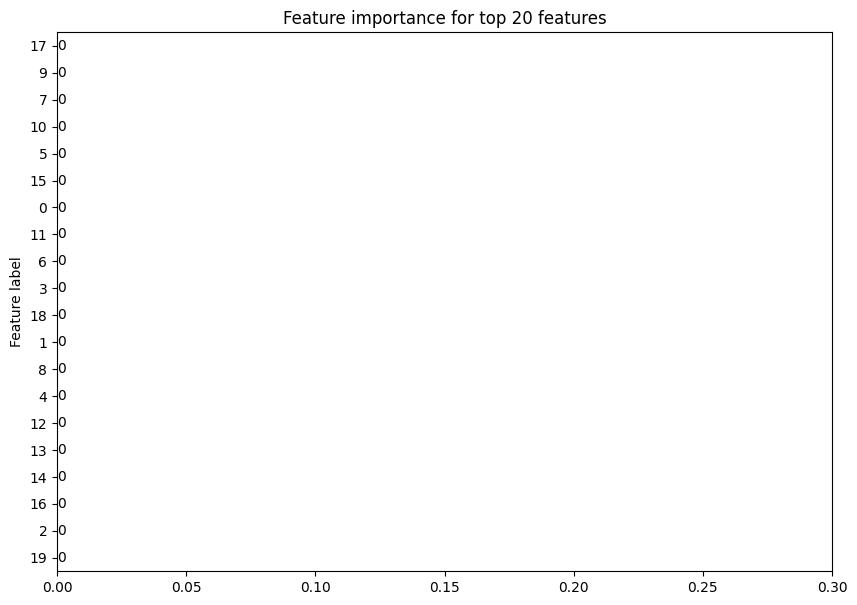

Explanation for graph rapA_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


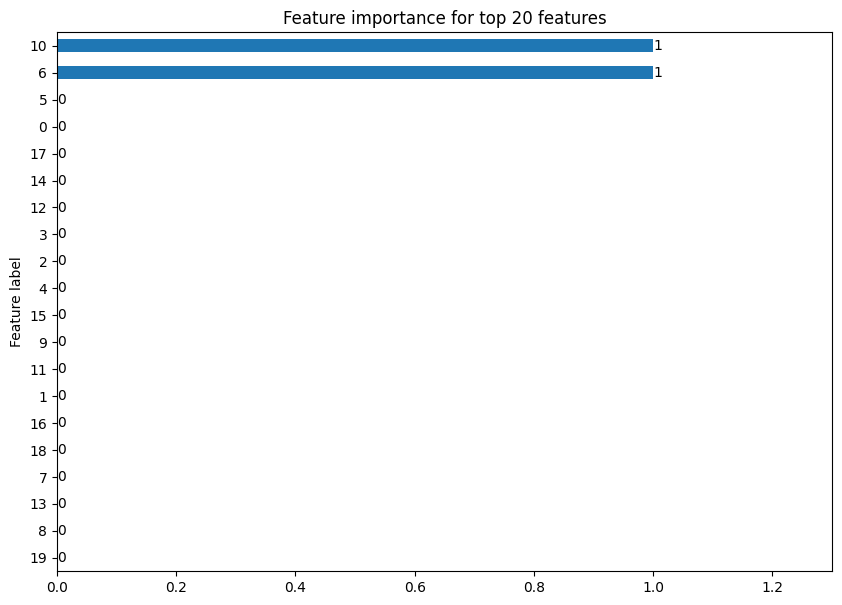

Explanation for graph conC_Mod.7.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


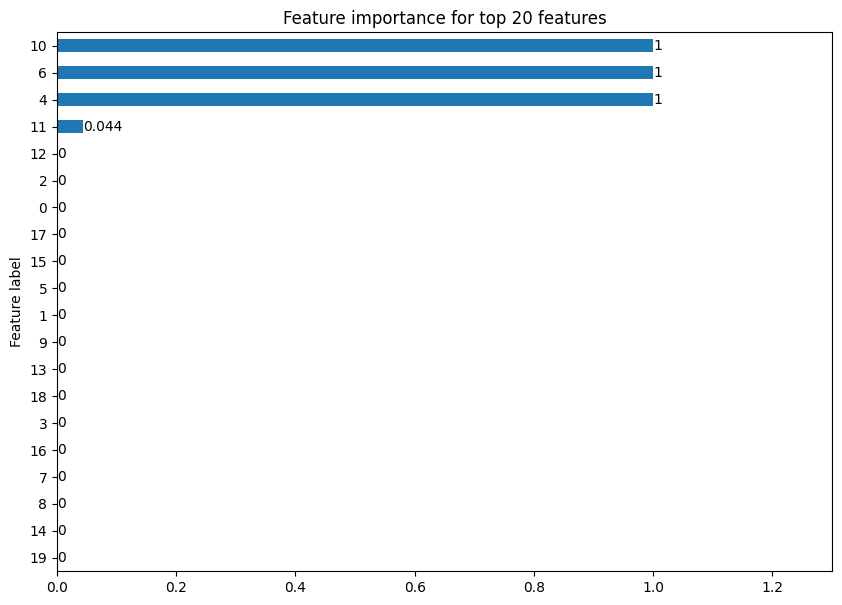

Explanation for graph mbcAII_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


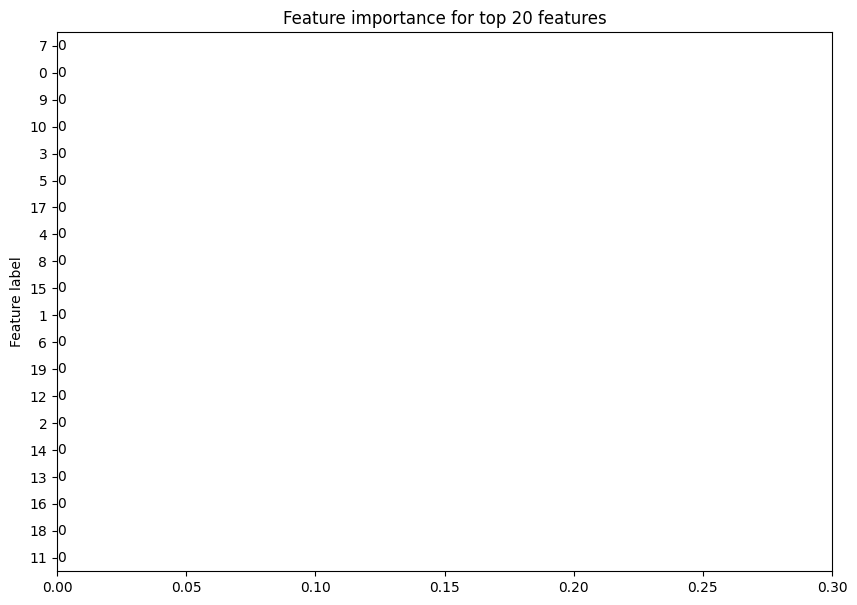

Explanation for graph lydF_Mod.13.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


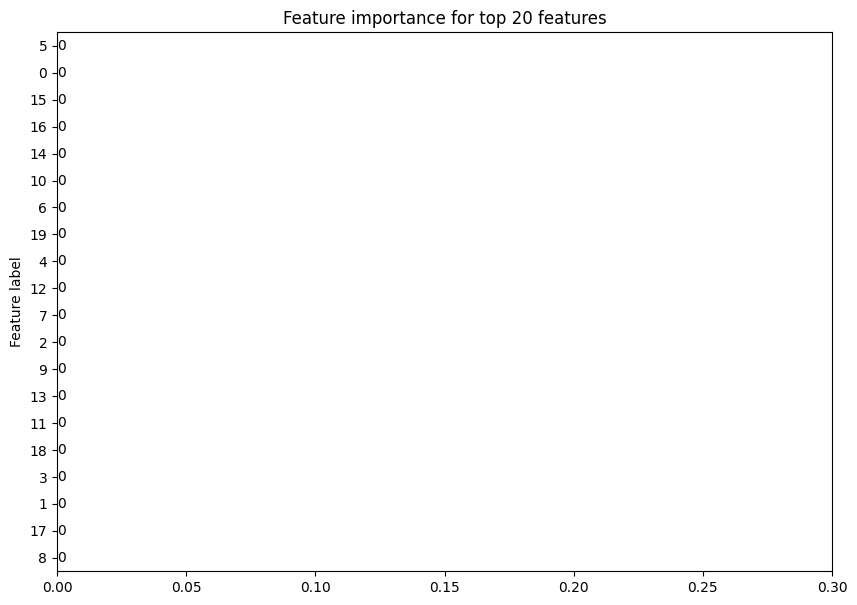

Explanation for graph nysC_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


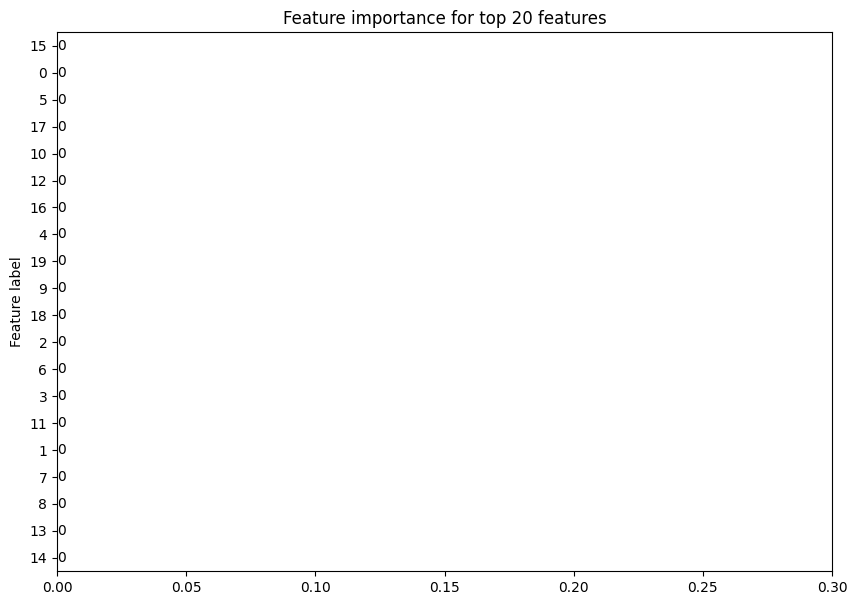

Explanation for graph btlD_Mod.7.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


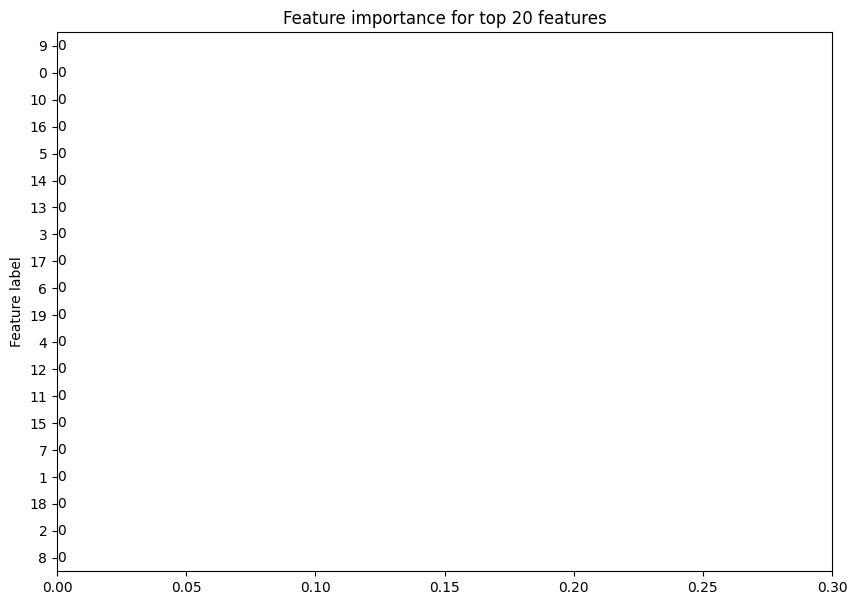

Explanation for graph BafAIII_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


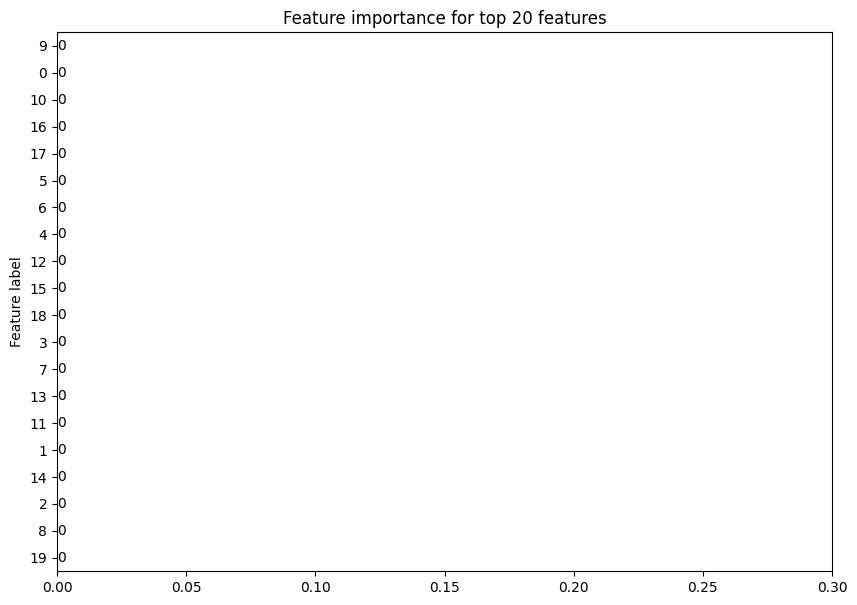

Explanation for graph cmiP7_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.6212e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


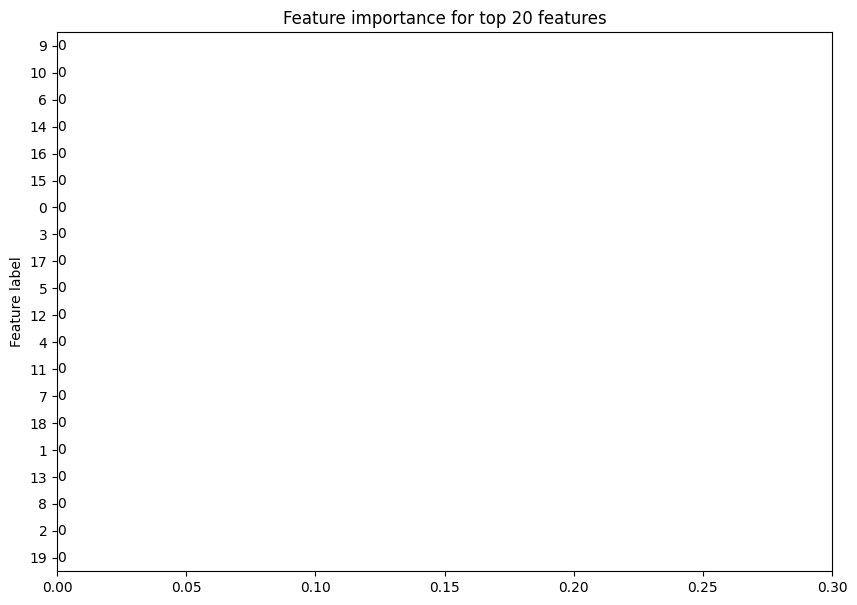

Explanation for graph cle2_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


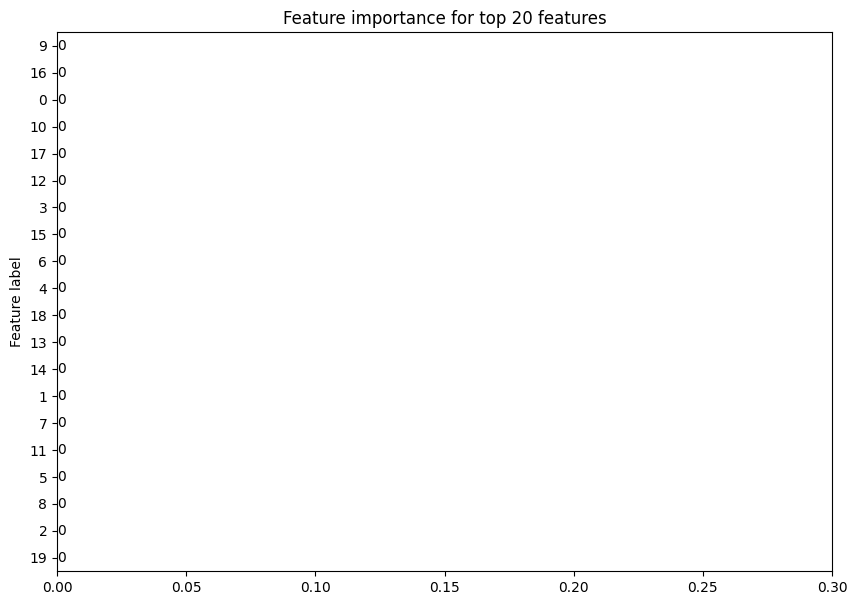

Explanation for graph cle1_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


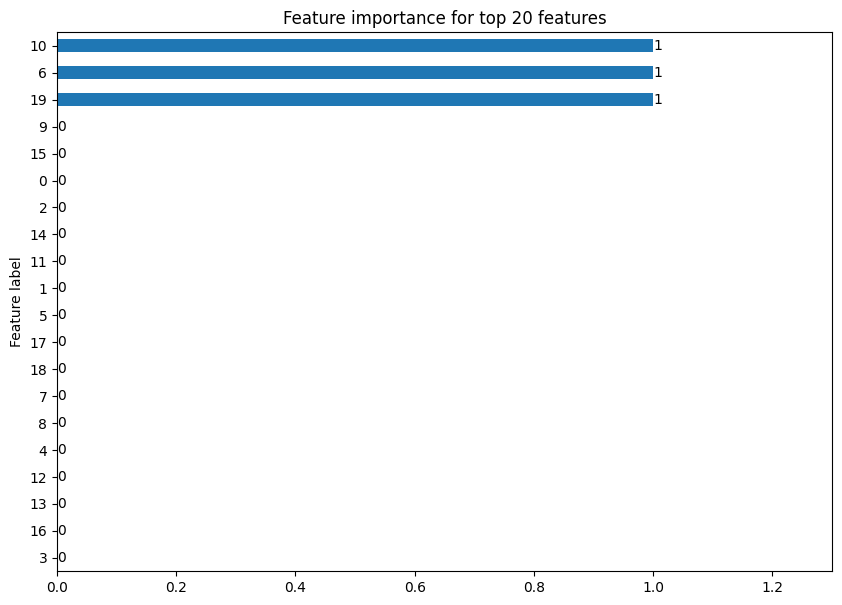

Explanation for graph spr11_Mod.7.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


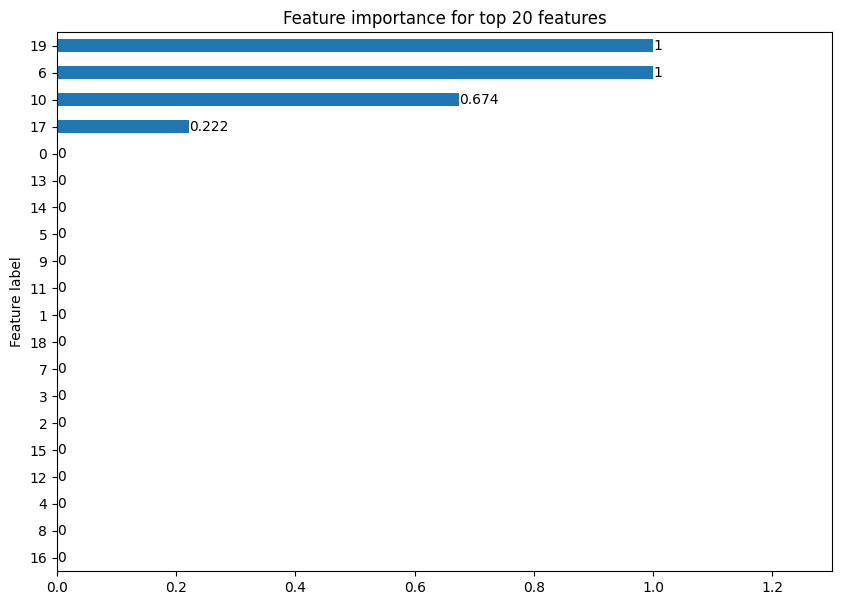

Explanation for graph idnP3_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


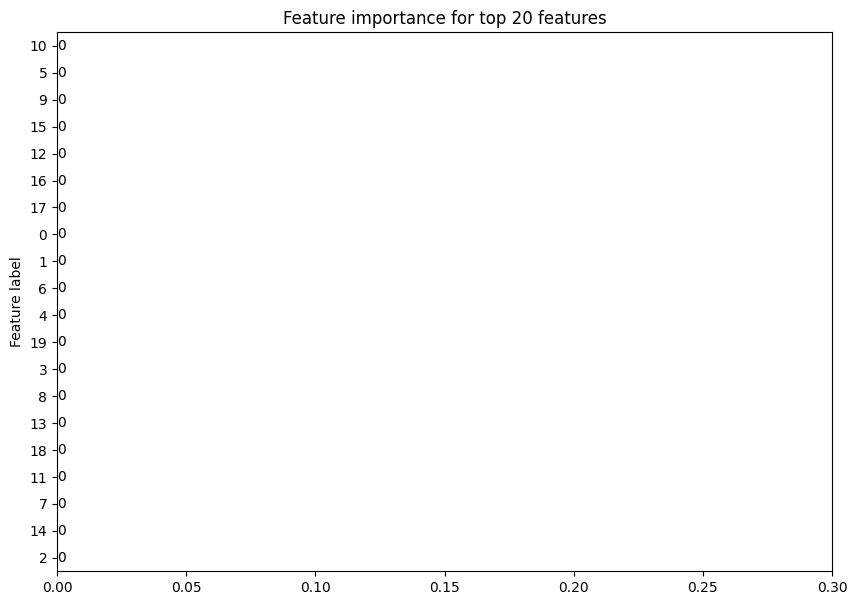

Explanation for graph nysI_Mod.6.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


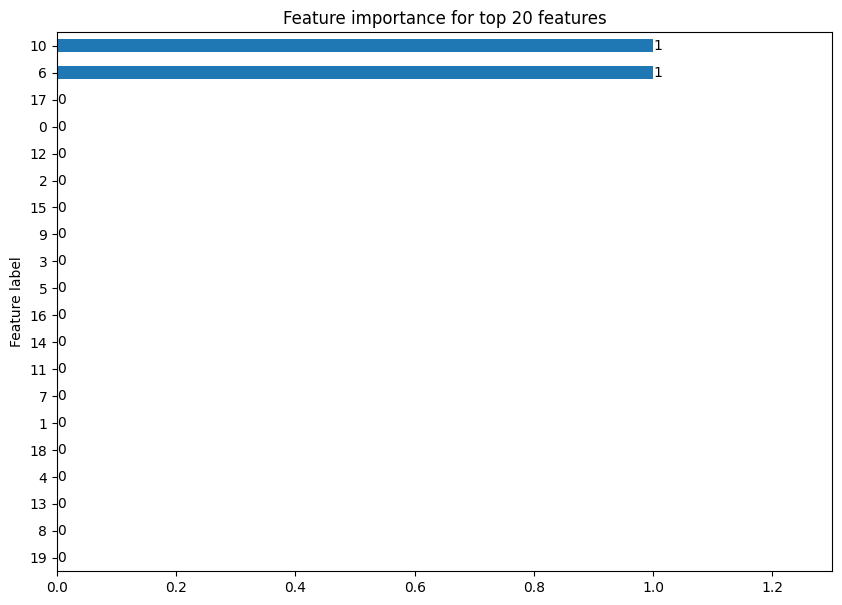

Explanation for graph nysC_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


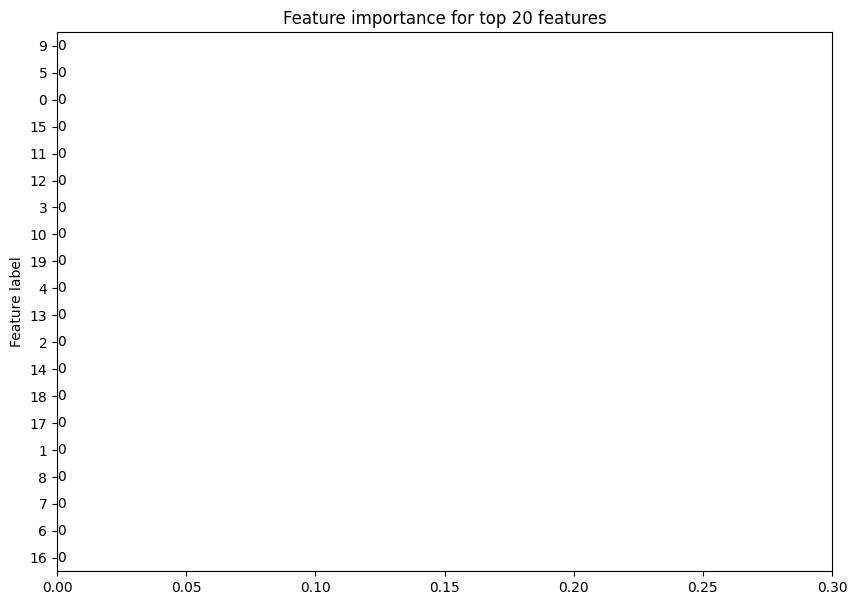

Explanation for graph rapB_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


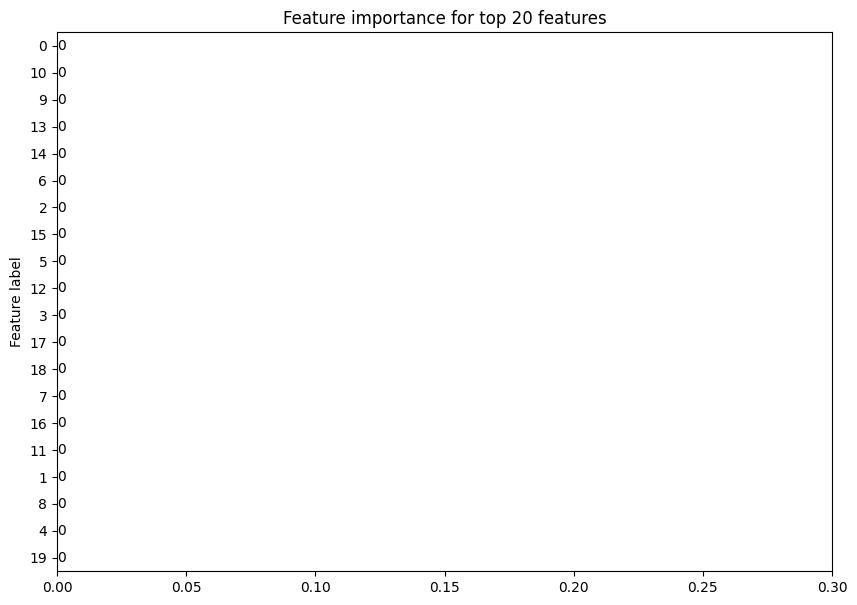

Explanation for graph slnA8_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


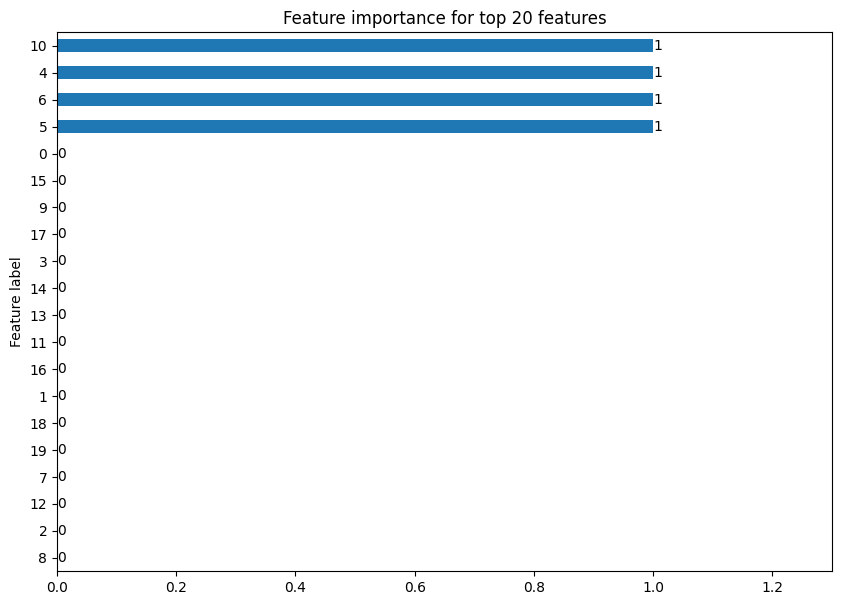

Explanation for graph herC_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


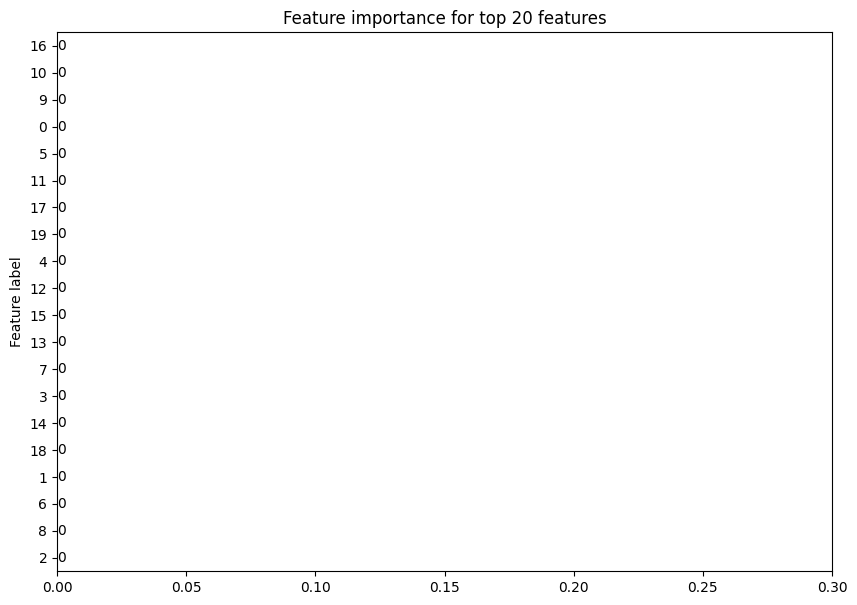

Explanation for graph ChlA5_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


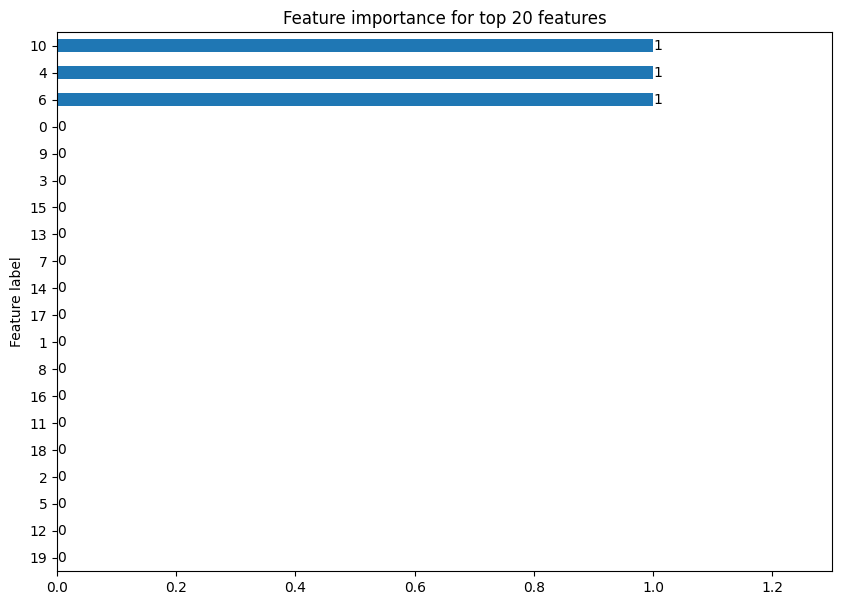

Explanation for graph nemA4_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


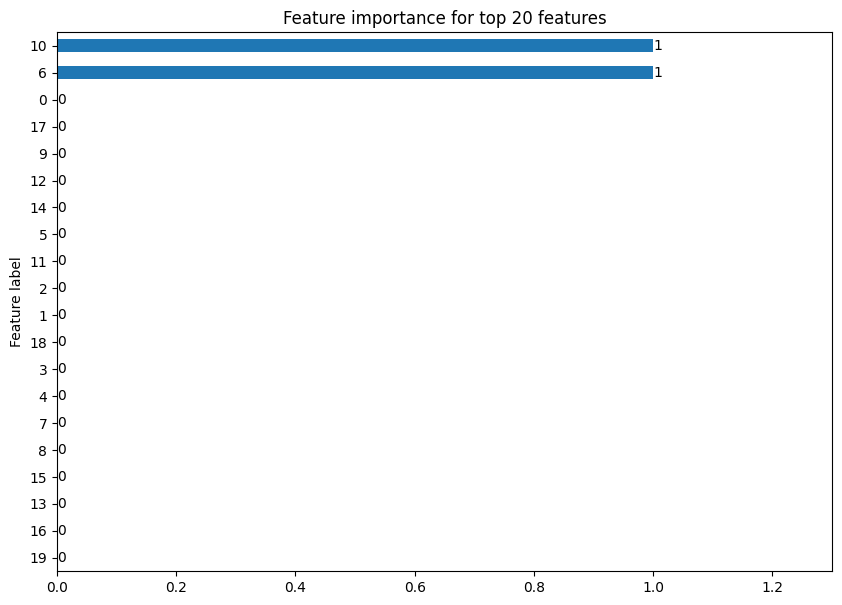

Explanation for graph tiaA4_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


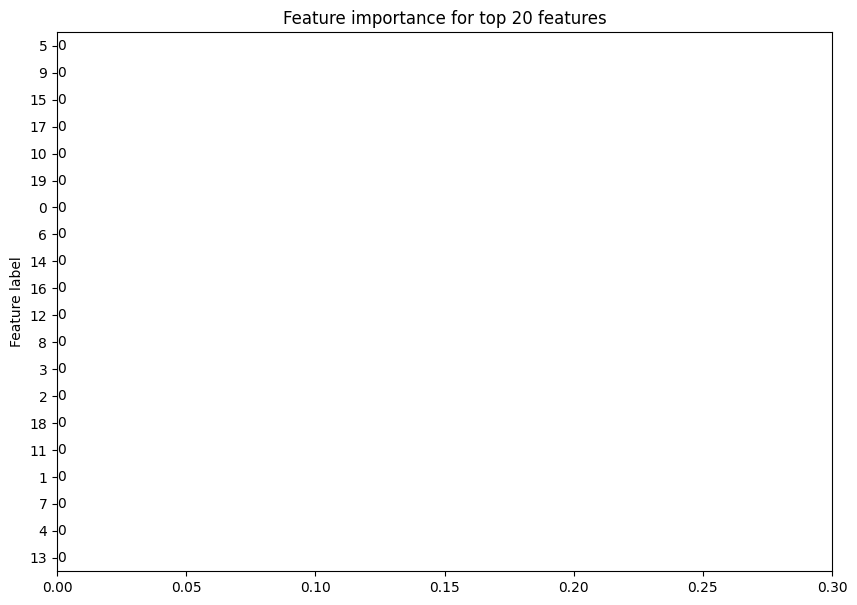

Explanation for graph tiaA4_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


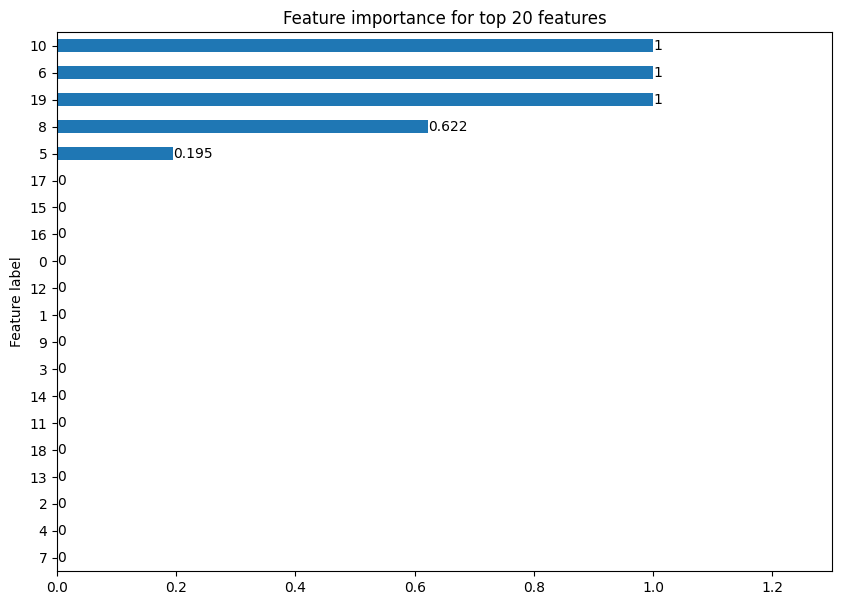

Explanation for graph cppI_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


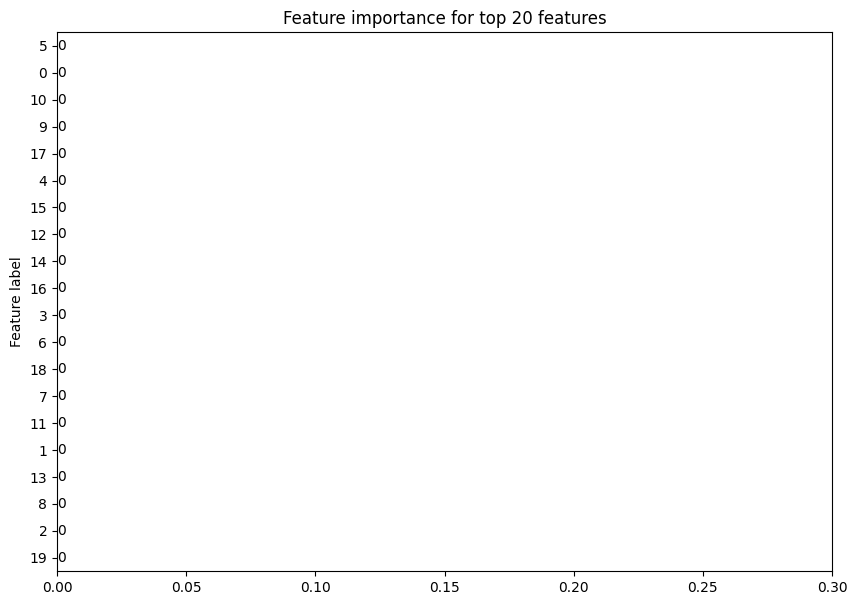

Explanation for graph olmA1_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


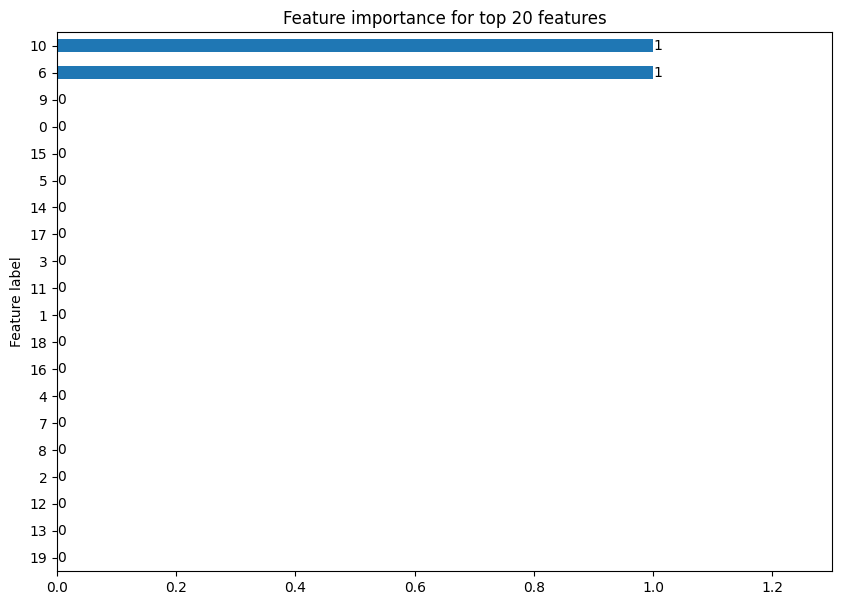

Explanation for graph cxmE_Mod.11.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


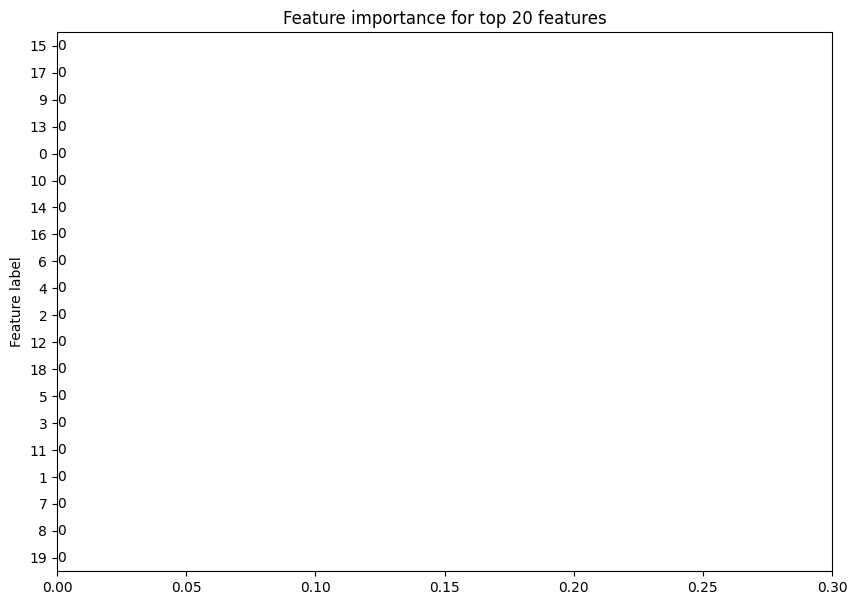

Explanation for graph revD_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


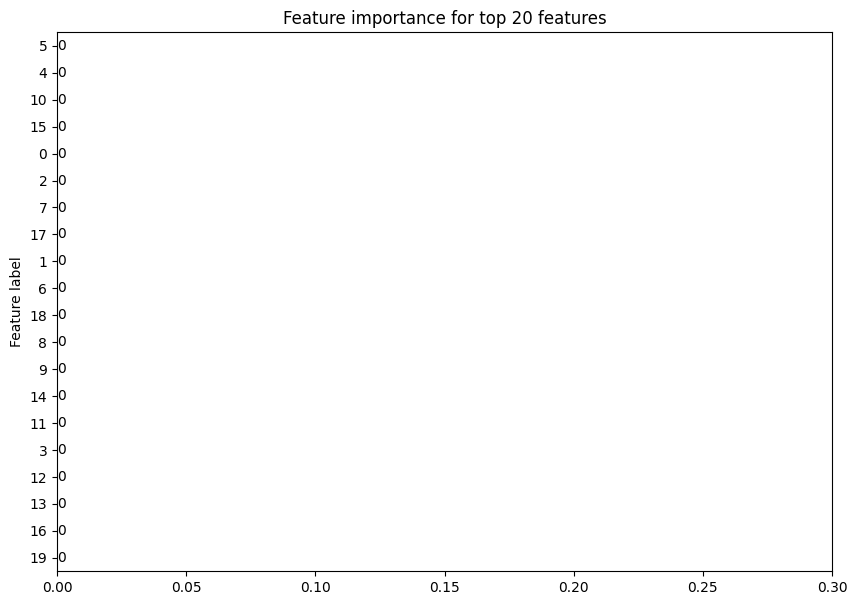

Explanation for graph nysB_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


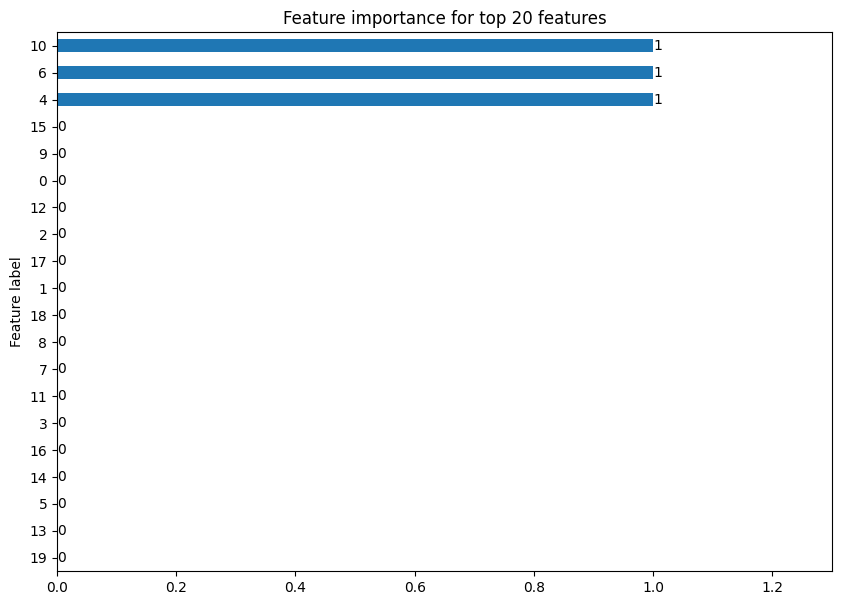

Explanation for graph sfaH_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


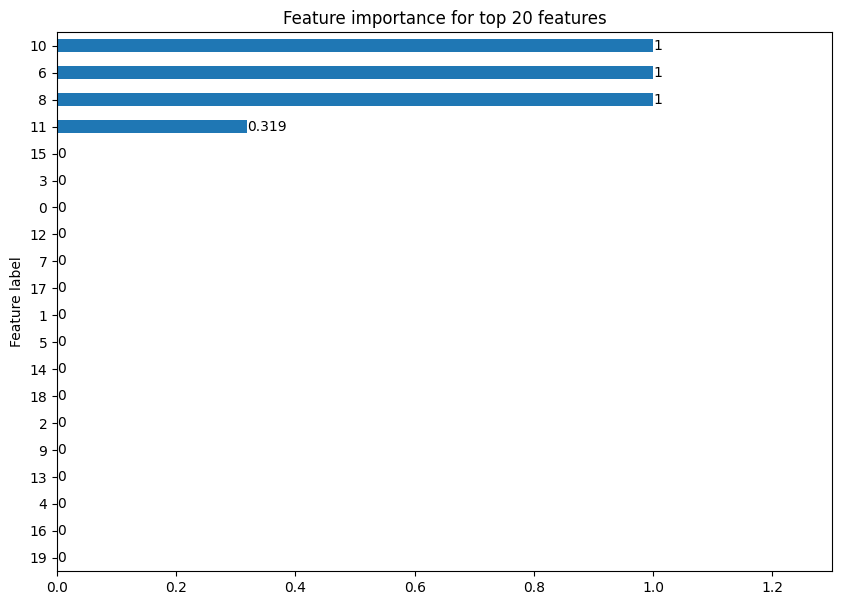

Explanation for graph cppB_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


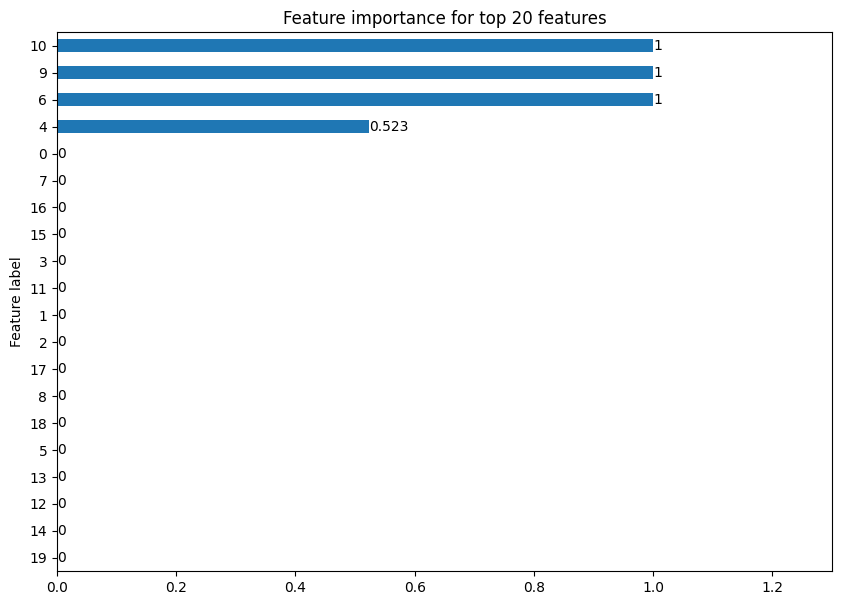

Explanation for graph nemA3_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


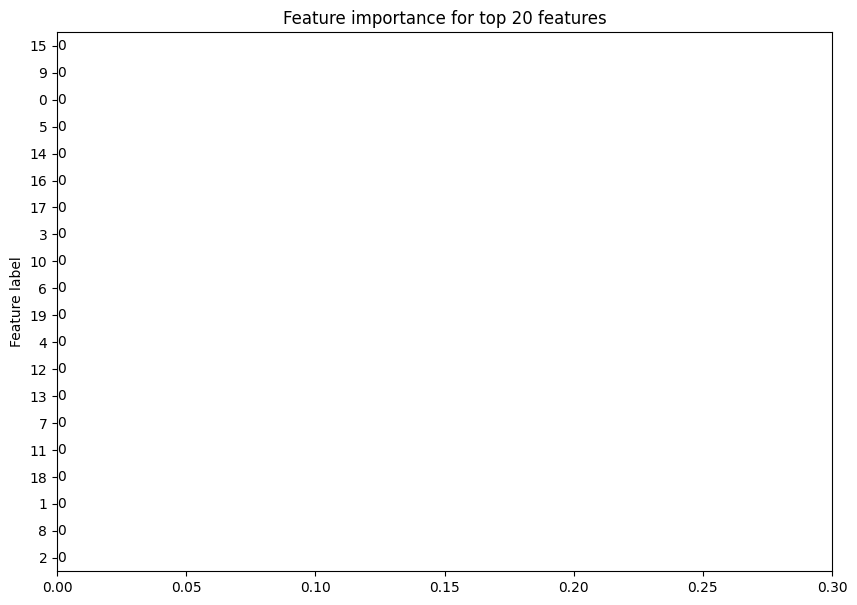

Explanation for graph ladSVII_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


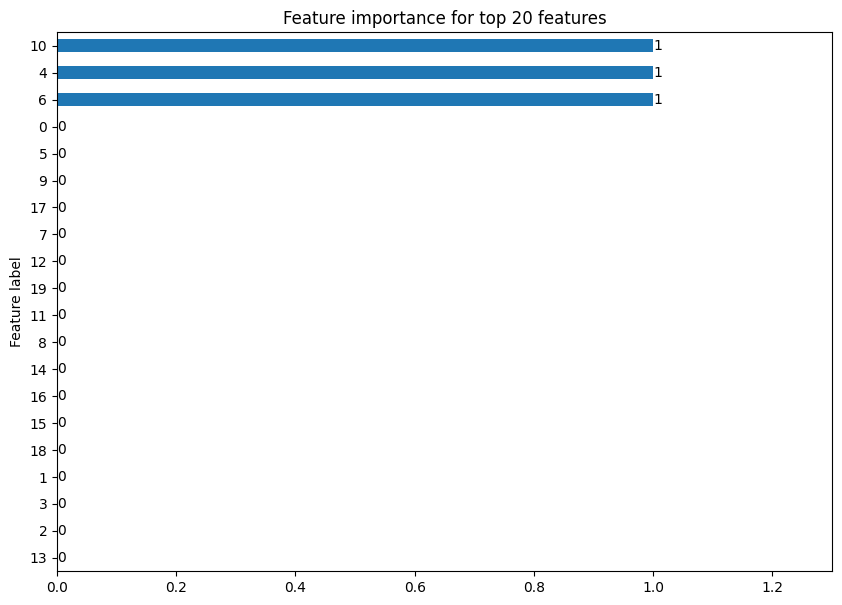

Explanation for graph pteA1_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


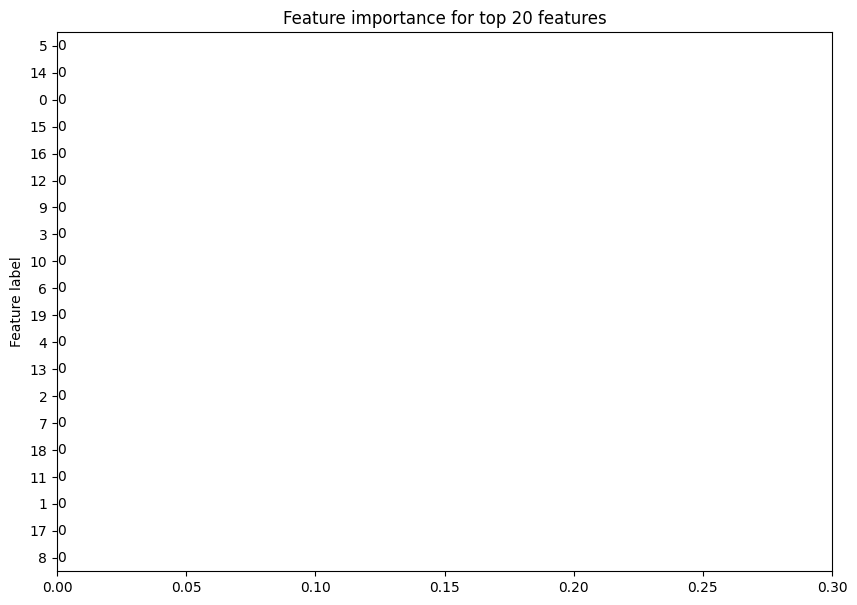

Explanation for graph nbrH_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


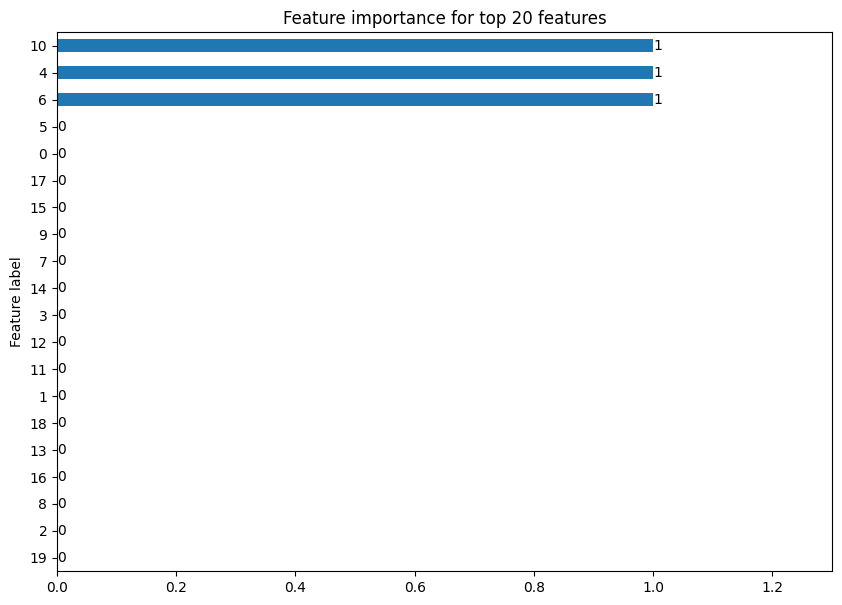

Explanation for graph SgnS2_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


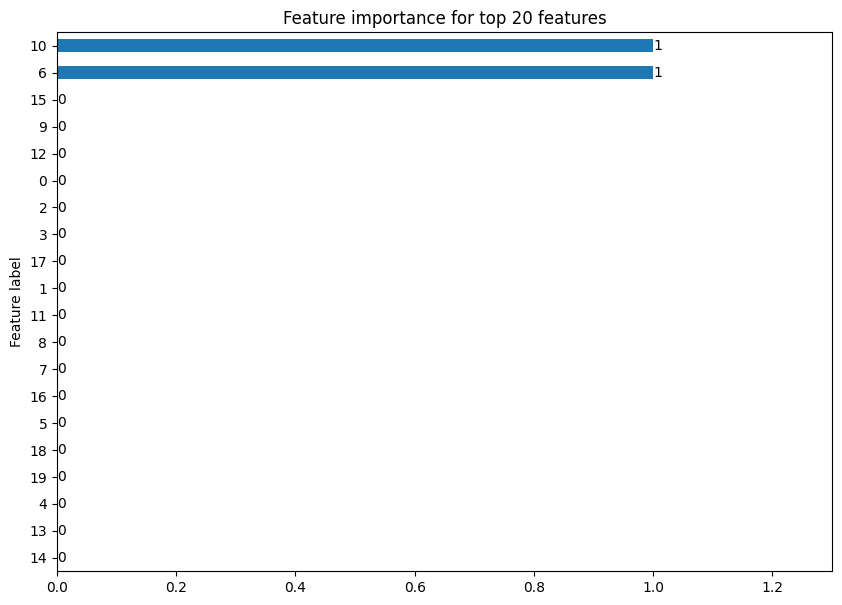

Explanation for graph AceP3_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


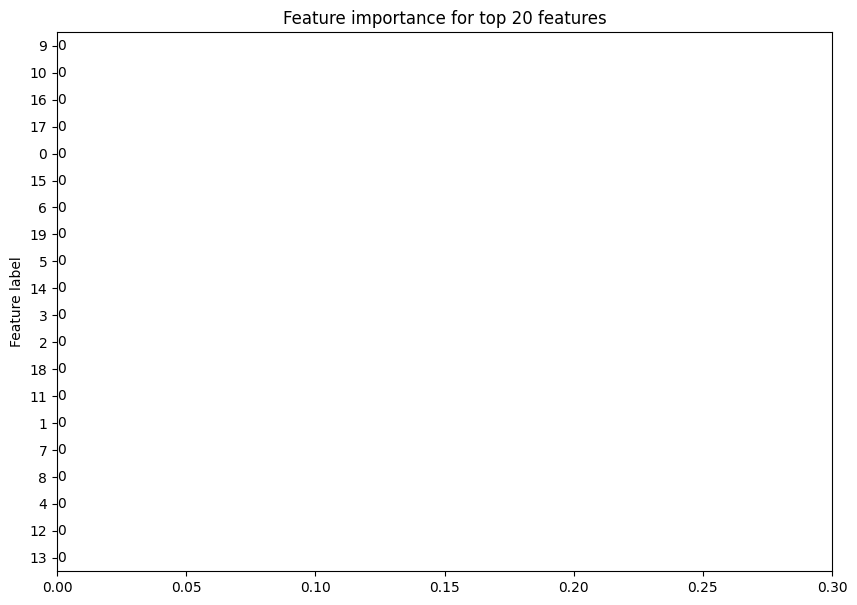

Explanation for graph ttmI_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


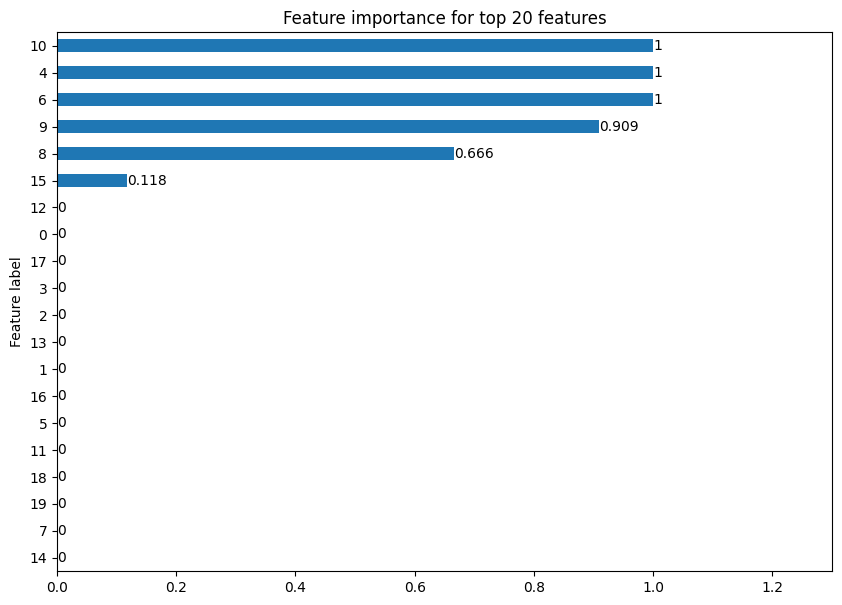

Explanation for graph selC_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


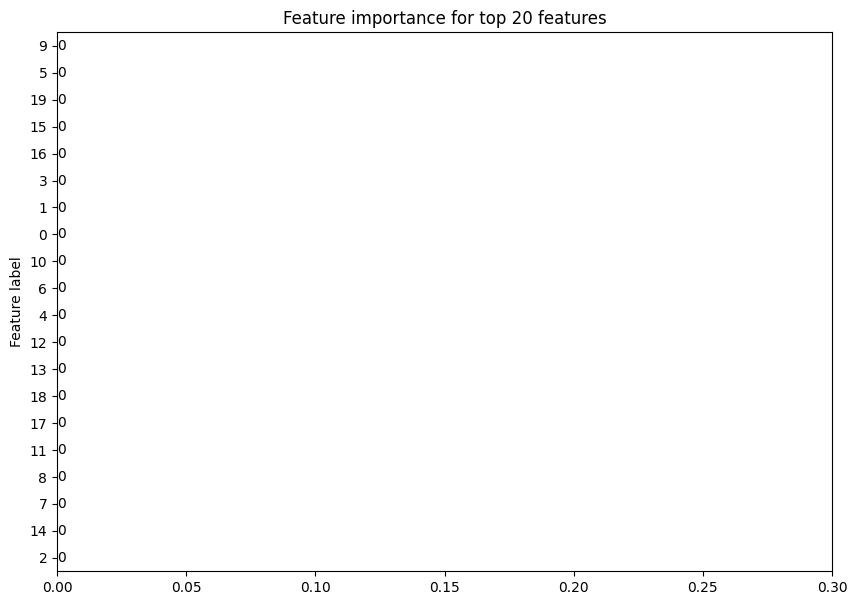

Explanation for graph scnS2_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


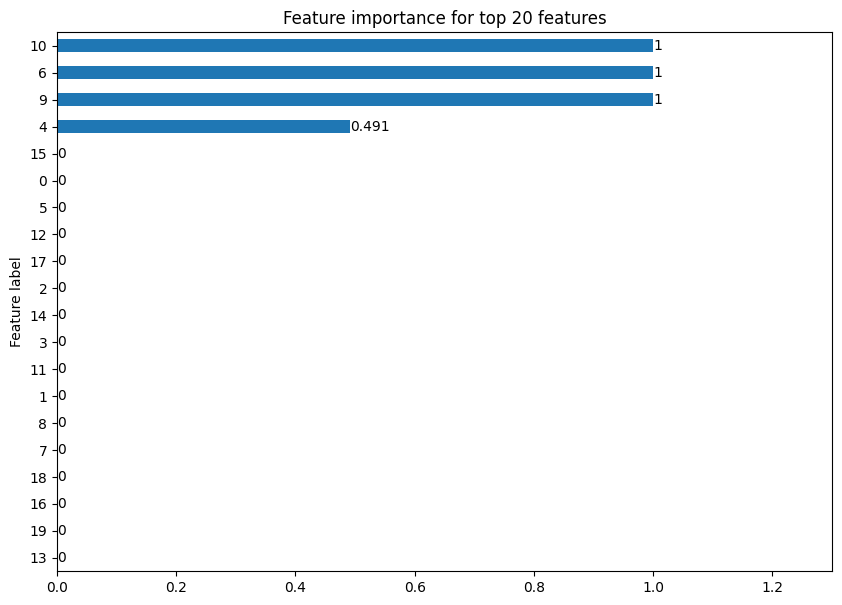

Explanation for graph hgcB_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


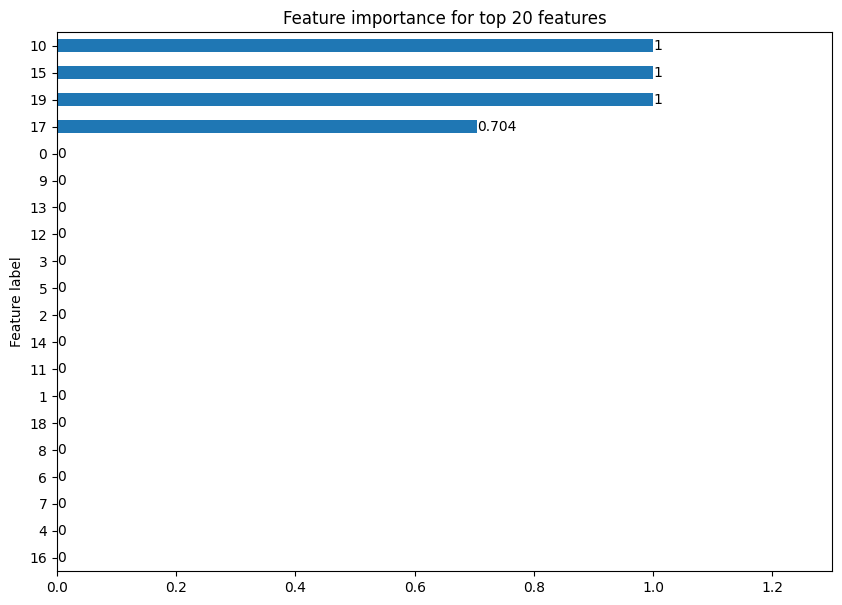

Explanation for graph AceP3_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


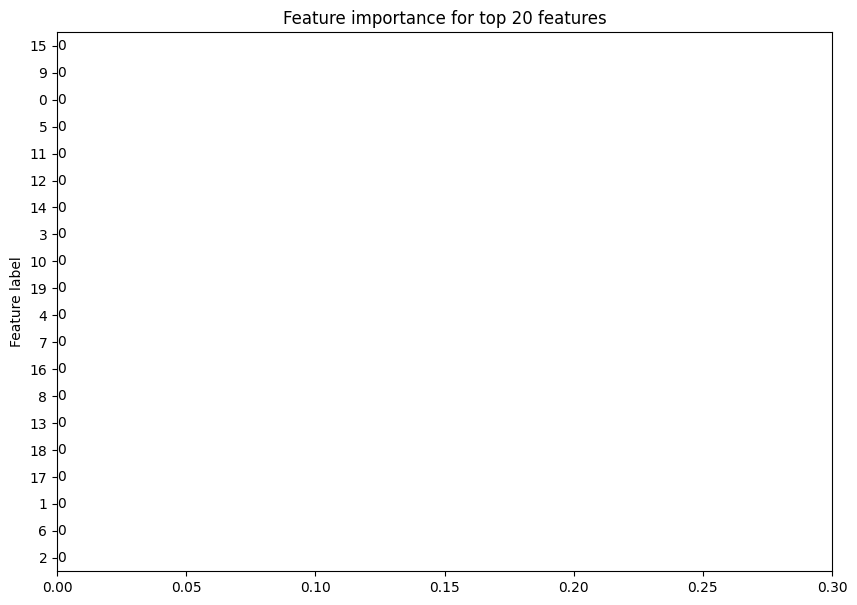

Explanation for graph ladSIII_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


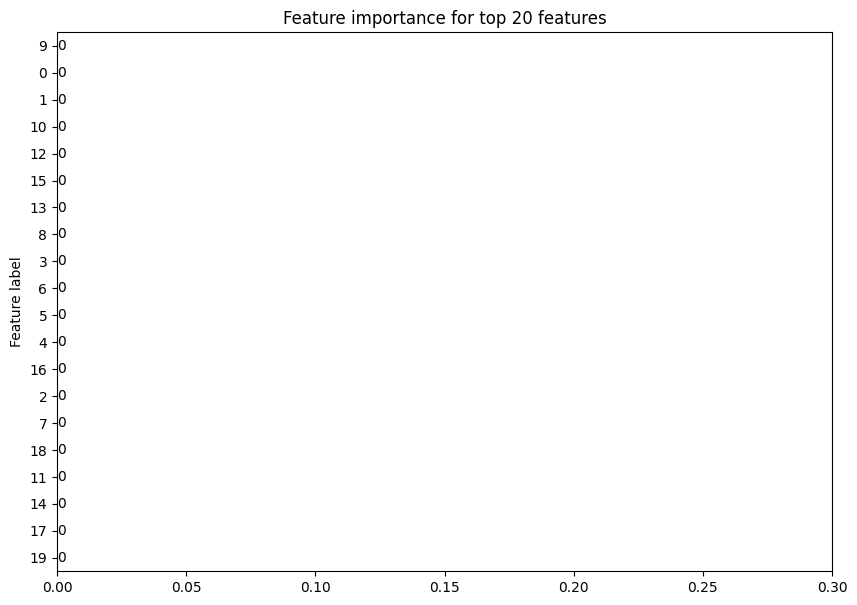

Explanation for graph ChlA2_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


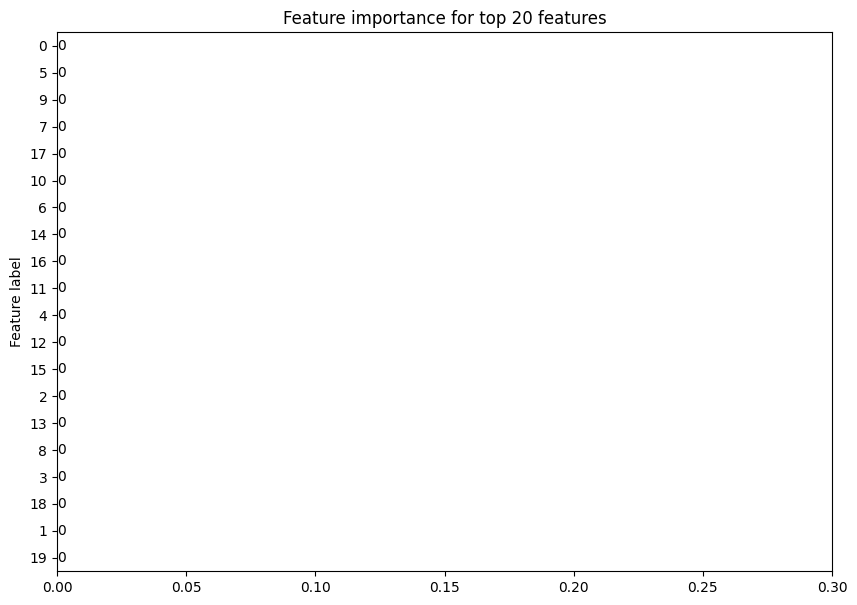

Explanation for graph azlD_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


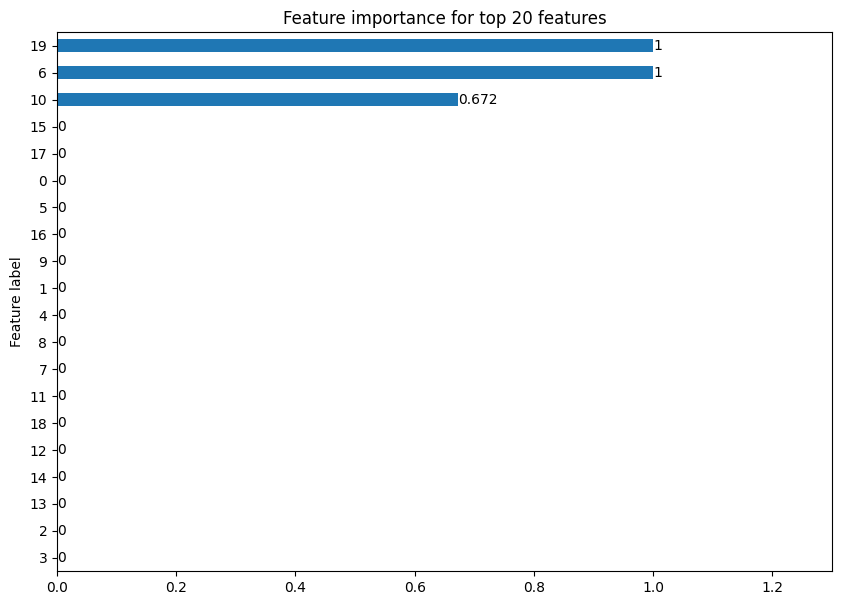

Explanation for graph aizD_mod.14.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


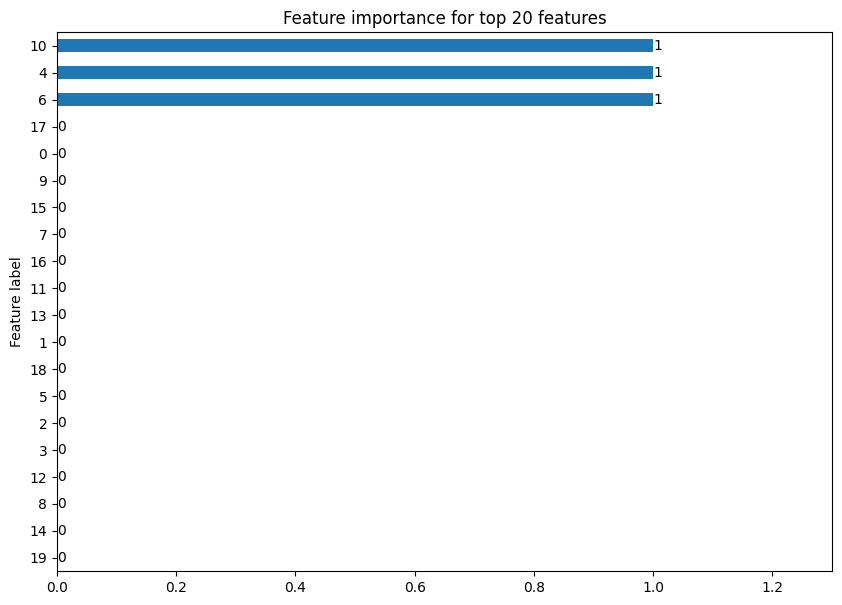

Explanation for graph cle6_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


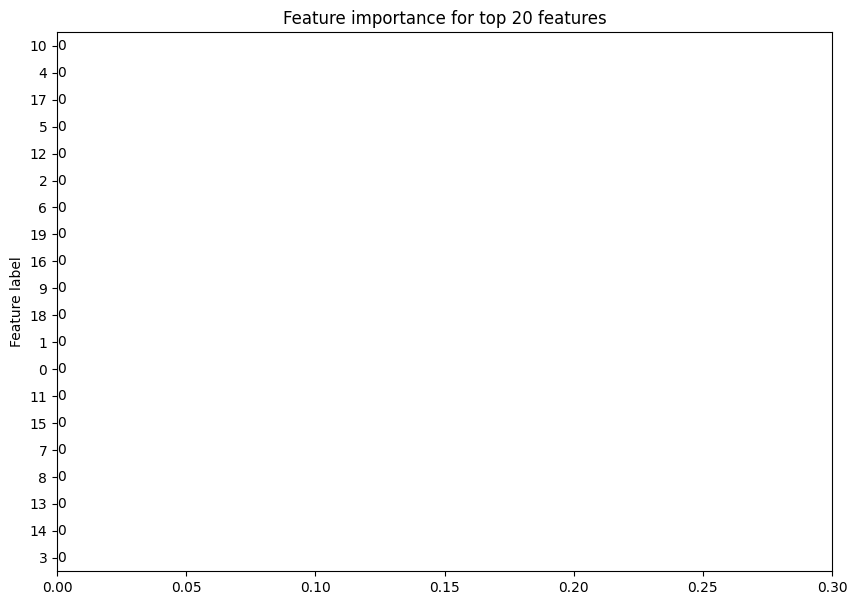

Processing batch with 12 graphs
Explanation for graph fscC_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


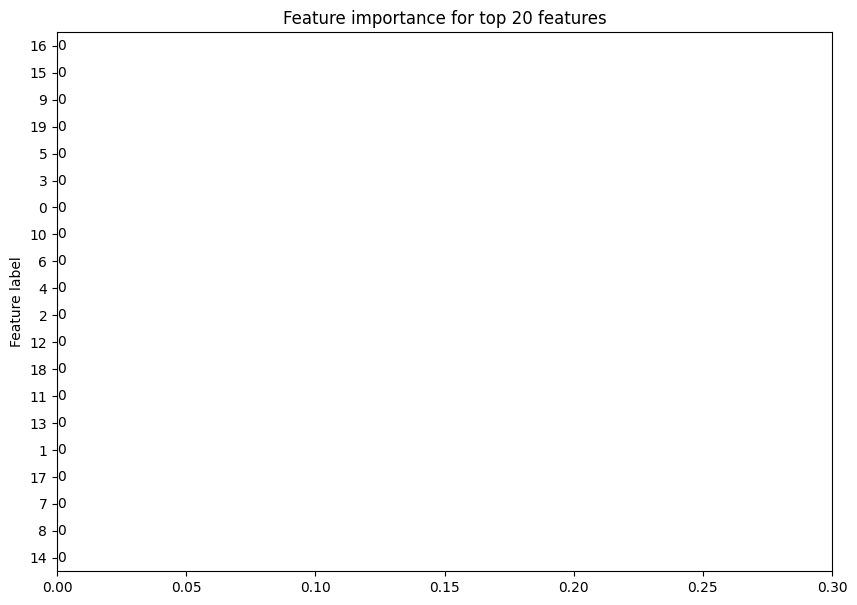

Explanation for graph aizA_mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


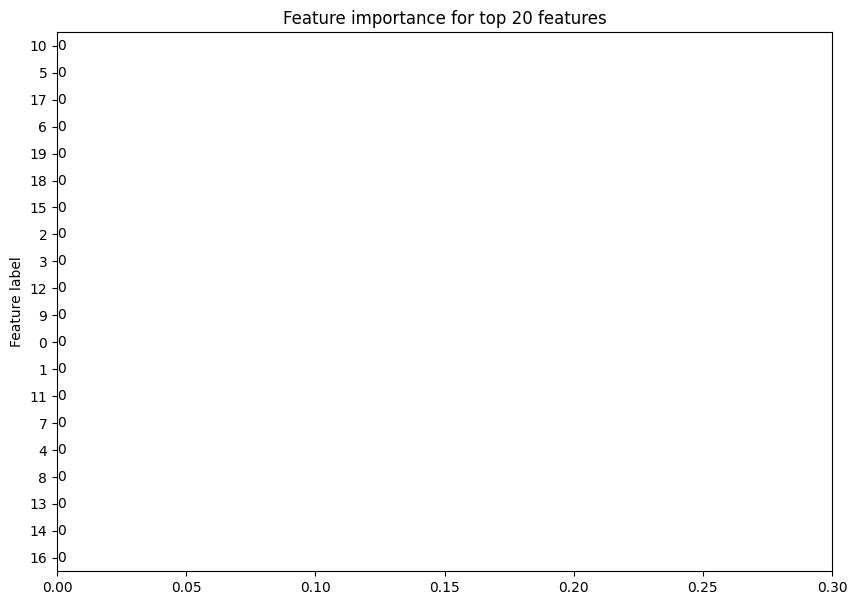

Explanation for graph nysI_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


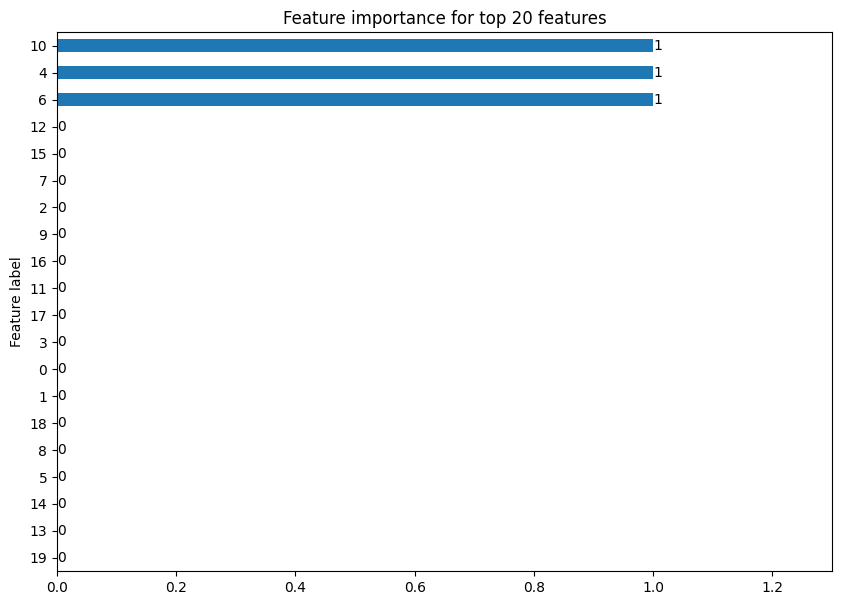

Explanation for graph lobA4_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


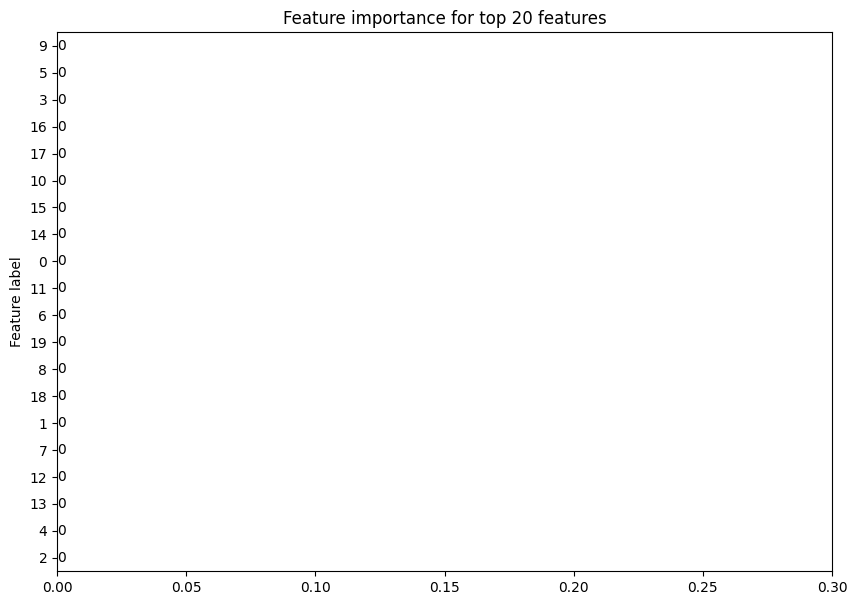

Explanation for graph olmA7_Mod.16.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


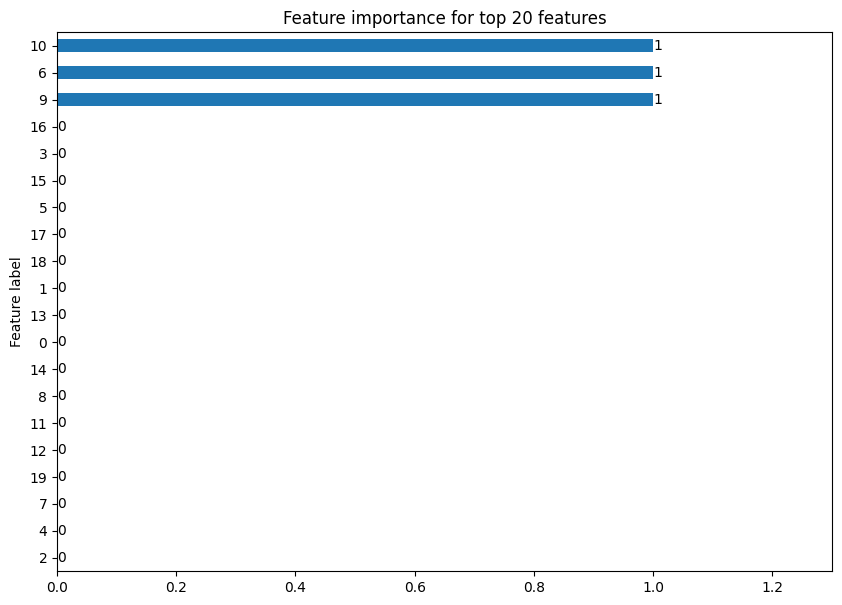

Explanation for graph fkbA_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


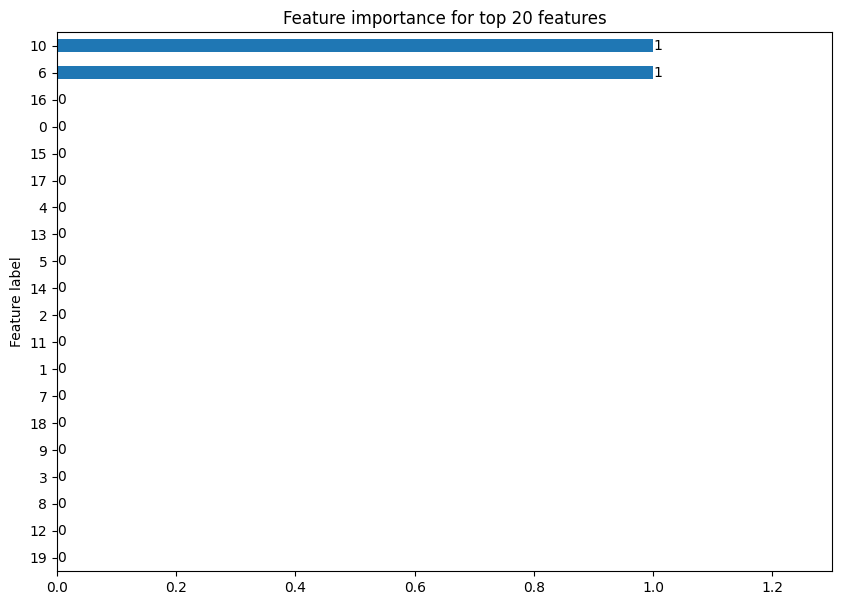

Explanation for graph aizB_mod.6.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


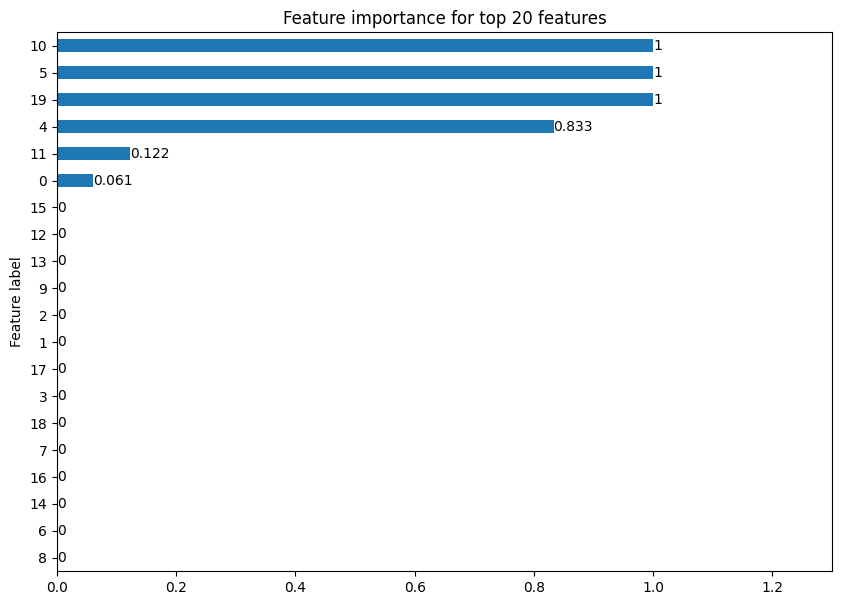

Explanation for graph ken16_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


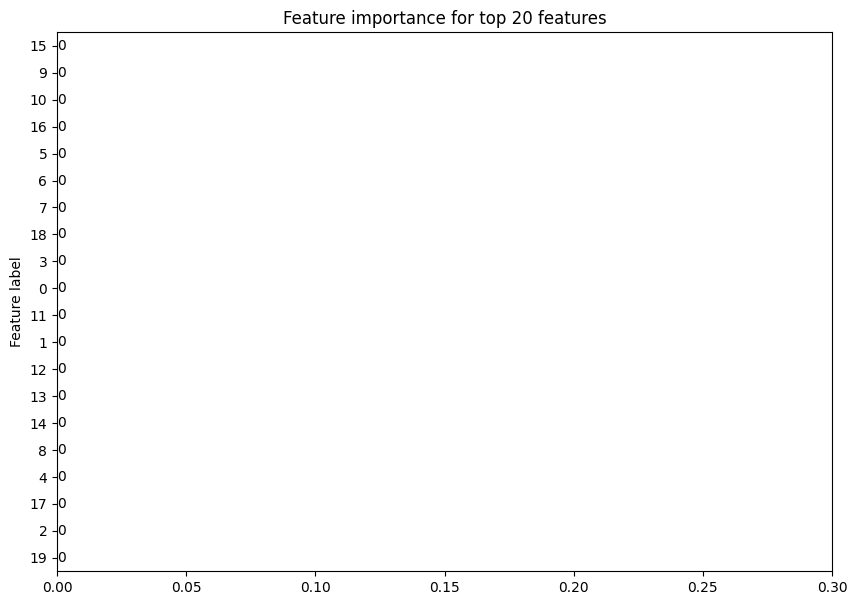

Explanation for graph acuAVI_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


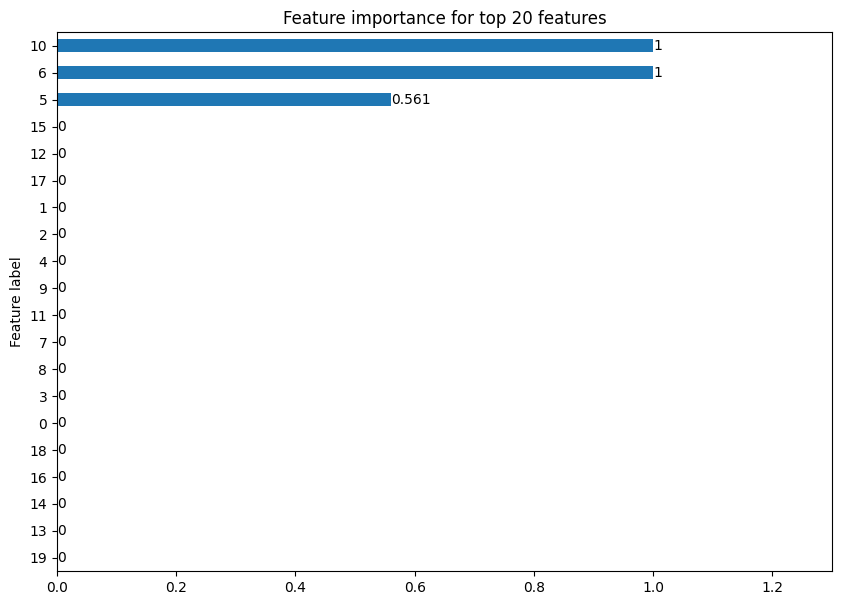

Explanation for graph mbcAIII_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


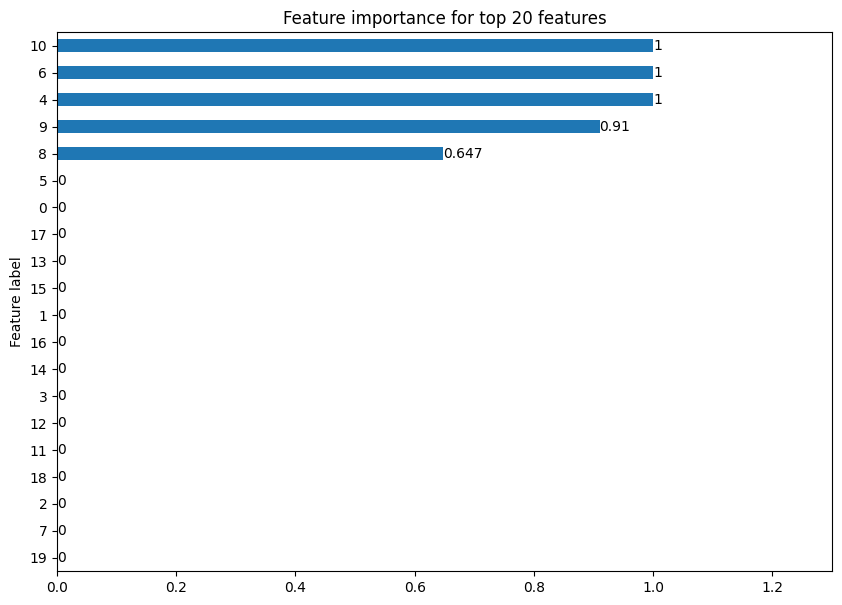

Explanation for graph conF_Mod.13.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


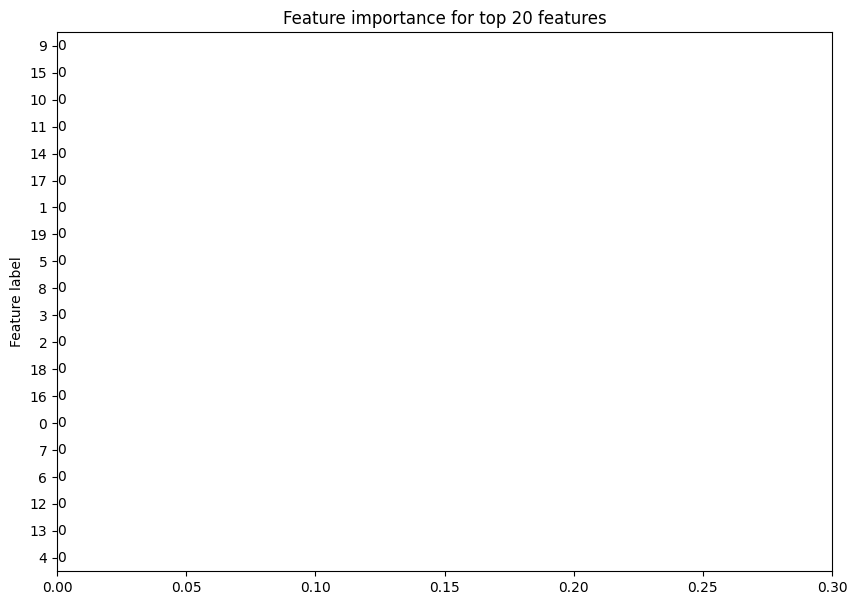

Explanation for graph hitP3_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


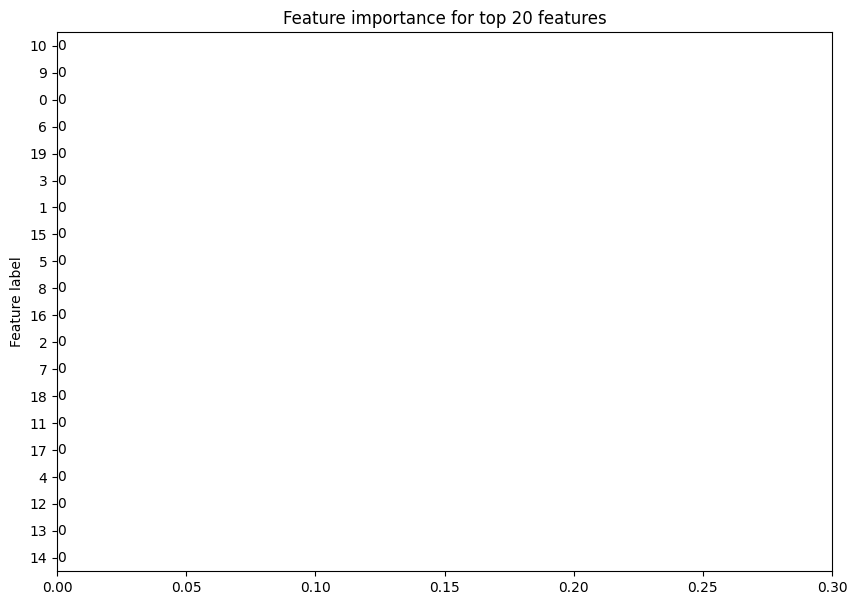

In [12]:
### Explainer loop ### 
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
import torch

import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
import pandas as pd
# Specify the folder where you want to save the output files
output_folder = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20240326_binaryclass_KS_dimers_KRandDHonly_graphSAGE_100000epoch/"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through your loader
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100000),
    explanation_type='phenomenon', # options are model (describes the model) or phenomenon (describes why descision was made for input and input label)
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw', 
    ),
)
# Iterate through your loader
loader = test_loader
for batch in loader:
    # Print some information about the current batch
    print(f"Processing batch with {batch.num_graphs} graphs")

    # Generate explanation for each graph in the batch
    for i in range(batch.num_graphs):
        # Extract data for the i-th graph in the batch
        graph_data = batch[i]

        # Create a new Data object
        data = Data(
            edge_index=graph_data.edge_index,
            node_id=graph_data.node_id,
            coords=graph_data.coords,
            name=graph_data.name,
            num_nodes=graph_data.num_nodes,
            x=graph_data.x.view(len(graph_data.node_id), 20),
        )

        # Extract the graph-level label for the current graph
        target_values = graph_data.graph_y.tolist()
        target = torch.tensor(target_values).float()

        # Generate explanation for the node at index `10`:
        explanation = explainer(x=data.x, edge_index=data.edge_index, batch=data.batch, target=target)

        # Print or do something with the explanation for the current graph
        print(f"Explanation for graph {graph_data.name}:", explanation.edge_mask, explanation.node_mask)

        # Optionally, you can visualize the feature importance for each graph
        explanation.visualize_feature_importance(top_k=20)

        # Save the output of visualize_graph to a file in the specified folder
        graphviz_output = explanation.visualize_graph(path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"), backend="graphviz")
        
# Iterate through your loader